# TODO

- [ ] Plug inflation in housing stock
- [ ] Add other autonomous expenditure

In [1]:
#!pip install pysolve3

Time checking:

In [2]:
from datetime import datetime
t1 = datetime.now()

# Introduction

Jupyter notebook for the simplest model scratch. By convention, all exogenous variables are presented with a overline line (*e.g.* $\overline a$) and the parameters are represented by greek letters (*e.g.* $\alpha$). The code in this document is executable and is strongly recommend to do the follow to ensure that the output is corrected and updated:

Run time > Restart and run all...

# Changes

In this version, the autonomous growth rate is endogenized as a function of housing own interest rates:

$$
g_Z = \phi_0  -\phi_1\cdot \left(\frac{1+r_{mo}}{1+\dot p_h}-1\right)
$$
which

- $\phi_0$ and $\phi_1$ are parameters
- $\dot p_h$ is housing inflation and equals 0 in this version

$$
\dot p_h = \frac{\Delta p_h}{p_{h_{-1}}}
$$

## General Equations

$$
Y = C + I
$$

$$
I = I_f + I_h
$$

$$
\omega = \overline \omega
$$

$$
W = \omega \cdot  Y
$$

$$
Y_K = \frac{K_f}{\overline v}
$$

$$
u = \frac{Y}{Y_K}
$$

$$
g_k = \frac{h\cdot u}{v}
$$

$$
Z = I_h
$$

$$
K = K_f + K_{HD}
$$

## Households

$$
YD = W + FD + \overline r_{m-1}\cdot M_{-1} - \overline r_{mo-1}\cdot MO - r_l\cdot{L_h}
$$


$$
S_h = YD - C = \Delta M
$$

$$
C = \alpha\cdot W
$$


$$
\Delta MO = I_h
$$

$$
V_h = M + K_H - MO
$$

$$
NFW_h = S_h - I_h
$$

$$
\text{Residual} = \Delta M - \Delta L_f 
$$

## Firms

$$
\Delta L_f = I_f - FU
$$

$$
FT = Y - W = FU+ FD
$$

$$
FU = \gamma_F\cdot (FT - r_{L_{-1}}\cdot L_{f_{-1}})
$$


$$
FD = (1 - \gamma_F)\cdot (FT - r_{L_{-1}}\cdot L_{f_{-1}})
$$

$$
I_f = h\cdot Y
$$

$$
\Delta K_f = I_f
$$

$$
\Delta h = 
h_{-1}\cdot \gamma_u\cdot (u - \overline u_n)
$$

$$
V_f = K_f  - L_f
$$

$$
NFW_f = FU - I_f
$$

## Banks

$$
L = L_f
$$

$$
\Delta M = \Delta L + \Delta MO
$$

$$
NFW_b = rl_{-1}\cdot L_{-1} + rmo_{-1}\cdot MO_{-1} - rm_{-1}\cdot M_{-1}
$$

$$
r_l = r_m + spread_l (=0)
$$

$$
r_{mo} = r_m + spread_{mo} (=0)
$$

$$
V_b = L + MO - M
$$

## Residential Investment


$$
K_{HS} = K_{HD}
$$

$$
I_h^S = I_h
$$

$$
\Delta K_{HD} = I_h
$$

$$
I_h = (1+g_Z)\cdot I_{h_{-1}}
$$


$$
k = \frac{K_h*p_h}{K}
$$

$$
g_Z = phi_0 - phi_1\cdot own
$$

$$
own = \left(\frac{1+r_{mo}}{1+\dot p}\right) -1
$$

# Simulation setup

## Loading libraries

In [3]:
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import networkx as nx
import sympy as sp
from sympy import pprint, cse

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from scipy.stats import yeojohnson

plt.style.use('seaborn-white')

from pysolve3.model import Model
from pysolve3.utils import SolveSFC, ShockModel, SummaryShock, SFCTable

import pandas_datareader.data as web
start = datetime(1987, 1, 1)
end = datetime(2018, 12, 31)

# Creating model function

In [4]:
def model(
    alpha = 1,
    #gamma_F = 0.4,
    gamma_F = 0.08,
    gamma_u = 0.01,
    g_Z = 0.05,
    omega = 0.4,
    #rm = 0.01,
    rm = 0.01,
    spread_l = 0,
    spread_mo = 0,
    un = 0.8,
    v = 2.5,
    phi_0 = 0.02,
    #phi_1 = 0.02,
    phi_1 = 0.1,
    infla = 0.0,
    phparam=1.0,
    R = 0.7,
    a=.0 # .1
):
  """
  phparam: 1.0 means no inflation
  """
  model = Model()
  model.set_var_default(0) 
  model.var('C', desc='Consumption')
  model.var('Cw', desc='Workers Consumption', default=112)
  model.var('Ck', desc='Capitalist Consumption', default=68)
  model.var('Eq', desc='Equities')
  model.var('FD', desc='Distributed profits')
  model.var('Fn', desc='Net profits')
  model.var('FT', desc='Total Profits')
  model.var('FU', desc='Retained profits')
  model.var('gk', desc='Capital growth rate')
  model.var('g_Z', desc='Autonomous grouth rate')
  model.var('h', desc='Marginal propensity to invest (non-residential)', default=0.06)
  model.var('I_t', desc='Investment', default = 100) # 200
  model.var('I_f', desc='Non-residential investment') # 100
  model.var('I_h', desc='Residential investment', default = 100) # 100
  model.var('Is', desc='Residential investment (Supply)', default = 100) # 100
  model.var('K_HS', desc='Houses supply', default=500) # 500
  model.var('K_HD', desc='Houses demand', default=500) # 500
  model.var('K_f', desc='Non-residential capital', default = 1000) # 10000
  model.var('Knom', desc='Nominal Capital', default=1500)
  model.var('K', desc='Real Capital', default=1500)
  model.var('K_k', desc="% of Kf in total")
  model.var('K_kr', desc="nominal % of Kf in total")
  model.var('L', desc='Total Loans') # 100
  model.var('Lf', desc='Firms Loans') # 100
  model.var('Lk', desc='Capitalist Loans') # 100
  model.var('M', desc='Money deposits') # 300
  model.var('M_h', desc='Households deposits')
  model.var('M_f', desc='Firms deposits')
  model.var('MO', desc='Mortgages') # 200
  model.var('NFW_h', desc='Households Capitalist Net Financial Wealth')
  model.var('NFW_hw', desc='Workers Net Financial Wealth', default=0)
  model.var('NFW_f', desc='Firms Net Financial Wealth')
  model.var('NFW_b', desc='Banks Net Financial Wealth')
  model.var('own', desc='Own interest rate')
  model.var('ph', desc='House price', default = 1)
  model.var('rl', desc='Interests rates on loans')
  model.var('rmo', desc='Interests rates on mortgages')
  model.var('S_hw', desc='Workers savings')
  model.var('S_hk', desc='Capitalist savings')
  model.var('u', desc='Capacity utilization ratio', default=0.7)
  model.var('V_h', desc='Household net nominal wealth')
  model.var('V_hr', desc='Household net real wealth')
  model.var('V_f', desc='Firms net wealth')
  model.var('V_b', desc='Banks net wealth')
  model.var('W', desc='Wages')
  model.var('Y', desc='GDP', default=280)
  model.var('Yk', desc='Capacity', default=1100)
  model.var('YDw', desc='Workers disposable income')
  model.var('YDk', desc='Capitalists disposable income')
  model.var('Z', desc='Autonomous expenditures')
  
  model.param('a', desc='Equity parameter', default=a)
  model.param('alpha', desc='Propensity to consume out of wages', default=alpha)
  model.param('gamma_F', desc='% of undistributed profits', default=gamma_F)
  model.param('gamma_u', desc='Adjustment parameter for the marginal propensity to invest', default=gamma_u) # 0.01
  model.param('omega', desc='Wage-share', default = omega)
  model.param('rm', desc='Interest rates on money deposits', default=rm) # 0.02
  model.param('spread_l', desc='Spread for loans', default=spread_l)
  model.param('spread_mo', desc='Spread for mortgages', default=spread_mo)
  model.param('un', desc='Normal capacity utilization ratio', default=un)
  model.param('v', desc='Capitl-Output ratio', default=v)
  model.param('phi_0', desc='Autonomous housing investment component',default = phi_0)
  model.param('phi_1', desc='Housing investment sensitivity to own interest rate', default = phi_1)
  model.param('R', desc='Autonomous ratio', default=R)
  model.param('infla', desc='infla value', default = infla)
  
  # General equations
  model.add('Y = C + I_t') # Eq1
  model.add('C = Cw + Ck')
  model.add('I_t = I_f + I_h') # Eq2
  model.add('Yk = K_f(-1)/v') # Eq 4
  model.add('u = Y/Yk') # Eq 5
  model.add('W = omega*Y') # Eq 6
  model.add('gk = h*u/v') # Eq 7
  model.add('Knom = K_HD*ph + K_f') # Eq 8 
  model.add('K = K_HD + K_f') # Eq 8 
  model.add('Z = I_h + Ck') # Eq 9
  
  # Workers equations
  model.add('Cw = alpha*W') # Eq 14
  model.add('YDw = W') # Eq 10
  model.add('S_hw = YDw - Cw') # Eq 11
  model.add('NFW_hw = S_hw')
    
  # Capitalist equations
  model.add('YDk = FD + rm*M_h(-1) - rmo*MO(-1) - rl*Lk(-1)')
  model.add('Ck = R*Z')
  model.add('S_hk = YDk - Ck') # Eq 11
  model.add('d(MO) = I_h') # Eq 12
  model.add('d(Lk) = Ck')
  model.add('d(M_h) = S_hk + d(Lk) - d(Eq)')
  model.add('V_h =  M_h  + K_HD*ph + Eq - MO - Lk') # Eq 15 
  model.add('V_hr =  M_h  + K_HD + Eq - MO - Lk') # Eq 15 
  model.add('NFW_h = S_hk - I_h') # Eq 16
  
  # Firms
  model.add('d(Lf) = I_f - FU - d(Eq) + d(M_f)') # Eq 15
  model.add('Eq = a*K_f(-1)')
  model.add('FT = (1-omega)*Y') # Eq 16
  model.add('Fn = FT -rl*Lf(-1) + rm*M_f(-1)')
  model.add('FU = gamma_F*(Fn)') # Eq 17
  model.add('FD = (1 - gamma_F)*(Fn)') # Eq 18
  model.add('I_f = h*Y') # Eq 19
  model.add('d(K_f) = I_f') # 20
  model.add('h = h(-1)*gamma_u*(u-un) + h(-1)') # Eq 21 # Version without corridor
  model.add('V_f = K_f + M_f - Lf - Eq') # Eq 22
  model.add('NFW_f = FU - I_f') # Eq 23
  
  # Banks
  model.add('rmo = (1+spread_mo)*rm') # Eq 25
  model.add('rl = (1+spread_l)*rm') # Eq 26
  model.add('NFW_b = rl*L(-1) + rmo*MO(-1) - rm*M(-1)') # Eq 28
  #model.add('d(M_f) = -d(Lf)')
  model.add('M_f = 0')
  #model.add('M_f = M - M_h')
  #model.add('d(M_h) = d(Lk) + d(MO)')
  #model.add('d(M_f) = d(Lf) + d(Eq) - NFW_f')
  #model.add('d(M) = d(L) + d(MO)')
  model.add('V_b = L + MO - M') # Eq 27
  model.add('d(L) = d(Lf) + d(Lk)')
  model.add('d(M) = d(M_h) + d(M_f)')
  
  
  # Residential investment
  model.add('K_HS = K_HD') # Eq 29
  model.add('Is = I_h')
  model.add('d(K_HD) = I_h') # Eq 30
  model.add('I_h = (1+g_Z)*I_h(-1)') # Eq 31
  model.add('K_k = K_HD/K') 
  model.add('K_kr = K_k*ph') 
  model.add('ph =(1+infla)*ph(-1)')
  model.add('own = ((1+rmo)/(1+infla)) -1')  
  model.add('g_Z = phi_0 - phi_1*own') 
  
  #model.var('Residual', desc='Unecessarily equation. Should be zero')
  #model.add('Residual = d(L) + d(MO) - d(M)') # Change!
  
  return model

t_check = 100
print('Evaluating consistenty at time = {}'.format(t_check))

test = model()
SolveSFC(test, time=t_check, table = False)
evaldf = pd.DataFrame({
    'Capitalists' : test.evaluate('K_HD*ph + M_h + Eq - MO - Lk - V_h'),
    'Firms' : test.evaluate('K_f - Lf - Eq - V_f'),
    'Banks' : test.evaluate('L + MO - M - V_b'),
    'Mortgages' : test.evaluate('MO(-1) - MO(-2) - I_h(-1)'),
    'Loans' : test.evaluate('L - Lf - Lk'),
    'Financial assets' : test.evaluate('d(MO) + d(L) - d(M)'),
    '[Total Wealth - K]' : test.evaluate('V_f + V_h + V_b - K'),
    "Firm's Funds" : test.evaluate('Lf(-1) - Lf(-2) - I_f(-1) + FU(-1) + Eq(-1) - Eq(-2)  - (M_f(-1) - M_f(-2))'),
    "Housing" : test.evaluate('K_HD - K_HS'),
    "Flow check" : test.evaluate('NFW_h + NFW_f + NFW_b + NFW_hw'),
    "Investment" : test.evaluate('I_t - I_h - I_f'),
    "Profits" : test.evaluate('FT(-1) - rl*Lf(-2) - FU(-1) - FD(-1)'), # Chanve
    "Wages" : test.evaluate('W - omega*Y'),
    "Residual" : test.evaluate('d(L) + d(MO) - d(M)')
}, index = ['Sum'])
evaldf = evaldf.transpose()
evaldf.round(5)

Evaluating consistenty at time = 100


Sum
Capitalists        -0.00000
Firms               0.00000
Banks              -0.00006
Mortgages           0.00000
Loans               0.00000
Financial assets   -0.00000
[Total Wealth - K]  0.00006
Firm's Funds       -0.00000
Housing             0.00000
Flow check         -0.00014
Investment         -0.00001
Profits            -0.00000
Wages               0.00000
Residual           -0.00000

In [5]:
t_check = 1
print('Evaluating at time = {}'.format(t_check))

test = model()
SolveSFC(test, time=t_check, table = False)
evaldf = pd.DataFrame({
    'Cw' : test.evaluate('Cw'),
    'Ck' : test.evaluate('Ck'),
    'I_h' : test.evaluate('I_h'),
    'I_f' : test.evaluate('I_f'),
    'K_f(-1)' : test.evaluate('K_f(-1)'),
    'Yk' : test.evaluate('Yk'),
    'Y' : test.evaluate('Y'),
    'gk' : test.evaluate('gk'),
    'u' : test.evaluate('u'),
    "Residual" : test.evaluate('d(L) + d(MO) - d(M)')
}, index = ['Sum'])
evaldf = evaldf.transpose()
evaldf.round(5)

Evaluating at time = 1


Sum
Cw         251.82140
Ck         237.76666
I_h        101.90000
I_f         38.06553
K_f(-1)   1038.06553
Yk         400.00000
Y          629.55351
gk           0.03807
u            1.57388
Residual     0.00000

In [6]:
t_check=200
variable = 'gamma_F'
for i in range(0,11,1):
    i = i/10
    print(f'{variable} = {i}')
    check = model(gamma_F=i)
    SolveSFC(check, time=t_check, table = False)
    evaldf = pd.DataFrame({
        'S_hk > 0?' : check.evaluate('S_hk')>0,
        'NFW_h > 0?' : check.evaluate('NFW_h')>0,
        'NFW_f > 0?' : check.evaluate('NFW_f')>0,
        'NFW_b ~ 0?' : check.evaluate('NFW_b'),
        'V_b ~ 0?' : check.evaluate('V_b'),
        'Lf > 0?': check.evaluate('Lf')>0,
        'u:': check.evaluate('u'),
        'FT > Fn?': check.evaluate('FT')>check.evaluate('Fn'), 
        "Residual" : check.evaluate('d(L) + d(MO) - d(M)')
    }, index = [f'{variable} = {i}'])
    evaldf = evaldf.transpose().round(5)
    print(evaldf)

gamma_F = 0.0
           gamma_F = 0.0
S_hk > 0?           True
NFW_h > 0?          True
NFW_f > 0?         False
NFW_b ~ 0?   0.000928314
V_b ~ 0?       0.0939694
Lf > 0?             True
u:              0.704439
FT > Fn?            True
Residual               0
gamma_F = 0.1
           gamma_F = 0.1
S_hk > 0?           True
NFW_h > 0?          True
NFW_f > 0?         False
NFW_b ~ 0?   0.000928314
V_b ~ 0?       0.0939694
Lf > 0?             True
u:              0.704439
FT > Fn?            True
Residual               0
gamma_F = 0.2
           gamma_F = 0.2
S_hk > 0?           True
NFW_h > 0?         False
NFW_f > 0?          True
NFW_b ~ 0?   0.000928314
V_b ~ 0?       0.0939694
Lf > 0?            False
u:              0.704439
FT > Fn?           False
Residual               0
gamma_F = 0.3
           gamma_F = 0.3
S_hk > 0?           True
NFW_h > 0?         False
NFW_f > 0?          True
NFW_b ~ 0?   0.000928314
V_b ~ 0?       0.0939694
Lf > 0?            False
u:              0.7

# Solving

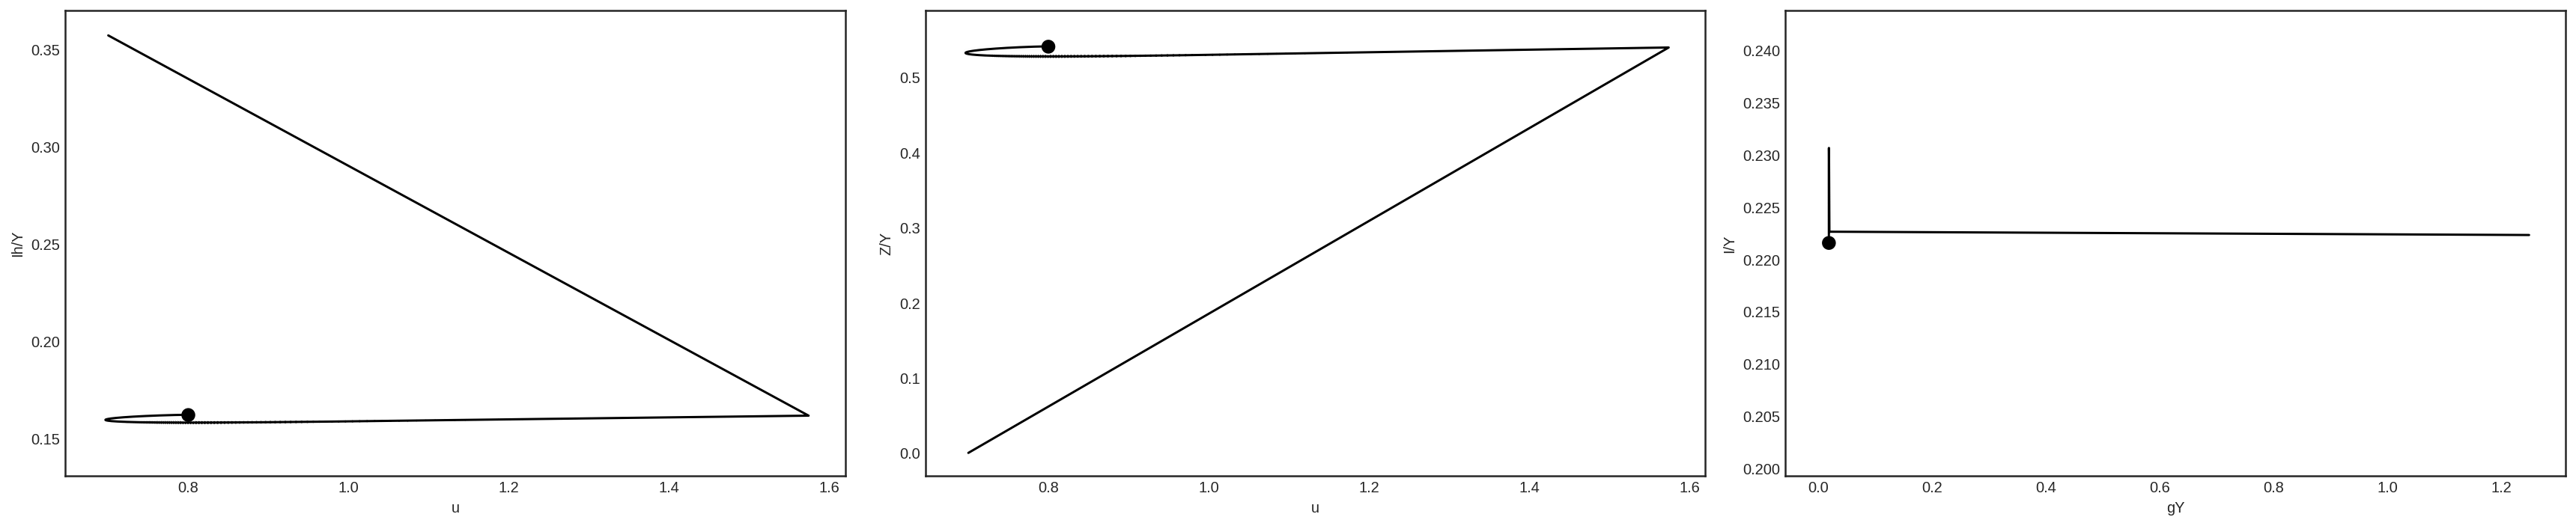

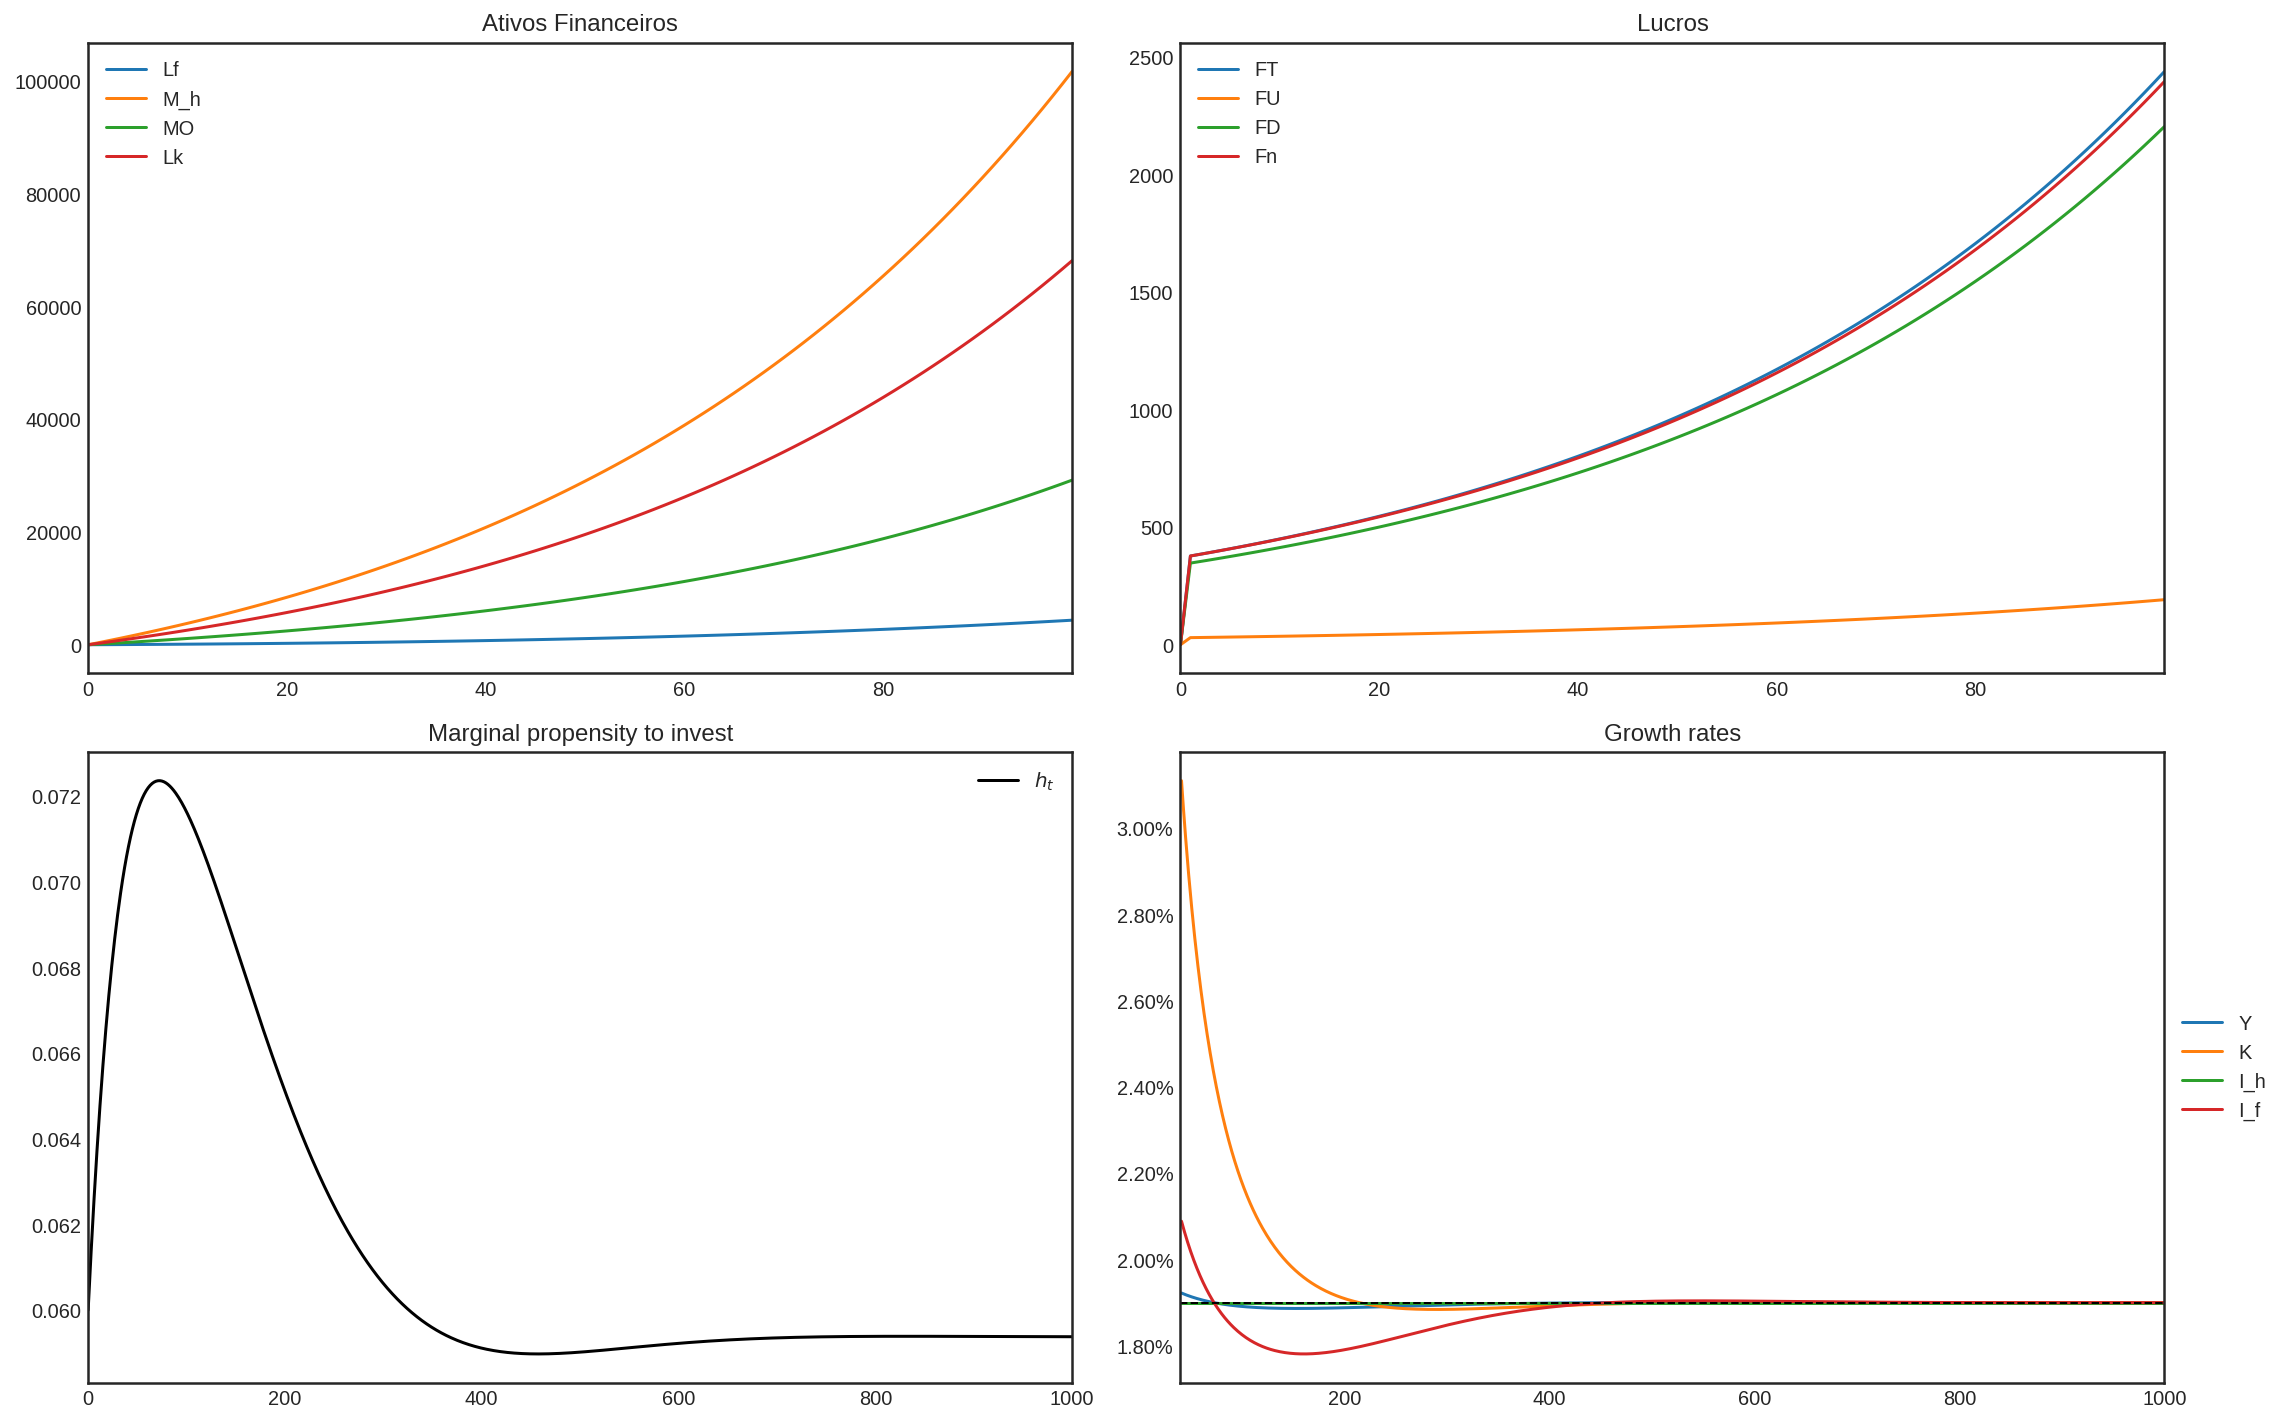

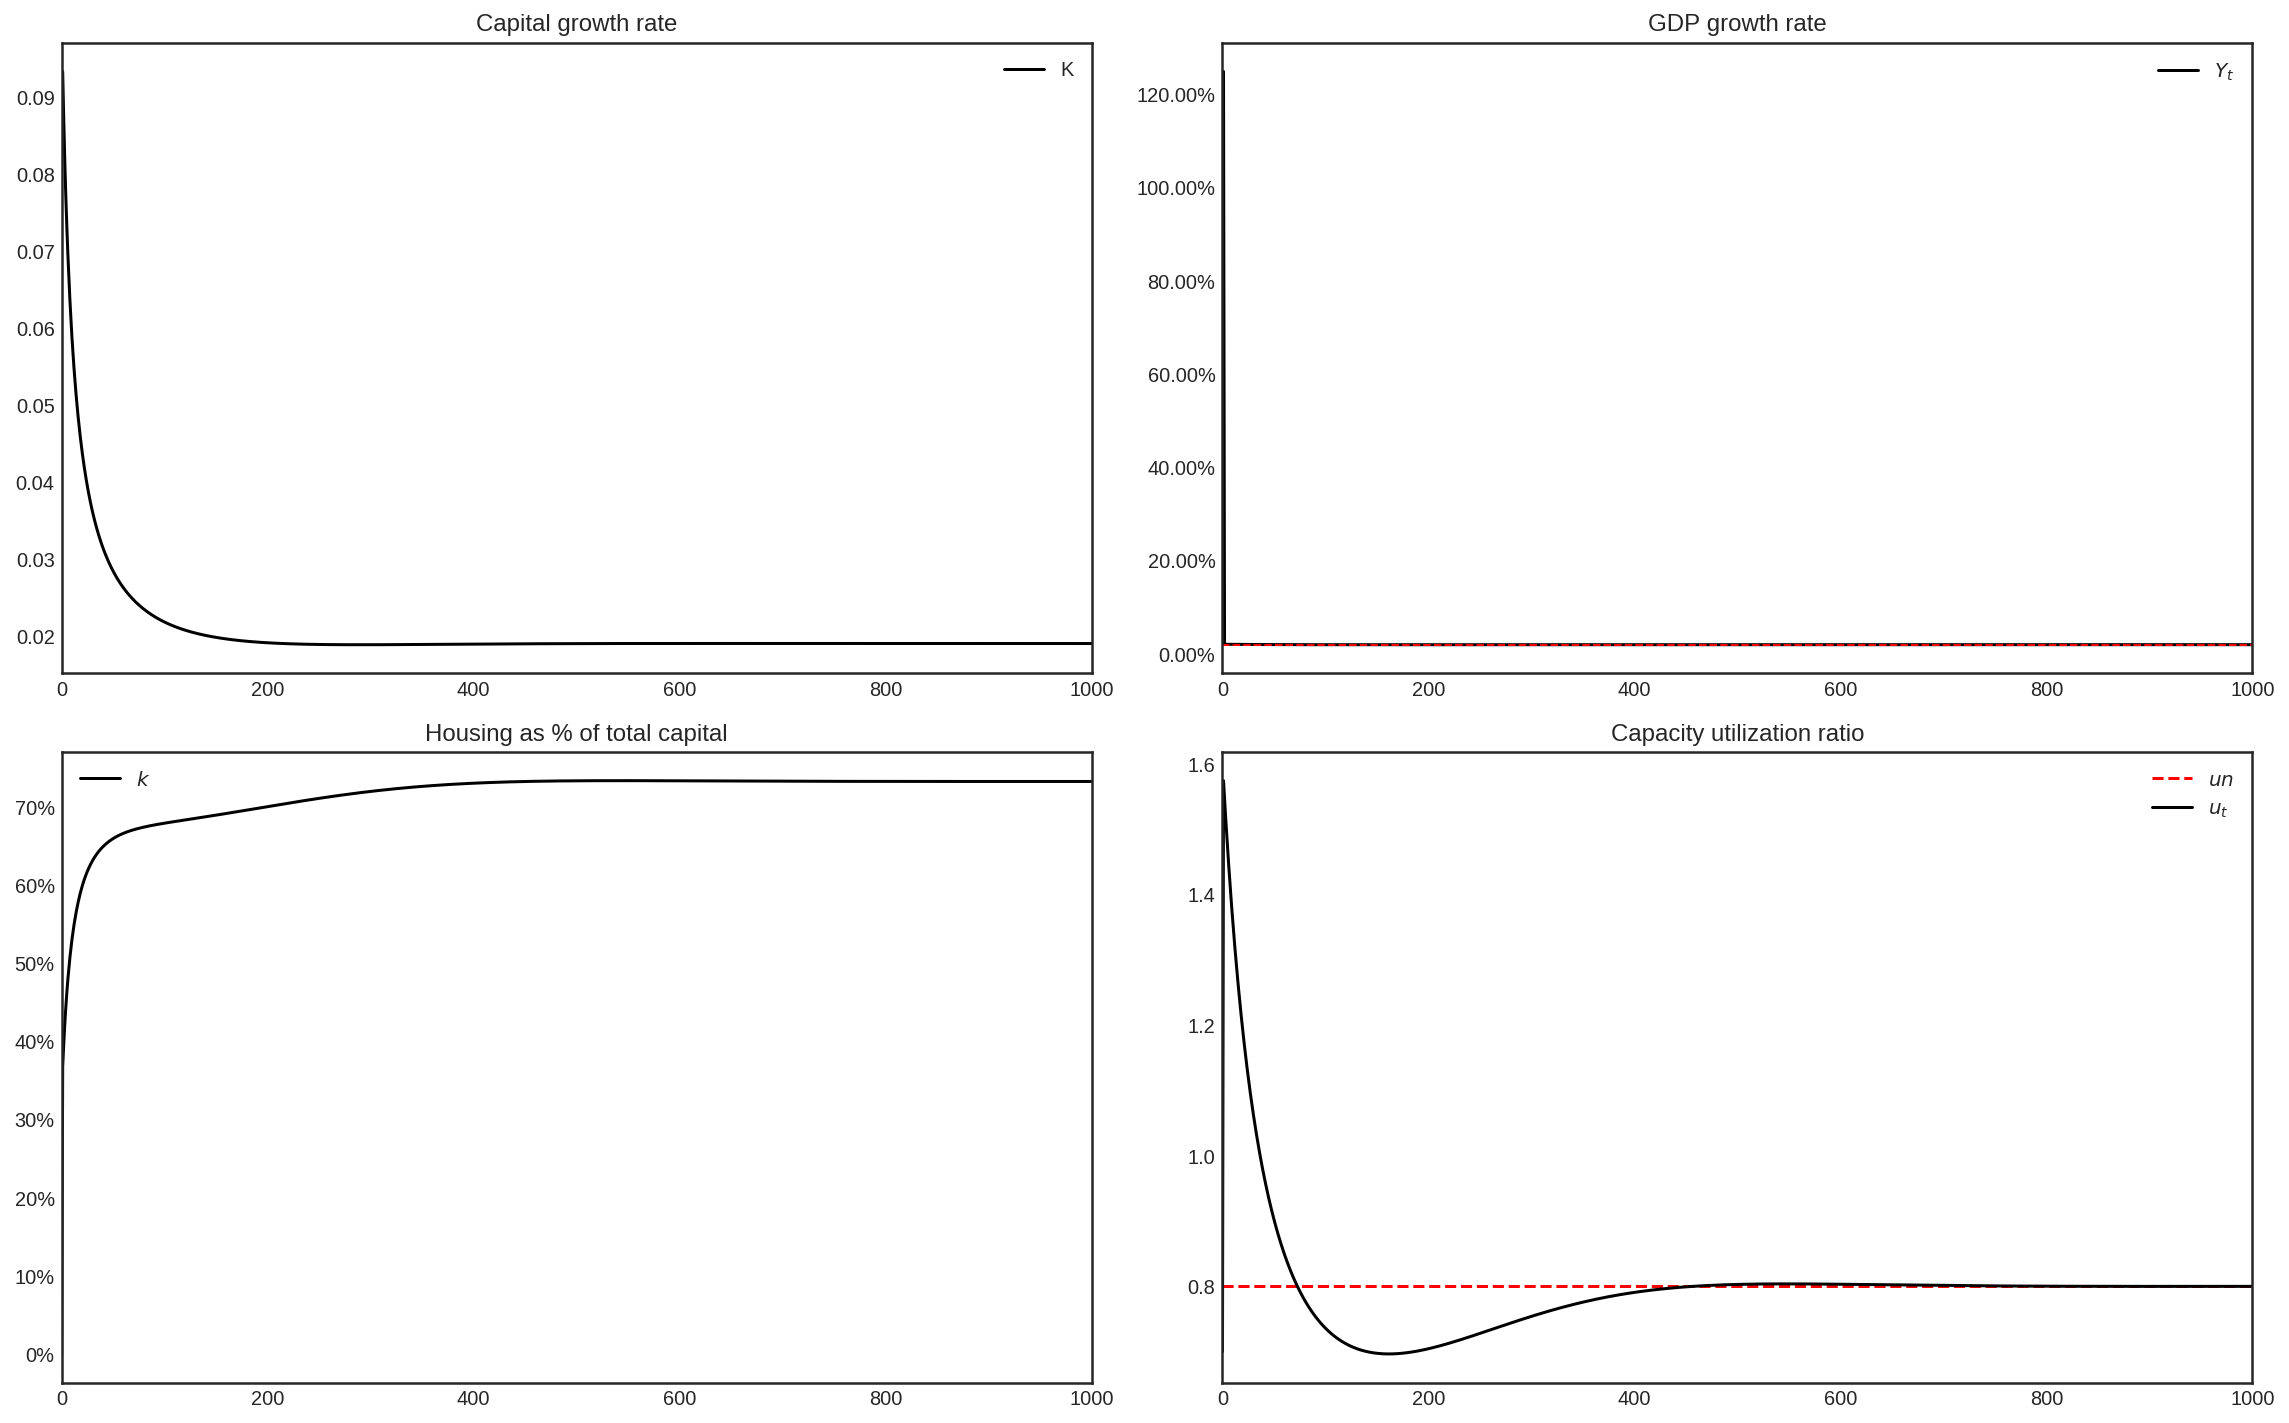

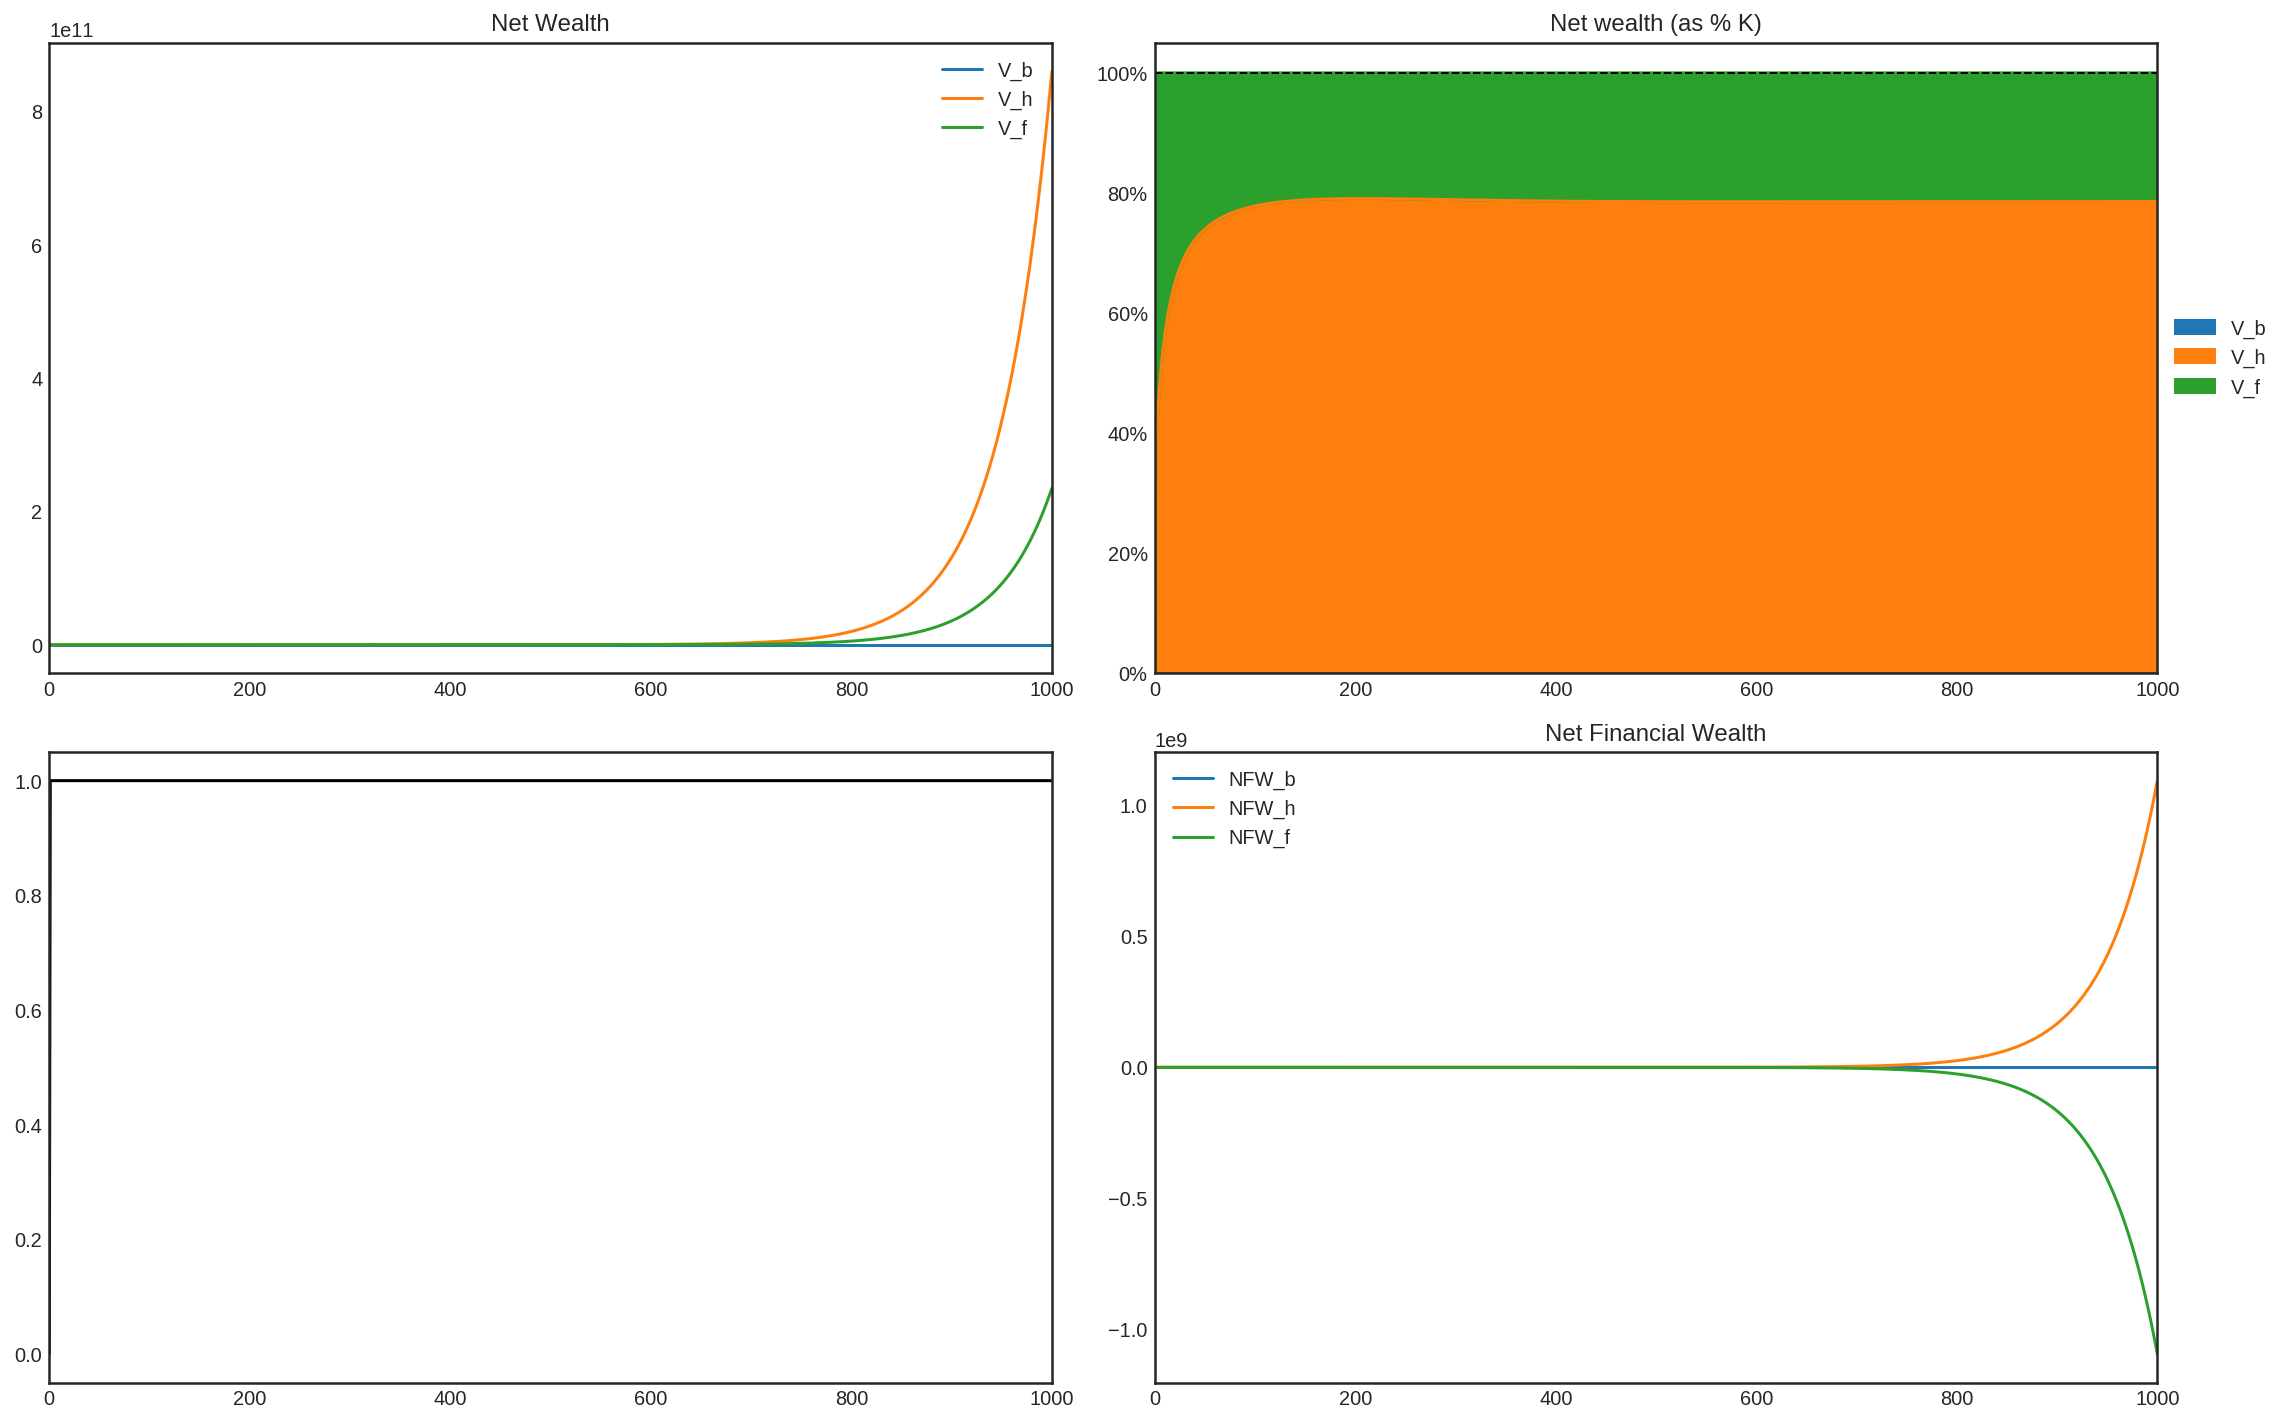

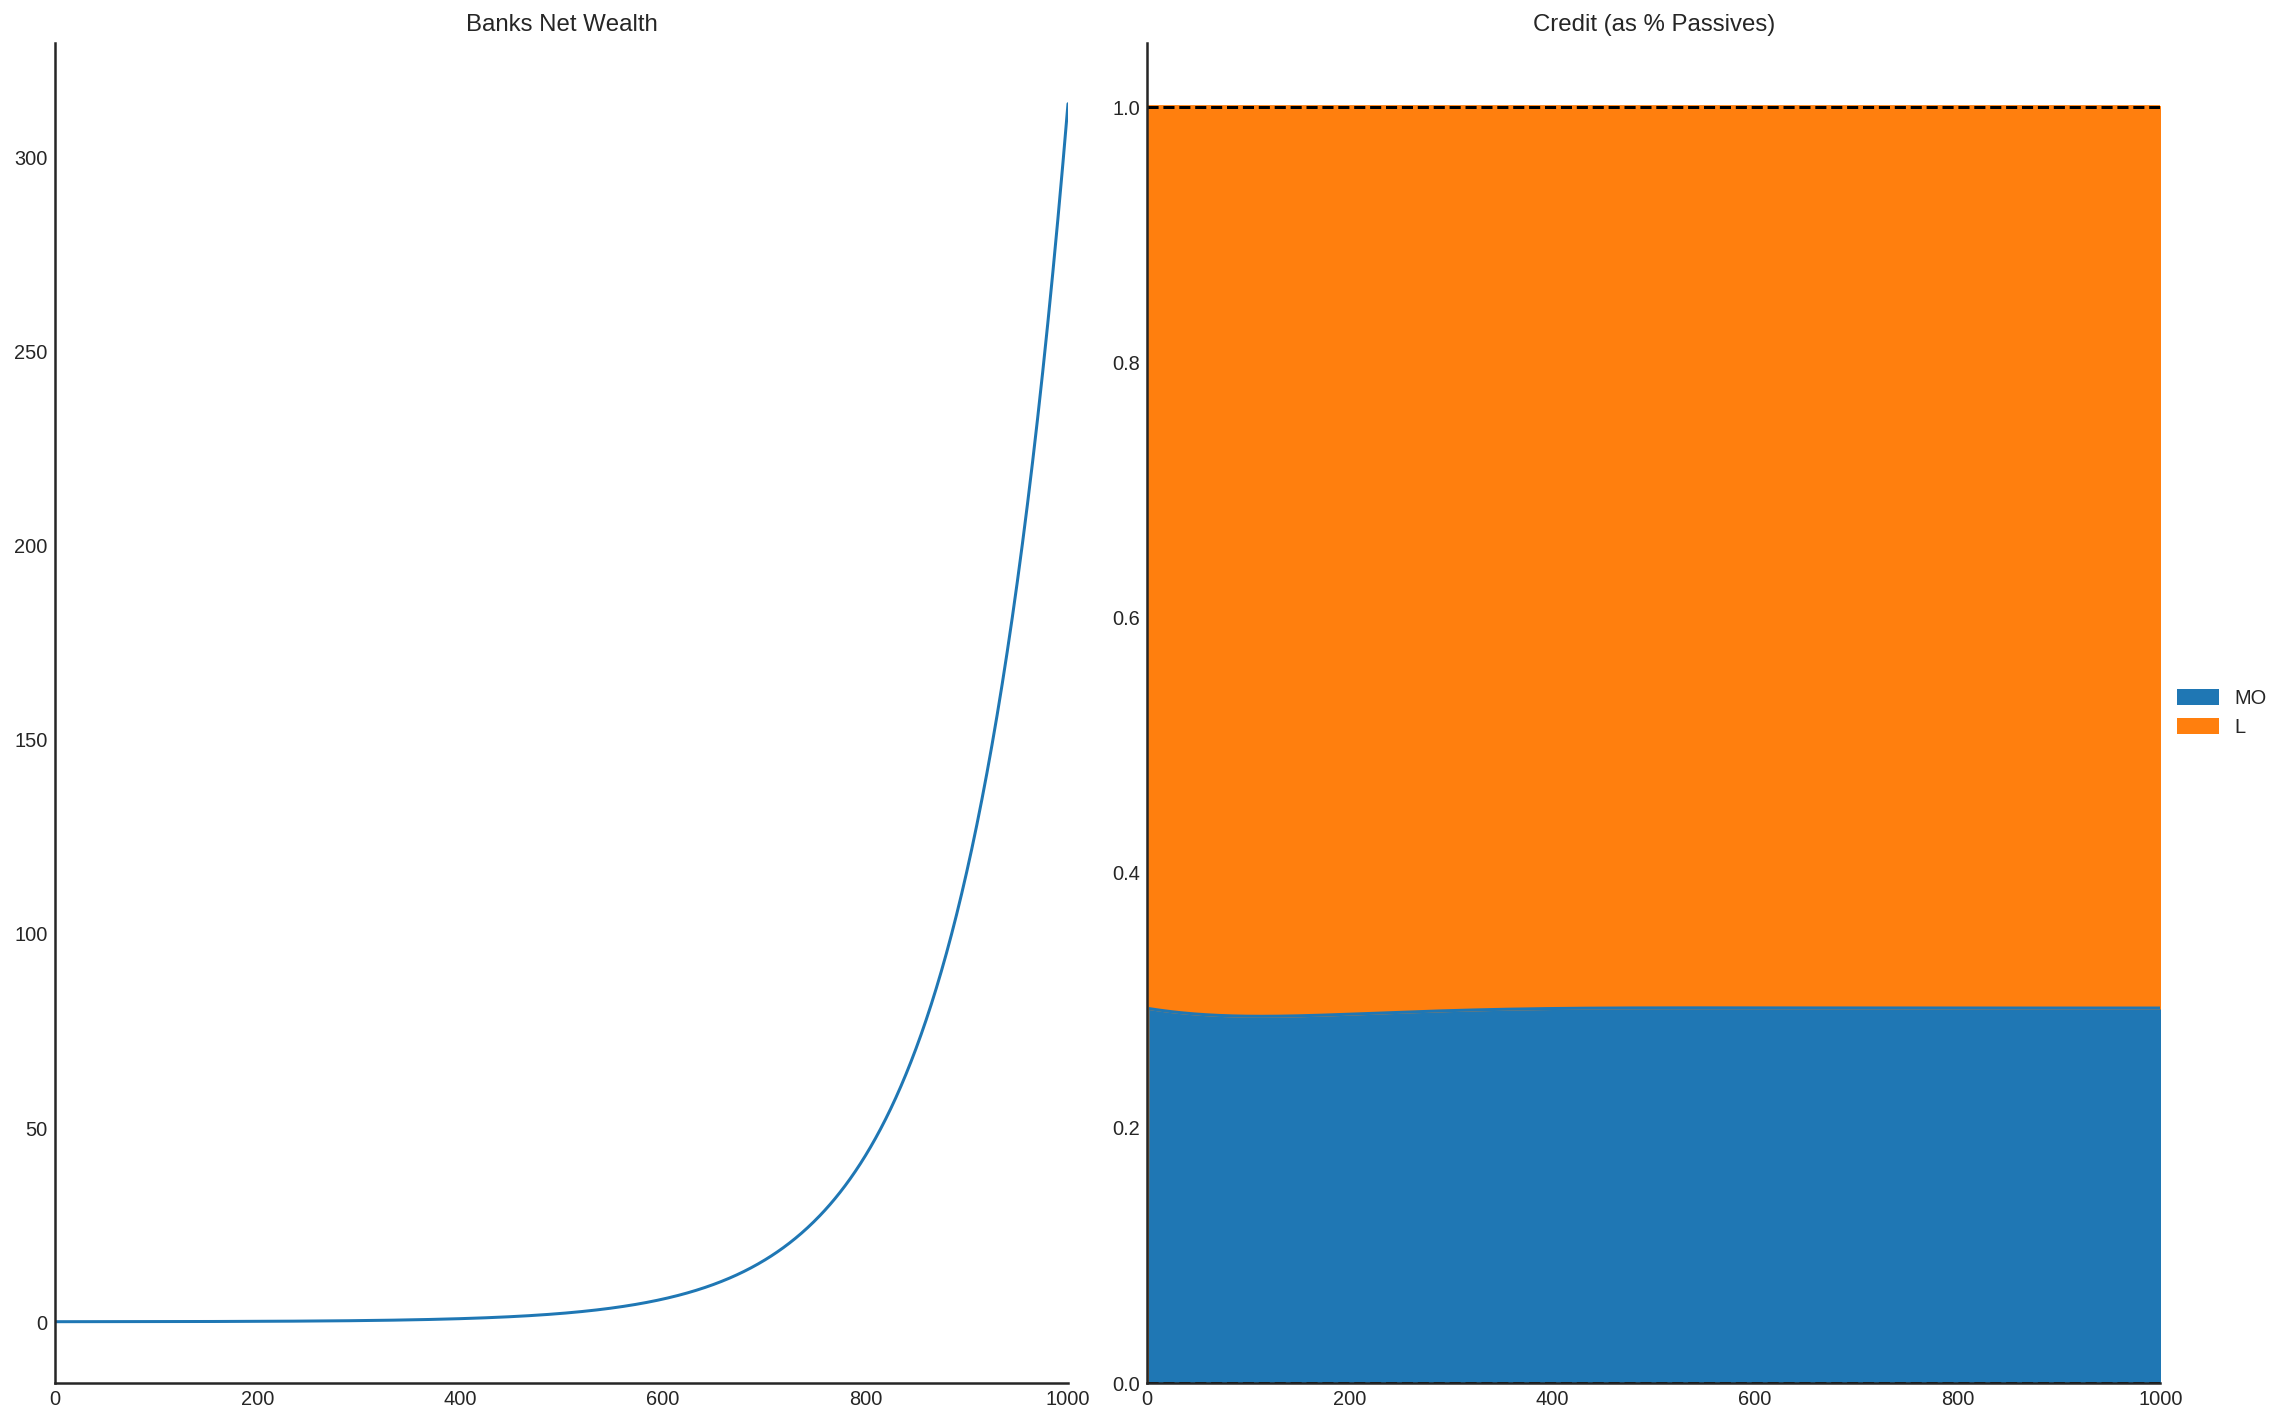

0           1           2           3           4           5     \
C       0.000000  489.588029  499.104970  508.800957  518.679333  528.743520   
Cw    112.000000  251.821402  256.820783  261.913371  267.100882  272.385079   
Ck     68.000000  237.766660  242.284225  246.887625  251.578490  256.358481   
Eq      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
FD      0.000000  347.513535  354.340488  361.291911  368.370113  375.577469   
...          ...         ...         ...         ...         ...         ...   
TIME    1.000000    2.000000    3.000000    4.000000    5.000000    6.000000   
Ih/Y    0.357143    0.161861    0.161725    0.161594    0.161466    0.161342   
I/Y     0.357143    0.222325    0.222641    0.222948    0.223246    0.223535   
Z/Y     0.000000    0.539536    0.539085    0.538646    0.538220    0.537807   
gY           NaN    1.248405    0.019853    0.019829    0.019806    0.019784   

            6           7           8           9     ...          991   \
C     538.997011  549.443361  560.086199  570.929264  ...  6.050963e+10   
Cw    277.767759  283.250755  288.835933  294.525228  ...  3.109298e+10   
Ck    261.229293  266.192649  271.250309  276.404068  ...  2.941664e+10   
Eq      0.000000    0.000000    0.000000    0.000000  ...  0.000000e+00   
FD    382.916397  390.389367  397.998895  405.747588  ...  4.246108e+10   
...          ...         ...         ...         ...  ...           ...   
TIME    7.000000    8.000000    9.000000   10.000000  ...  9.920000e+02   
Ih/Y    0.161222    0.161105    0.160991    0.160881  ...  1.621862e-01   
I/Y     0.223816    0.224089    0.224354    0.224611  ...  2.215655e-01   
Z/Y     0.537405    0.537016    0.536637    0.536270  ...  5.406208e-01   
gY      0.019761    0.019739    0.019718    0.019697  ...  1.899989e-02   

              992           993           994           995           996   \
C     6.165931e+10  6.283083e+10  6.402461e+10  6.524108e+10  6.648065e+10   
Cw    3.168374e+10  3.228573e+10  3.289916e+10  3.352424e+10  3.416120e+10   
Ck    2.997556e+10  3.054510e+10  3.112545e+10  3.171684e+10  3.231946e+10   
Eq    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
FD    4.326784e+10  4.408992e+10  4.492763e+10  4.578125e+10  4.665109e+10   
...            ...           ...           ...           ...           ...   
TIME  9.930000e+02  9.940000e+02  9.950000e+02  9.960000e+02  9.970000e+02   
Ih/Y  1.621862e-01  1.621863e-01  1.621863e-01  1.621863e-01  1.621863e-01   
I/Y   2.215654e-01  2.215654e-01  2.215653e-01  2.215653e-01  2.215653e-01   
Z/Y   5.406208e-01  5.406209e-01  5.406209e-01  5.406210e-01  5.406210e-01   
gY    1.899989e-02  1.899989e-02  1.899989e-02  1.899989e-02  1.899989e-02   

              997           998           999           1000  
C     6.774378e+10  6.903091e+10  7.034249e+10  7.167900e+10  
Cw    3.481025e+10  3.547165e+10  3.614560e+10  3.683237e+10  
Ck    3.293353e+10  3.355926e+10  3.419689e+10  3.484663e+10  
Eq    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
FD    4.753746e+10  4.844067e+10  4.936104e+10  5.029889e+10  
...            ...           ...           ...           ...  
TIME  9.980000e+02  9.990000e+02  1.000000e+03  1.001000e+03  
Ih/Y  1.621863e-01  1.621863e-01  1.621864e-01  1.621864e-01  
I/Y   2.215652e-01  2.215652e-01  2.215652e-01  2.215651e-01  
Z/Y   5.406211e-01  5.406212e-01  5.406212e-01  5.406213e-01  
gY    1.899989e-02  1.899990e-02  1.899990e-02  1.899990e-02  

[82 rows x 1001 columns]

In [7]:
base = model()
df = SolveSFC(base, time=1000)

fig, ax = plt.subplots(1,3, figsize=(24,5))

df["TIME"] = [i+1 for i in range(len(df.index))]
df["Ih/Y"] = df["I_h"]/df["Y"]
df["I/Y"] = df["I_t"]/df["Y"]
df["Z/Y"] = df["Z"]/df["Y"]
df["gY"] = df["Y"].pct_change()

sns.scatterplot(y = 'Ih/Y', x='u', data=df, size="TIME", sizes = (1,100), color = 'black', legend=False, ax=ax[0])
sns.lineplot(y = 'Ih/Y', x='u', data=df, sort=False, color = 'black', ax=ax[0])

sns.scatterplot(y = 'Z/Y', x='u', data=df, size="TIME", sizes = (1,100), color = 'black', legend=False, ax=ax[1])
sns.lineplot(y = 'Z/Y', x='u', data=df, sort=False, color = 'black', ax=ax[1])

sns.scatterplot(y = 'I/Y', x='gY', data=df, size="TIME", sizes = (1,100), color = 'black', legend=False, ax=ax[2])
sns.lineplot(y = 'I/Y', x='gY', data=df, sort=False, color = 'black', ax=ax[2])

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2,2, figsize=(16,10))

df[['Lf', "M_h", "MO", "Lk"]][:100].plot(ax=ax[0,0], title='Ativos Financeiros')

df[['FT', "FU", "FD", "Fn"]][:100].plot(title='Lucros', ax=ax[0,1])

df['h'].plot(color = "black", ls="-",  title = "Marginal propensity to invest", label = "$h_t$", legend = True,ax=ax[1,0])

df[["Y", "K", "I_h", "I_f"]][40:].pct_change().plot(title = "Growth rates",ax=ax[1,1])
ax[1,1].set_yticklabels(['{:,.2%}'.format(x) for x in ax[1,1].get_yticks()])
ax[1,1].axhline(y=df["g_Z"].iloc[-1], color = "black", ls = "--", lw=1)
ax[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.tight_layout()
plt.show()


fig, ax = plt.subplots(2,2, figsize=(16,10))


df[["K"]].pct_change().plot(ax=ax[0,0], color='black', title='Capital growth rate')

df['Y'].pct_change().plot(color = "black", title = "GDP growth rate", label = "$Y_t$", legend = True, ax=ax[0,1])
ax[0,1].axhline(y=df["g_Z"].iloc[-1], color = "red", ls = "--", lw=1, label = "Autonomous growth rate")
ax[0,1].set_yticklabels(['{:,.2%}'.format(x) for x in ax[0,1].get_yticks()])

df['K_k'].plot(color = "black", title = "Housing as % of total capital", label = "$k$", legend = True, ax=ax[1,0])
ax[1,0].set_yticklabels(['{:,.0%}'.format(x) for x in ax[1,0].get_yticks()])

df['un'].plot(color = "red", ls="--",  title = "Capacity utilization ratio", label = "$un$", legend = True,ax=ax[1,1])
df['u'].plot(color = "black", title = "Capacity utilization ratio", label = "$u_t$", legend = True, ax=ax[1,1])
#ax[1,1].set_yticklabels(['{:,.1%}'.format(x) for x in ax[1,1].get_yticks()])

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2,2, figsize=(16,10))

df[["V_b", "V_h", "V_f"]].plot(title = "Net Wealth", ax=ax[0,0])

df[['V_b', 'V_h', 'V_f']].apply(lambda x: np.abs(x)/df['K']).plot(kind = 'area', stacked = True, title = "Net wealth (as % K)", ax=ax[0,1])
ax[0,1].set_yticklabels(['{:,.0%}'.format(x) for x in ax[0,1].get_yticks()])
ax[0,1].axhline(y=1, color = "black", ls = "--", lw=1)
ax[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

((df['V_b'] + df['V_f'] + df['V_h'])/df['K']).plot(label='Consistensy check', color='black', ax=ax[1,0])
ax[1,0].axhline(y=1, color = "black", ls = "--", lw=1)

df[["NFW_b", "NFW_h", "NFW_f"]].plot(title = "Net Financial Wealth", ax=ax[1,1])

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(16,10))

df['V_b'].plot(title = "Banks Net Wealth", ax=ax[0])
df[["MO", "L"]].apply(lambda x: x/(df["MO"] + df['L'])).plot(kind = "area",stacked = True ,title = "Credit (as % Passives)", ax=ax[1])
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].axhline(y = 1, color = "black", ls = "--")
ax[1].axhline(y = 0, color = "black", ls = "--")

sns.despine()
plt.tight_layout()
plt.show()

df_base = df
df.transpose()

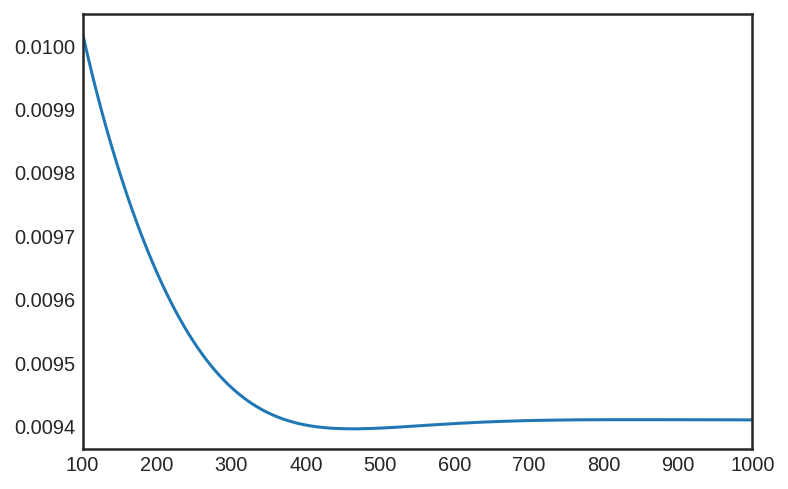

In [8]:
(df['NFW_h']/(df['Lk'] + df['MO']) - (df['rm'] - df['g_Z']))[100:].plot()

# Shocks

In [9]:
def clock_plots(shock, filename, variable):
    shock["TIME"] = [i+1 for i in range(len(shock.index))]
    shock["Ih/Y"] = shock["I_h"]/shock["Y"]
    shock["I/Y"] = shock["I_t"]/shock["Y"]
    shock["Z/Y"] = shock["Z"]/shock["Y"]
    shock["gY"] = shock["Y"].pct_change()
    
    sns.set_context('talk')
    fig, ax = plt.subplots(1,3,figsize=(24,5)
                          )
    
    sns.scatterplot(y = 'Ih/Y', x='u', data=shock, size="TIME", sizes = (1,200), color = 'black', legend=False, ax=ax[0])
    sns.lineplot(y = 'Ih/Y', x='u', data=shock, sort=False, color = 'black', ax=ax[0])
    ax[0].set_title("(A) Taxa de investimento residencial\n VS Grau de utilização")
    
    sns.scatterplot(y = 'Z/Y', x='u', data=shock, size="TIME", sizes = (1,200), color = 'black', legend=False, ax=ax[1])
    sns.lineplot(y = 'Z/Y', x='u', data=shock, sort=False, color = 'black', ax=ax[1])
    ax[1].set_title("(B) Participação dos gastos autônomos\n VS Grau de utilização")
    
    sns.scatterplot(y = 'I/Y', x='gY', data=shock, size="TIME", sizes = (1,200), color = 'black', legend=False, ax=ax[2])
    sns.lineplot(y = 'I/Y', x='gY', data=shock, sort=False, color = 'black', ax=ax[2])
    ax[2].set_title("(C) Taxa de investimento total\n VS Taxa de crescimento da economia")
    
    
    sns.despine()
    plt.show()
    
    fig.savefig(filename, dpi = 300)

In [10]:
def plot_shock(filename, shock):
    """
    This function plots some selected variables
    
    filename: name to save the plot (str)
    shock: df returned by ShockModel function
    """
    sns.set_context('talk')
    fig, ax = plt.subplots(2,2, figsize=(16,10))

    shock[["Y"]].pct_change().plot(title = "Taxas de crescimento", ax = ax[0,0], 
                                                      ls = ('--'), lw=3,
                                                      )
    shock[["K"]].pct_change().plot(title = "Taxas de crescimento", ax = ax[0,0], 
                                                      ls = (':'), lw=3
                                                      )
    shock[["I_h"]].pct_change().plot(title = "Taxas de crescimento", ax = ax[0,0], 
                                                      ls = ('-'), lw=3,
                                                      )
    shock[["I_f"]].pct_change().plot(title = "Taxas de crescimento", ax = ax[0,0], 
                                                      ls = ('-.'), lw=3,
                                                      )
    ax[0,0].axhline(y=shock["g_Z"].iloc[-1], color = "black", ls = "--", lw=2.5)
    #ax[0,0].set_yticklabels(['{:,.1%}'.format(x) for x in ax[0,0].get_yticks()])
    ax[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.06),
                   labels = ["$Y$", "$K$", "$I_h$", "$I_f$"],
              fancybox=True, shadow=True, ncol=2)
    ax[0,0].ticklabel_format(useOffset=False)

    ((shock["Z"]/shock['Y'])).plot(title = "Participação dos gastos autônomos na renda", ax = ax[0,1], ls = ('-'), lw=3, color='darkred')
    
    ax[0,1].set_ylim(auto=True)
    ax[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
                   labels=['$Z/Y$'],
              fancybox=True, shadow=True, ncol=2)

    shock['u'].plot(title = 'Grau de utilização da capacidade', ax=ax[1,0], legend = False, color = "darkred", lw = 3, )
    ax[1,0].axhline(y = shock['un'].iloc[-1], ls ='--', color = "gray")
    #ax[1,0].set_yticklabels(['{:,.2%}'.format(x) for x in ax[1,0].get_yticks()])
    ax[1,0].ticklabel_format(useOffset=False)

    shock['h'].plot(title = 'Propensão marginal a investir', ax=ax[1,1], legend = False, color = "darkred", lw = 3, )
    ax[1,1].axhline(y = df['h'].iloc[-1], ls ='--', color = "gray")
    ax[1,1].ticklabel_format(useOffset=False)
    
    sns.despine()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    fig.savefig(filename, dpi = 300)

In [11]:
def plot_norms(filename, shock):
    """
    This function plots some selected variables
    
    filename: name to save the plot (str)
    shock: df returned by ShockModel function
    """
    sns.set_context('talk')
    fig, ax = plt.subplots(2,2, figsize=(16,10))

    ((shock["YDk"]/shock['V_h'])**(1)).plot(title = "Fluxo/Estoque", ax = ax[0,0], ls = (':'), lw=3)
    ((shock["YDk"]/shock['V_hr'])**(1)).plot(ax = ax[0,0], ls = ('-'), lw=3)
    ((shock["FU"]/shock['V_f'])**(1)).plot(ax = ax[0,0], ls = ('-'), lw=3)
    
    ax[0,0].set_yticklabels(['{:,.1%}'.format(x) for x in ax[0,0].get_yticks()])
    ax[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
                   labels = [
                       "$YDk/V_{hk}$",
                       "$YDk/V_{hkr}$",
                       "$FU$/V_f",
                            ],
              fancybox=True, shadow=True, ncol=2)
    #ax[0,0].ticklabel_format(useOffset=False)
    
    shock['K_k'].plot(color = "darkred", title = "Participação dos imóveis no \nestoque de capital total", label = "$\k$", legend = False, ax = ax[0,1], lw = 3, )
    ax[0,1].axhline(y = df['K_k'].iloc[-1], ls ='--', color = "gray")
    ax[0,1].ticklabel_format(useOffset=False)
    
    (shock["MO"]*shock["rmo"][1:]/shock['YDk'][1:]).plot(title="Comprometimento da renda \ndisponível com dívida", ax = ax[1,0], ls = ('-'), lw=3)
    ((shock["Lk"]*shock["rl"][1:])/shock['YDk'][1:]).plot(ax = ax[1,0], ls = ('-'), lw=3)
    ((shock["MO"]*shock["rmo"][1:] + shock["Lk"]*shock["rl"][1:])/shock['YDk'][1:]).plot( ax = ax[1,0], ls = ('-'), lw=3)
    ax[1,0].set_yticklabels(['{:,.1%}'.format(x) for x in ax[1,0].get_yticks()])
    ax[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                   labels = [
                       'Mortgage',
                       'Loans',
                       'Total'
                            ],
              fancybox=True, shadow=True, ncol=2)
    
    (shock['FT']/shock['K_f']).plot(ax=ax[1,1], label='Taxa de lucro bruta')
    (shock['Fn']/shock['K_f']).plot(ax=ax[1,1], label='Taxa de lucro líquida')
    ax[1,1].set_yticklabels(['{:,.1%}'.format(x) for x in ax[1,0].get_yticks()])
    ax[1,1].legend()

    
    sns.despine()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    fig.savefig(filename, dpi = 300)

In [12]:
def other_plots(shock):

    (shock['MO']/(shock['M'])).plot(title="Mortgage as % of deposits")
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots()
    (shock['FT']/shock['K_f']).plot(ax=ax, label='Gross profit rate')
    (shock['Fn']/shock['K_f']).plot(ax=ax, label='Net profit rate')
    ax.legend()
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots()
    (shock['YDk']/shock['K_HD']).plot(ax=ax, label='Real', title="Disposible income as % of Housing")
    (shock['YDk']/(shock['K_HD']*shock['ph'])).plot(ax=ax, label='Nominal')
    ax.legend()
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots()
    (shock['NFW_h']/(shock['Lk'] + shock['MO']) - (shock['rm'] - shock['g_Z'])).plot(title = 'Household debt stability',ax=ax)
    ax.axhline(y = ((df['NFW_h']/(df['Lk'] + df['MO'])) - (df['rm'] - df['g_Z'])).iloc[-1], ls ='--', color = "gray")
    
    sns.despine()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    fig, ax = plt.subplots(1,1, figsize=(8,5))

    shock[["MO", "L"]].apply(lambda x: x/(shock["MO"] + shock['L'])).plot(kind = "area",stacked = True ,title = "Credit (as % Passives)", ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.axhline(y = 1, color = "black", ls = "--")
    ax.axhline(y = 0, color = "black", ls = "--")
    
    sns.despine()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



## Increase in autonomous growth rate ($g_z$)

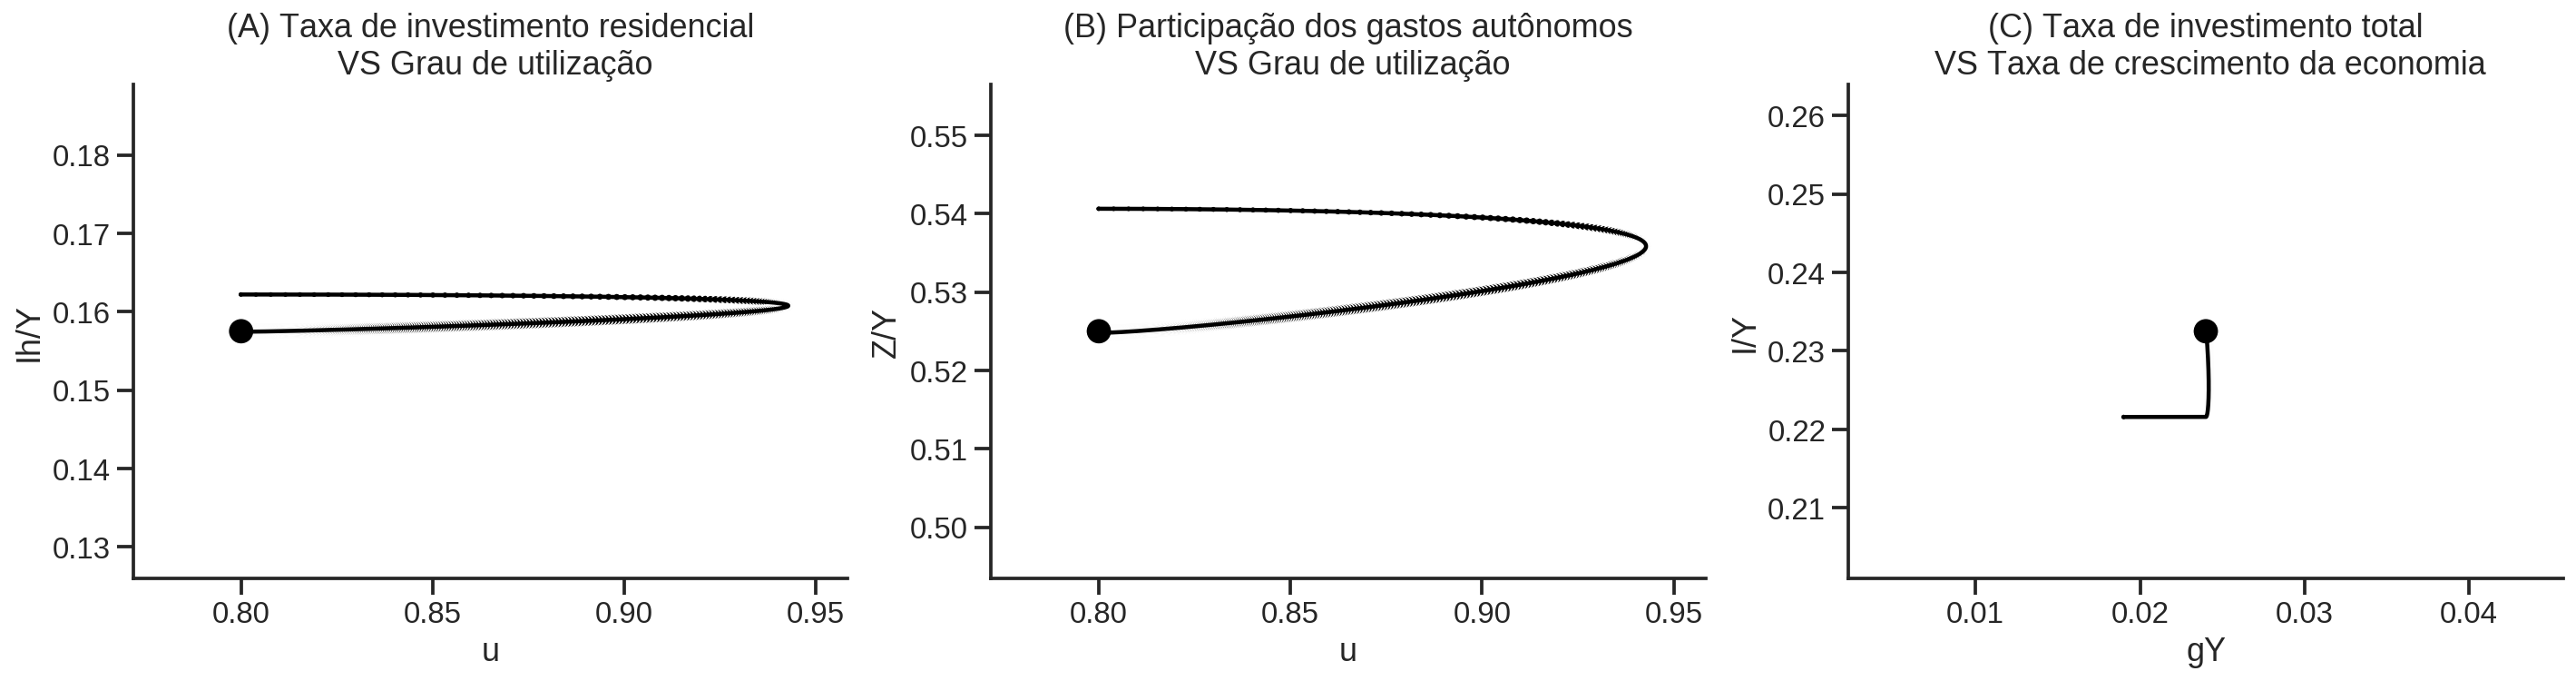

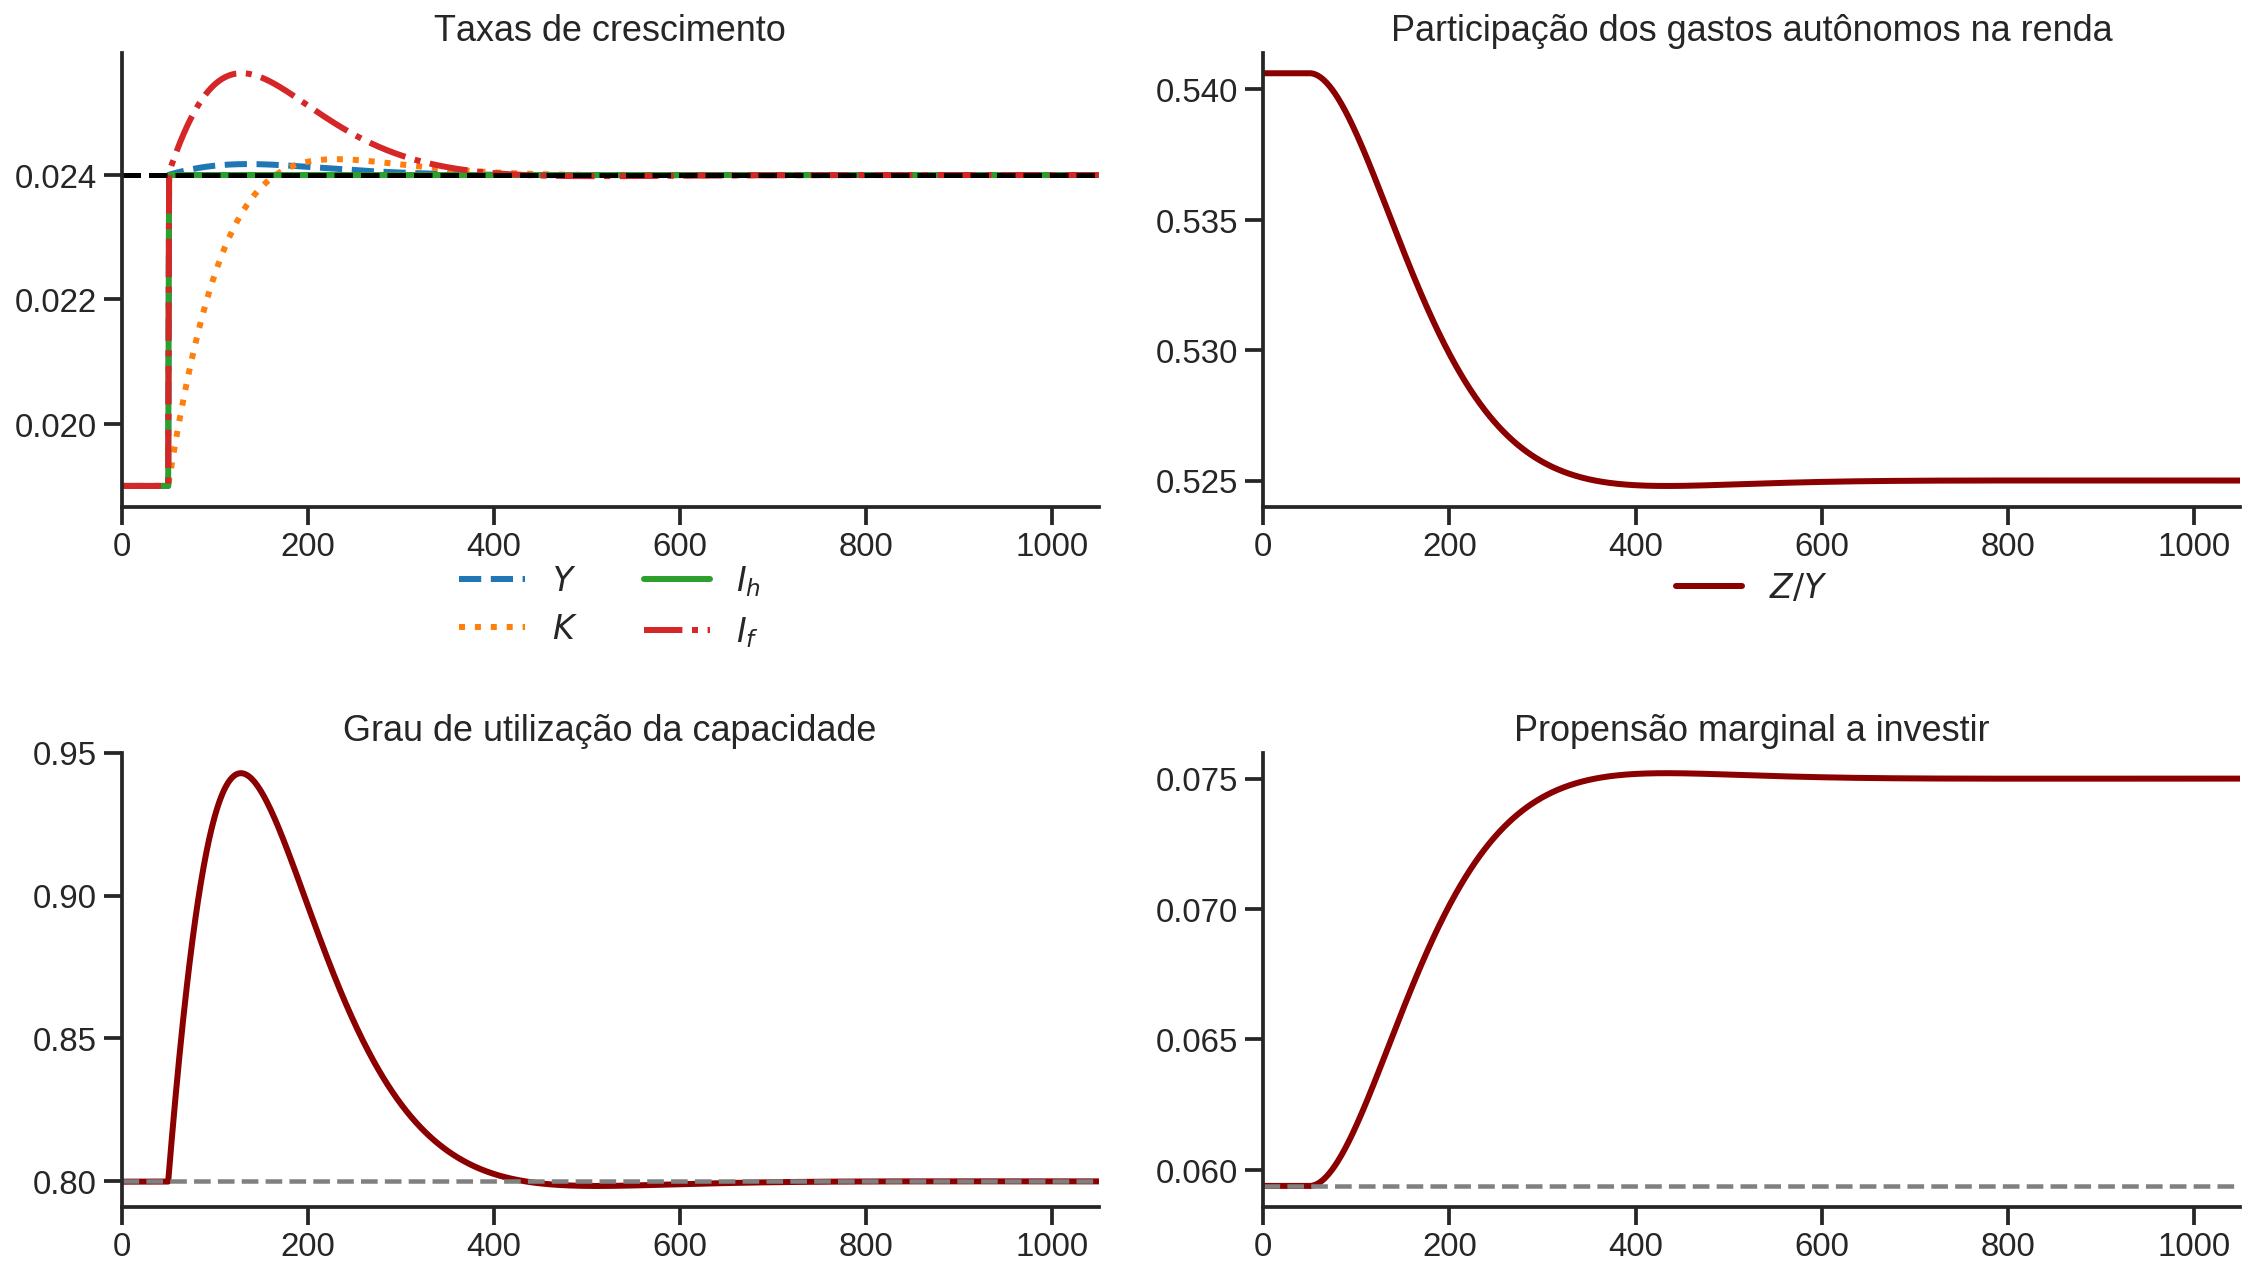

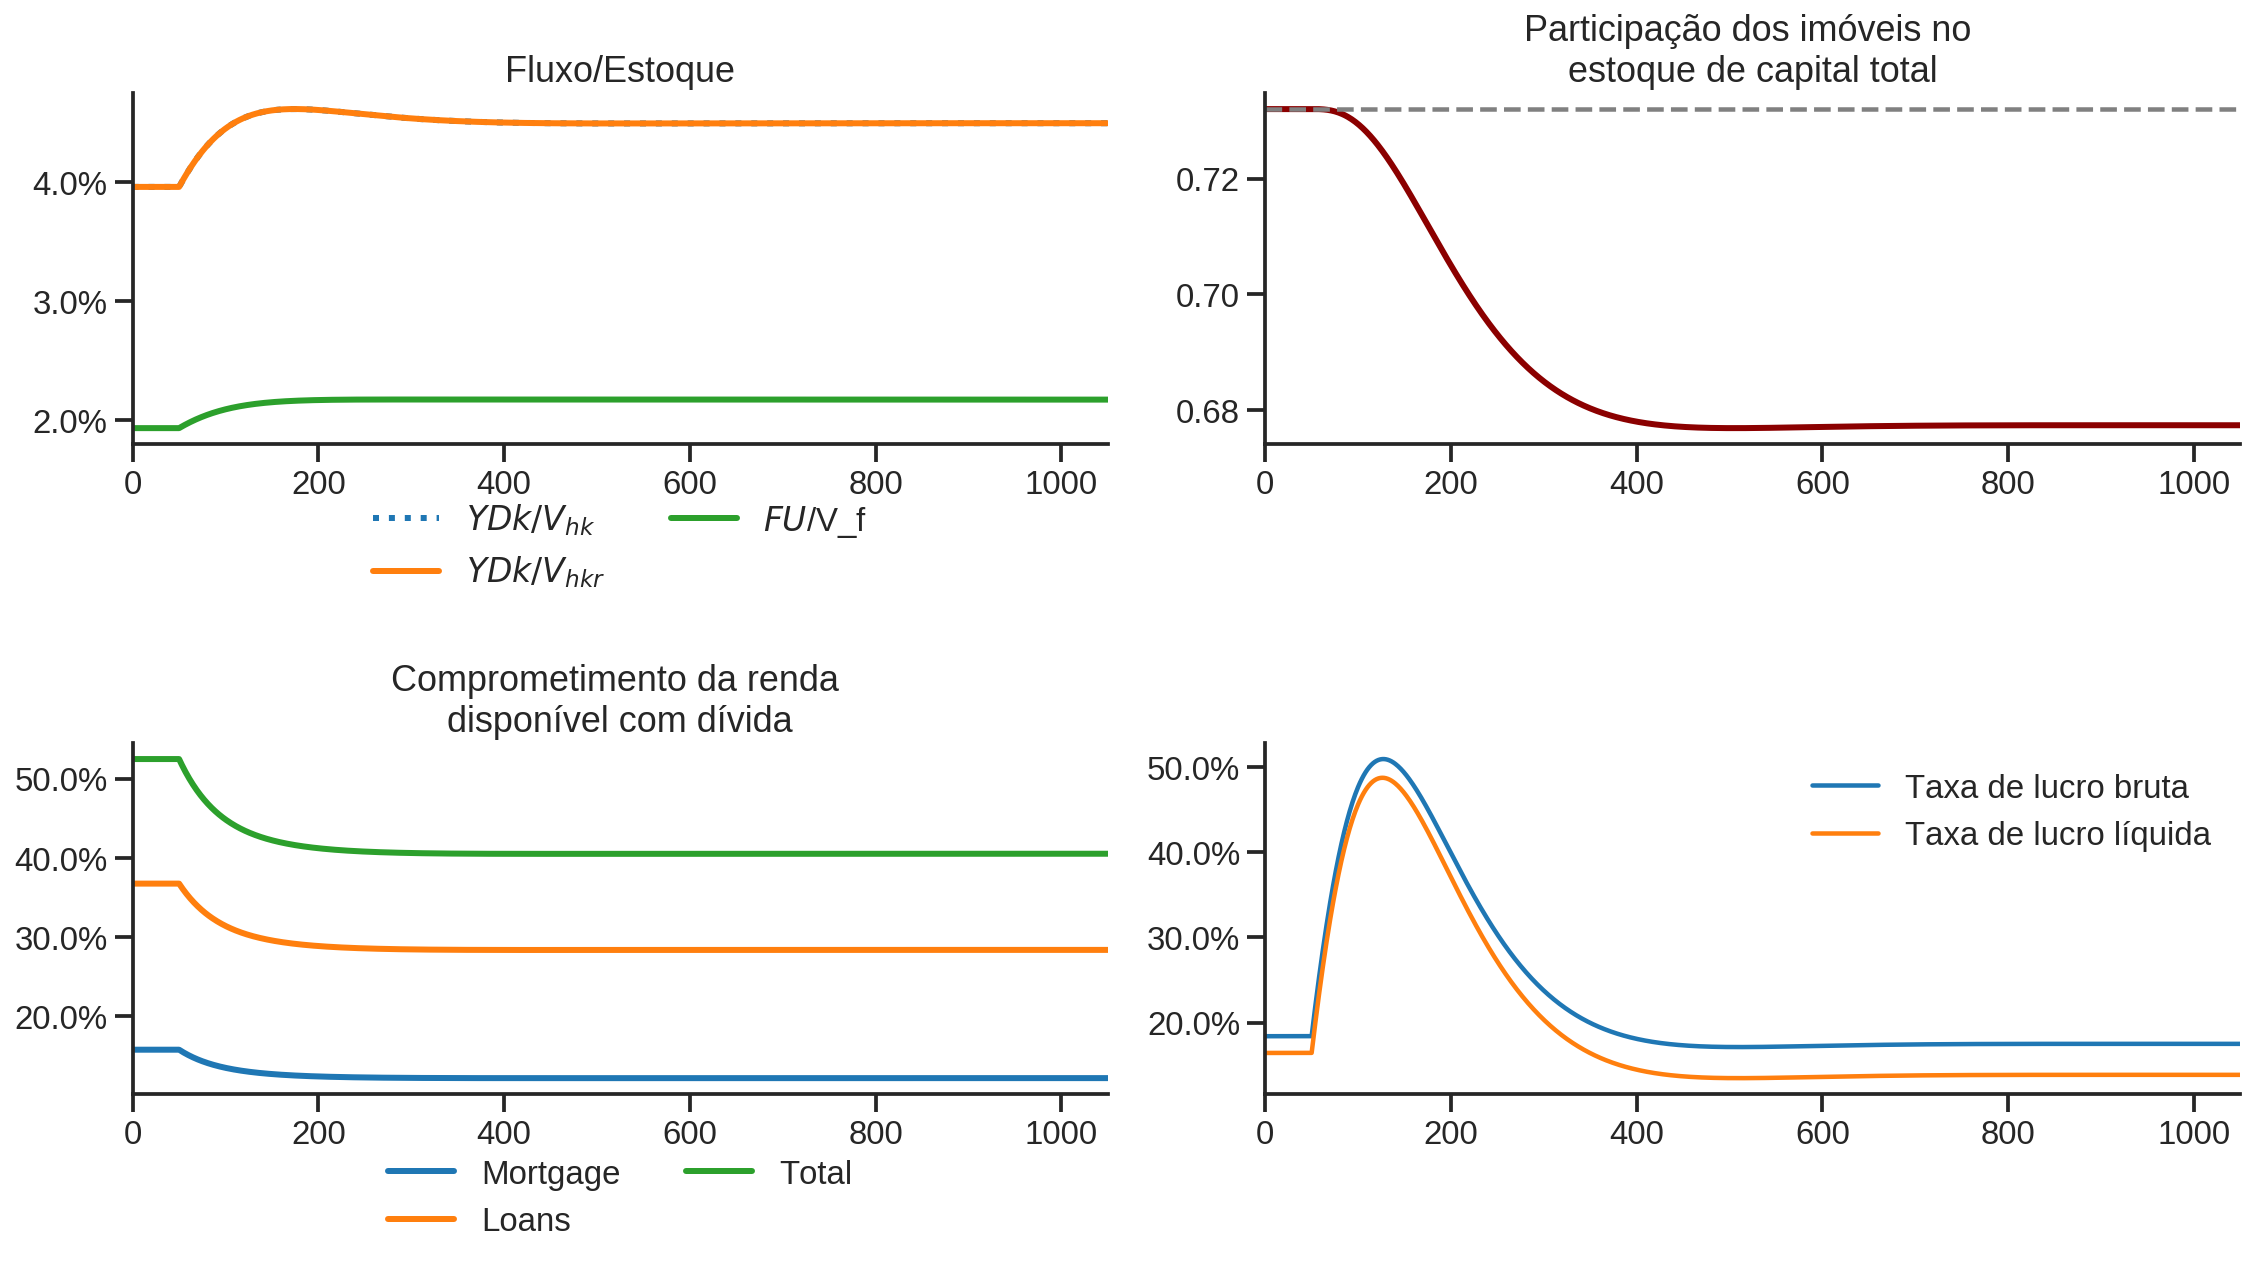

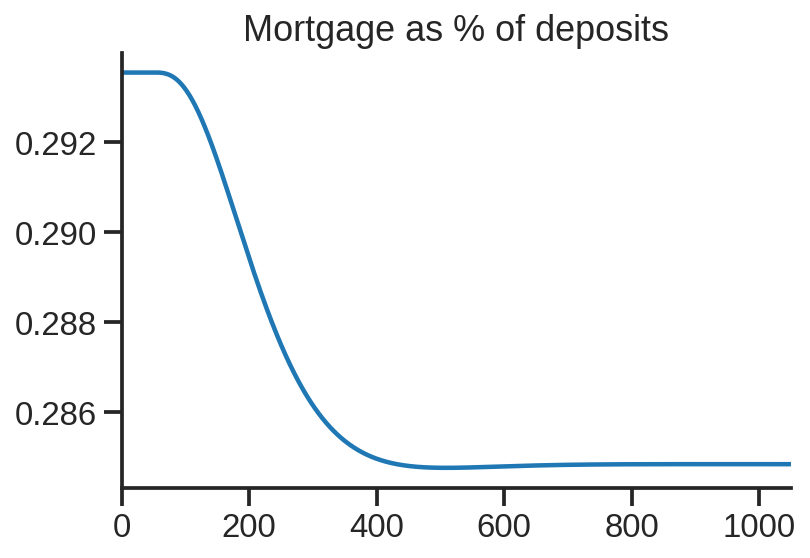

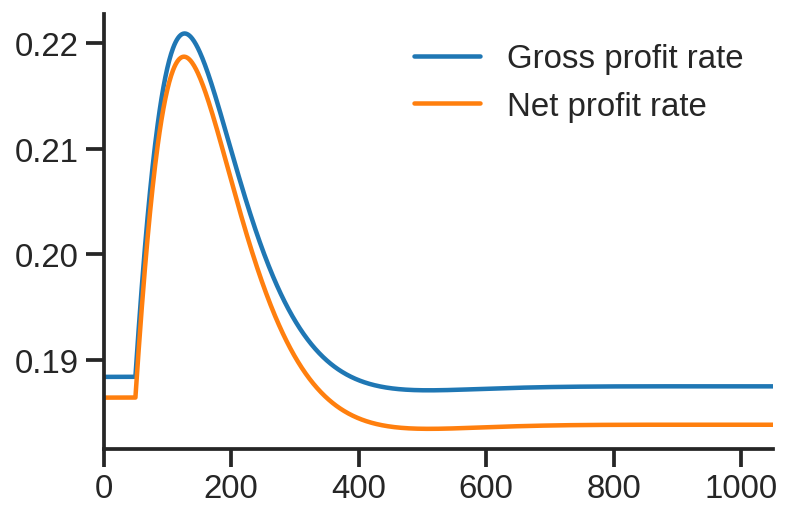

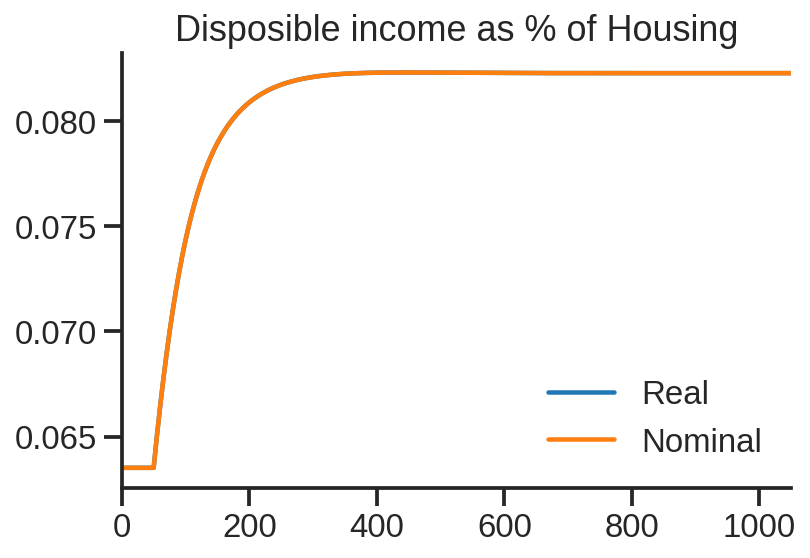

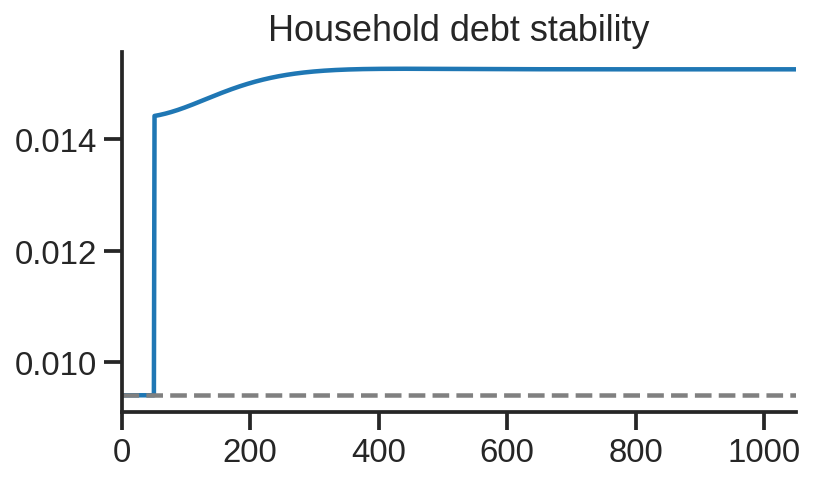

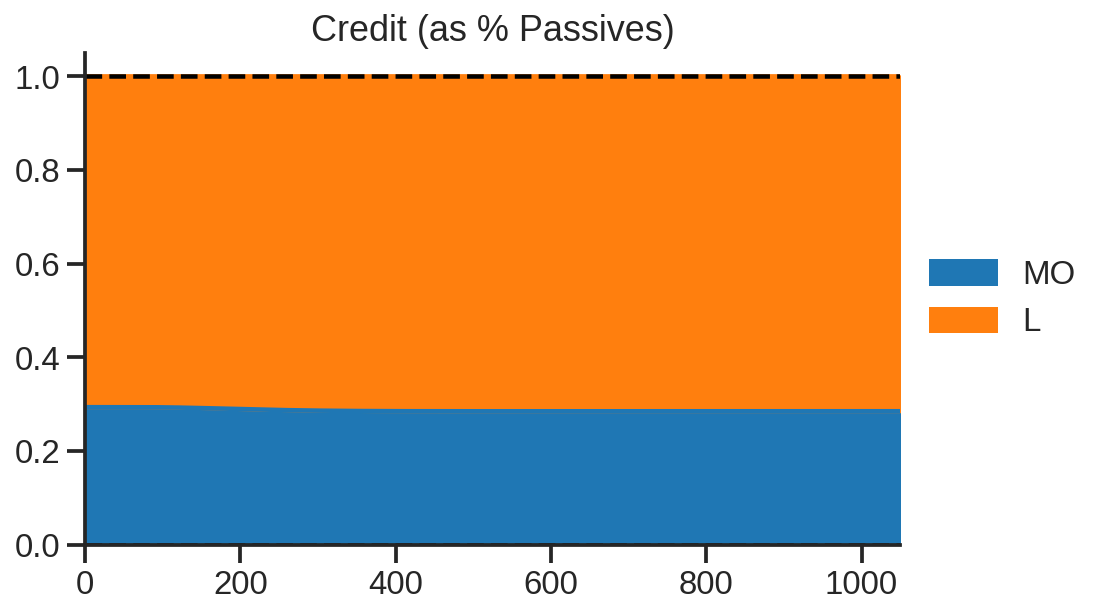

0         Shock             1             2             3  \
C     1.836962e+11  1.881053e+11  1.926207e+11  1.972449e+11  2.019805e+11   
Cw    9.439240e+10  9.665823e+10  9.897887e+10  1.013557e+11  1.037899e+11   
Ck    8.930381e+10  9.144710e+10  9.364183e+10  9.588924e+10  9.819058e+10   
Eq    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
FD    1.289041e+11  1.320052e+11  1.351813e+11  1.384342e+11  1.417658e+11   
...            ...           ...           ...           ...           ...   
TIME  5.100000e+01  5.200000e+01  5.300000e+01  5.400000e+01  5.500000e+01   
Ih/Y  1.621870e-01  1.621864e-01  1.621850e-01  1.621829e-01  1.621802e-01   
I/Y   2.215636e-01  2.215652e-01  2.215684e-01  2.215732e-01  2.215796e-01   
Z/Y   5.406235e-01  5.406212e-01  5.406166e-01  5.406097e-01  5.406006e-01   
gY    1.899994e-02  2.400435e-02  2.400872e-02  2.401302e-02  2.401726e-02   

               t-1             t    difference  
C     3.633688e+21  3.720896e+21  8.720852e+19  
Cw    1.893778e+21  1.939229e+21  4.545069e+19  
Ck    1.739910e+21  1.781667e+21  4.175783e+19  
Eq    0.000000e+00  0.000000e+00  0.000000e+00  
FD    2.562724e+21  2.624229e+21  6.150538e+19  
...            ...           ...           ...  
TIME  1.050000e+03  1.051000e+03  1.000000e+00  
Ih/Y  1.575001e-01  1.575001e-01 -1.418388e-09  
I/Y   2.324998e-01  2.324998e-01  3.309571e-09  
Z/Y   5.250003e-01  5.250002e-01 -4.727959e-09  
gY    2.400001e-02  2.400001e-02 -1.158260e-10  

[82 rows x 8 columns]

In [13]:
base = model()
df = SolveSFC(base, time=1000)
shock = ShockModel(base_model=base, create_function=model(), variable='phi_0', increase=0.005, time = 1000)
clock_plots(shock = shock, filename = 'Clock_1.png', variable='g_Z')
plot_shock(shock = shock, filename = 'Shock_1.png')
plot_norms(shock = shock, filename = 'Shock_1Norms.png')
other_plots(shock)

df1 = shock

shock1 = shock.round(decimals = 5).tail(1).transpose().loc['alpha':,:]
shock1.columns = ['$\Delta \phi_0$']

summary = SummaryShock(shock)
summary

## Decrease in wage-share ($\omega$)

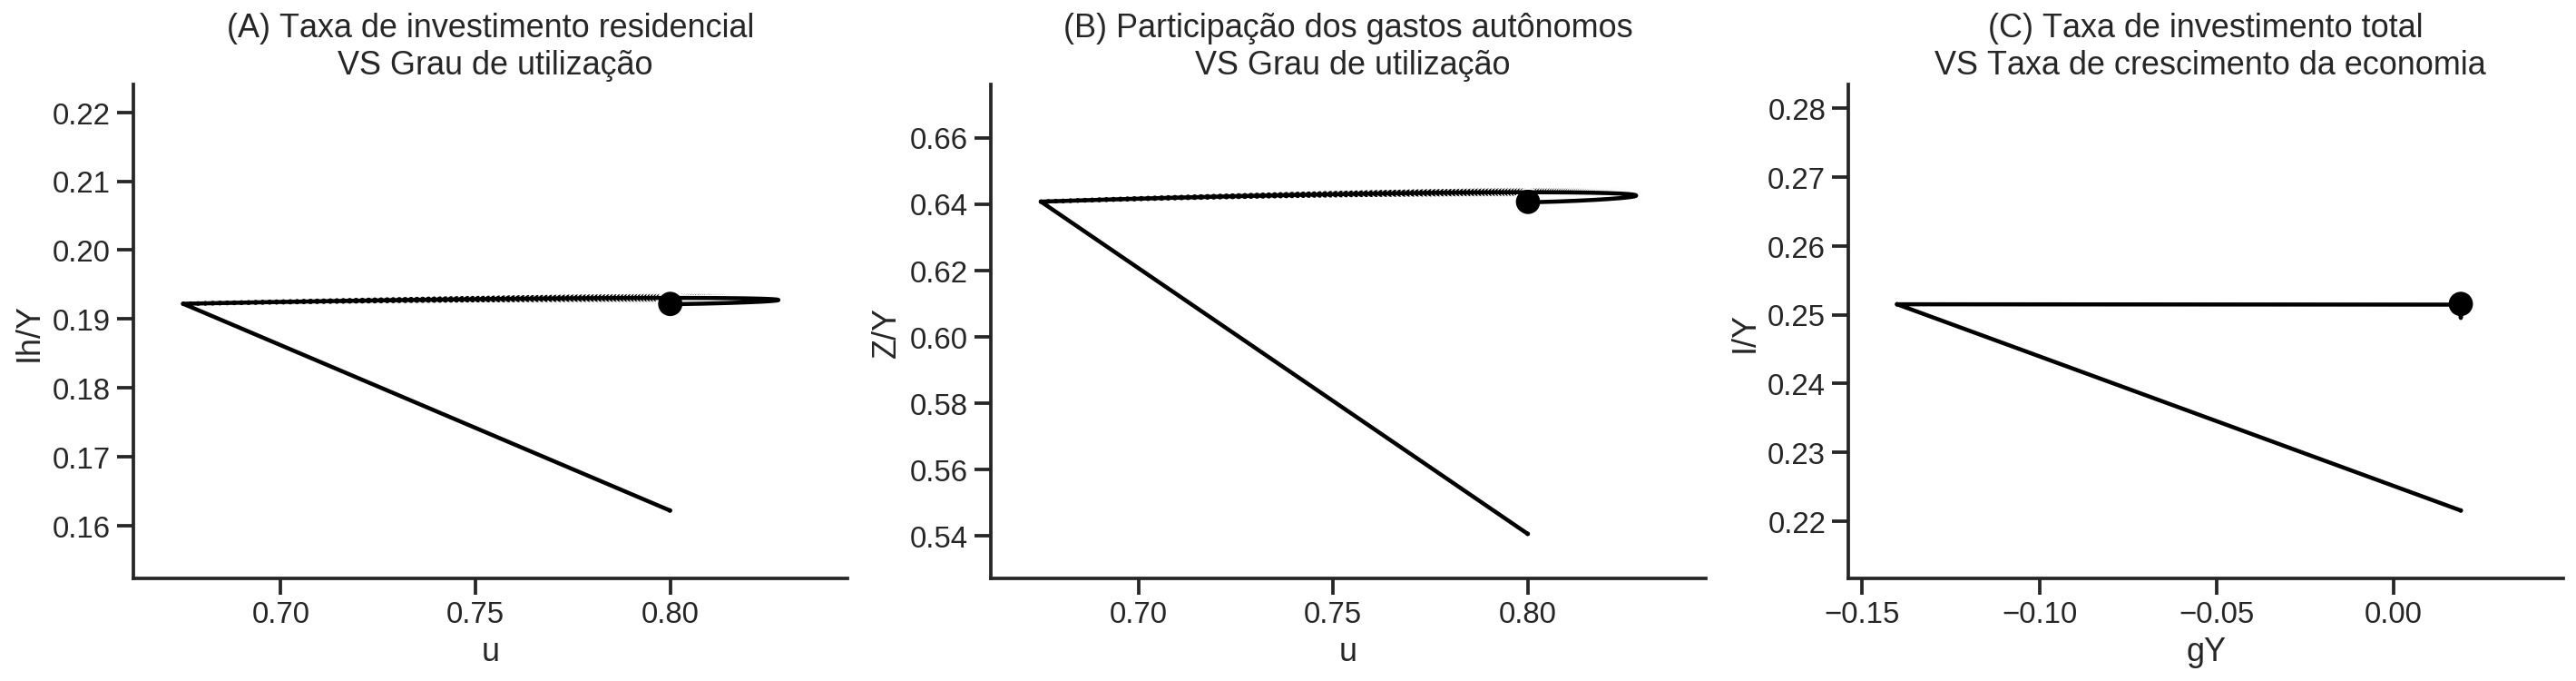

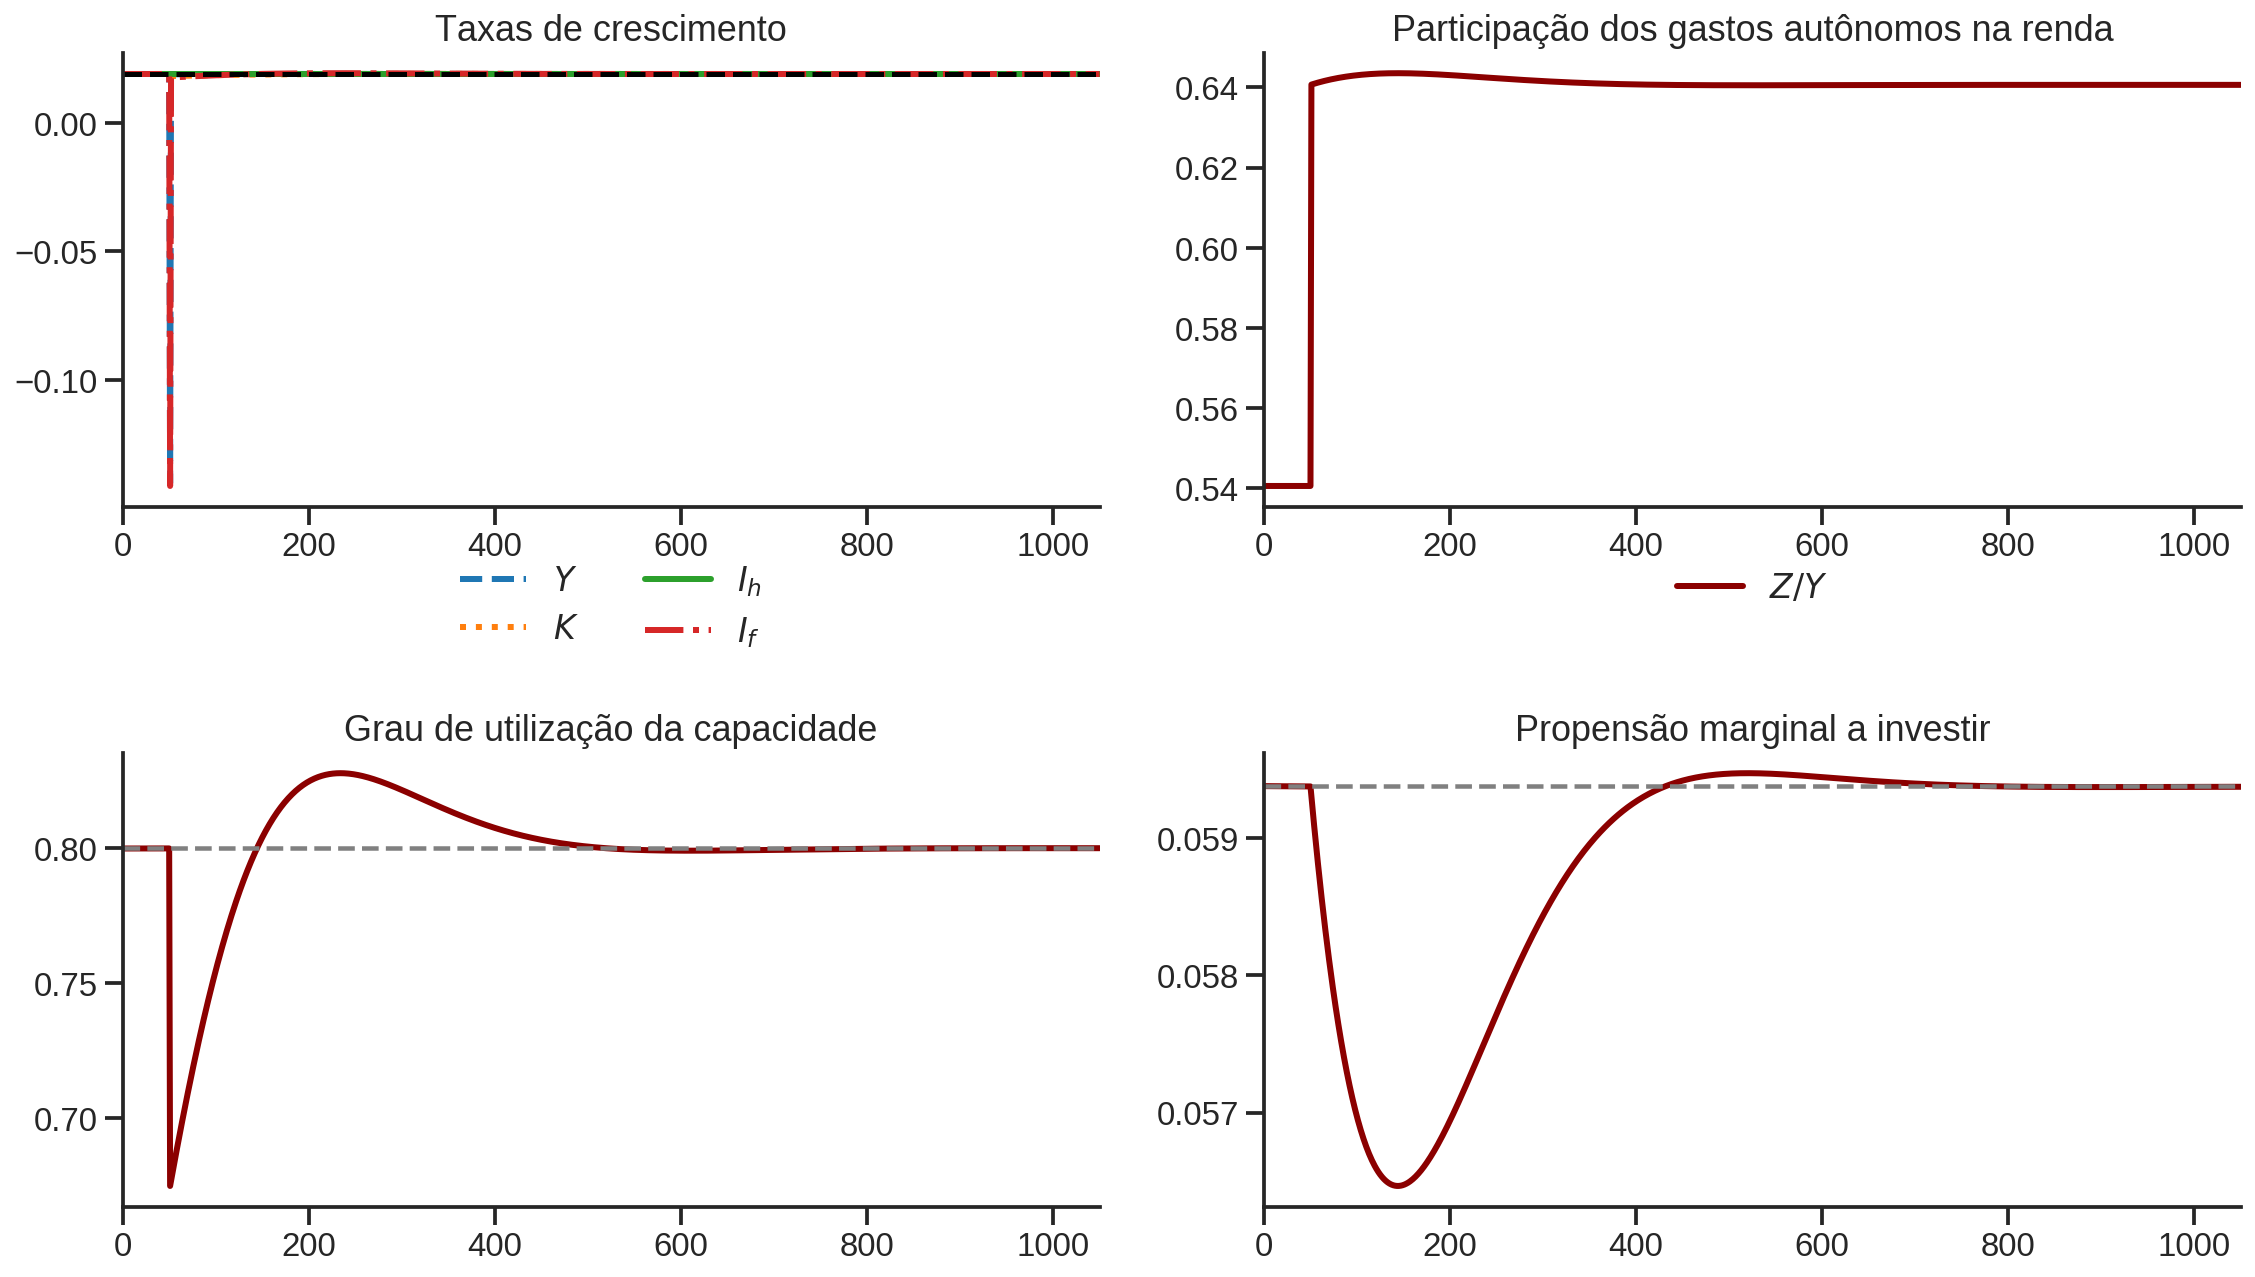

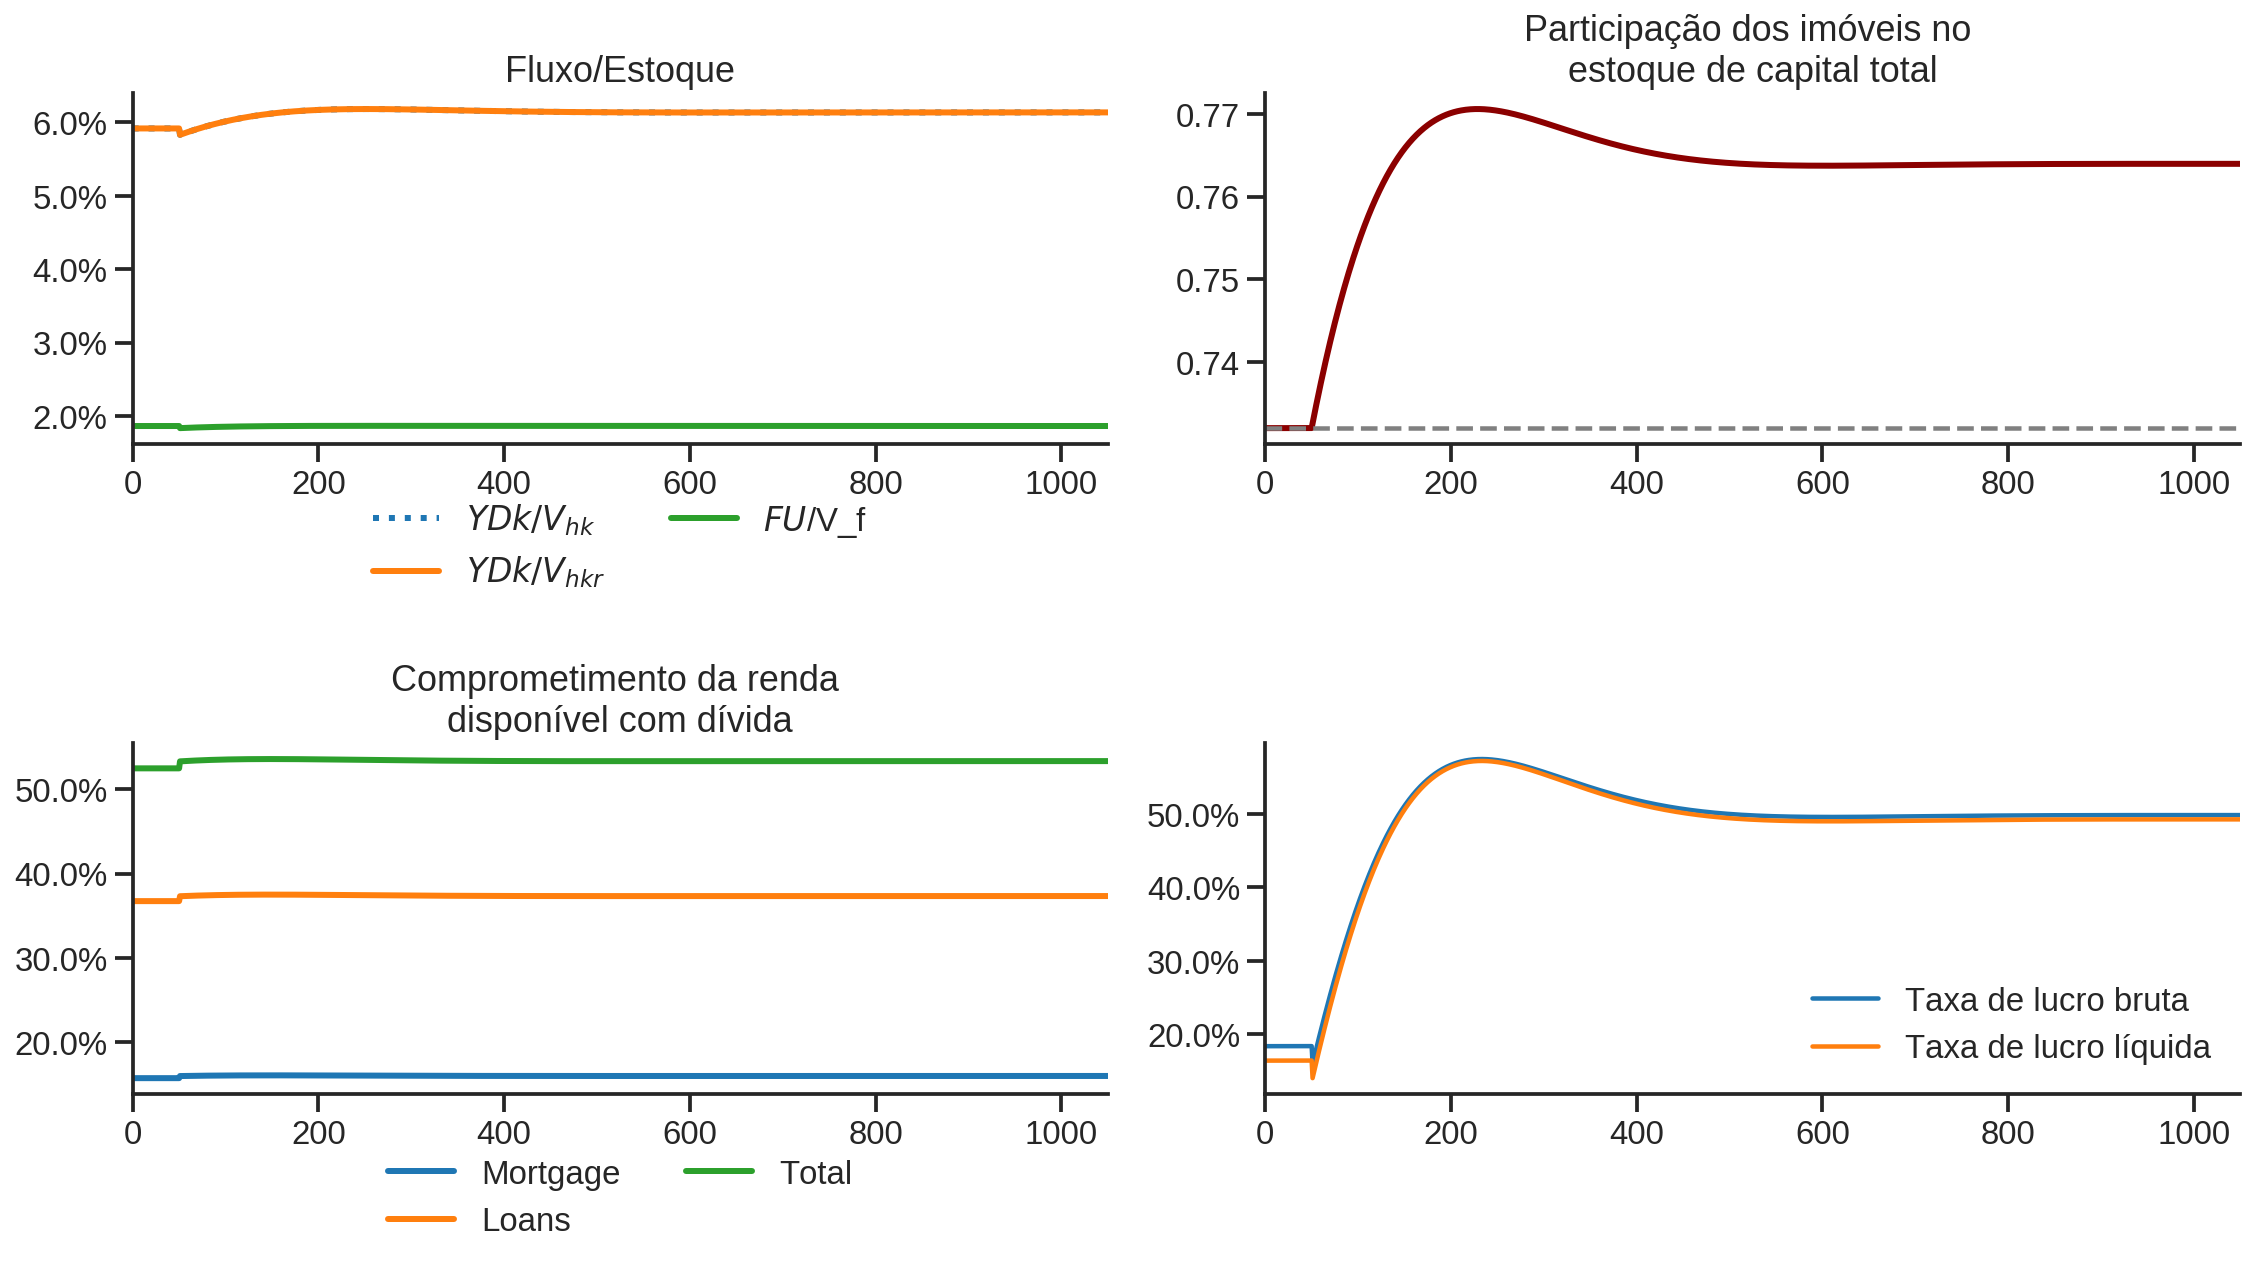

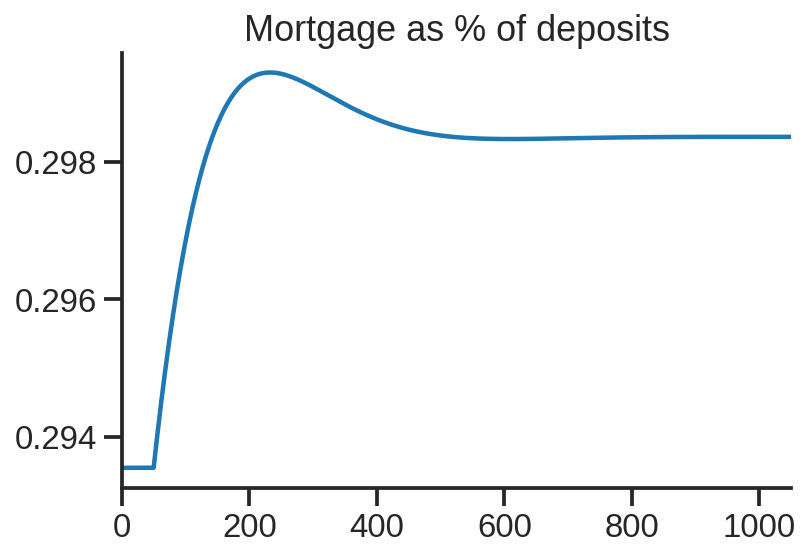

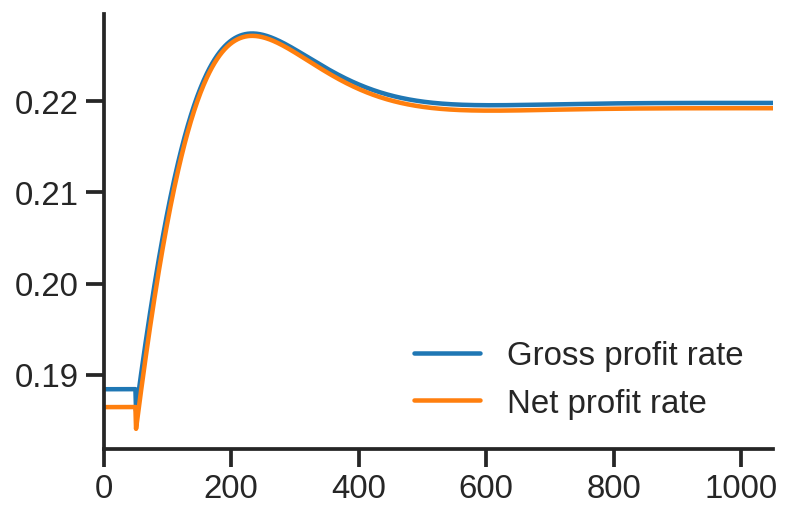

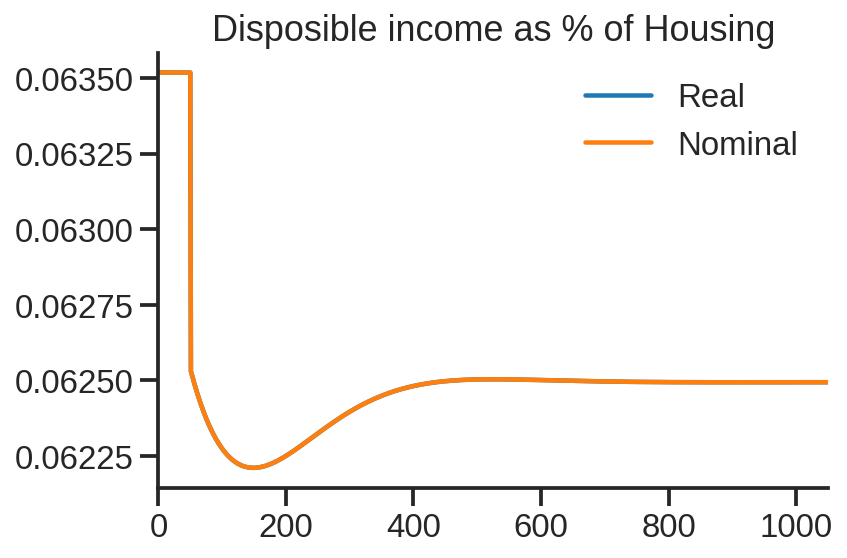

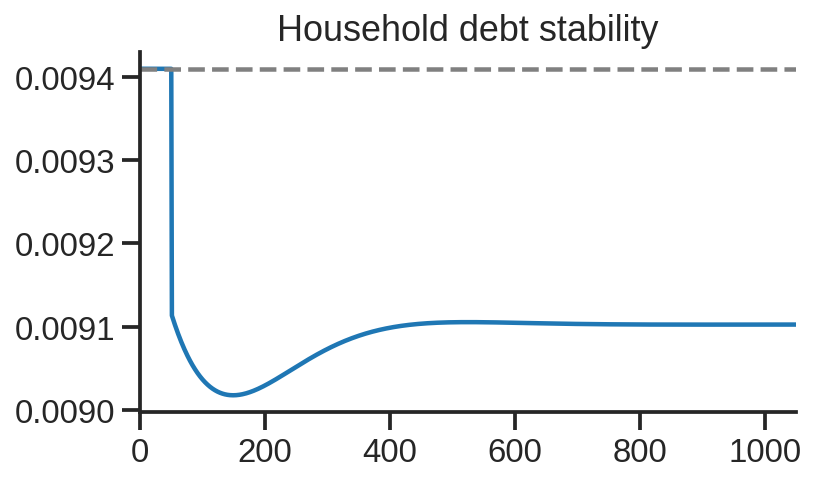

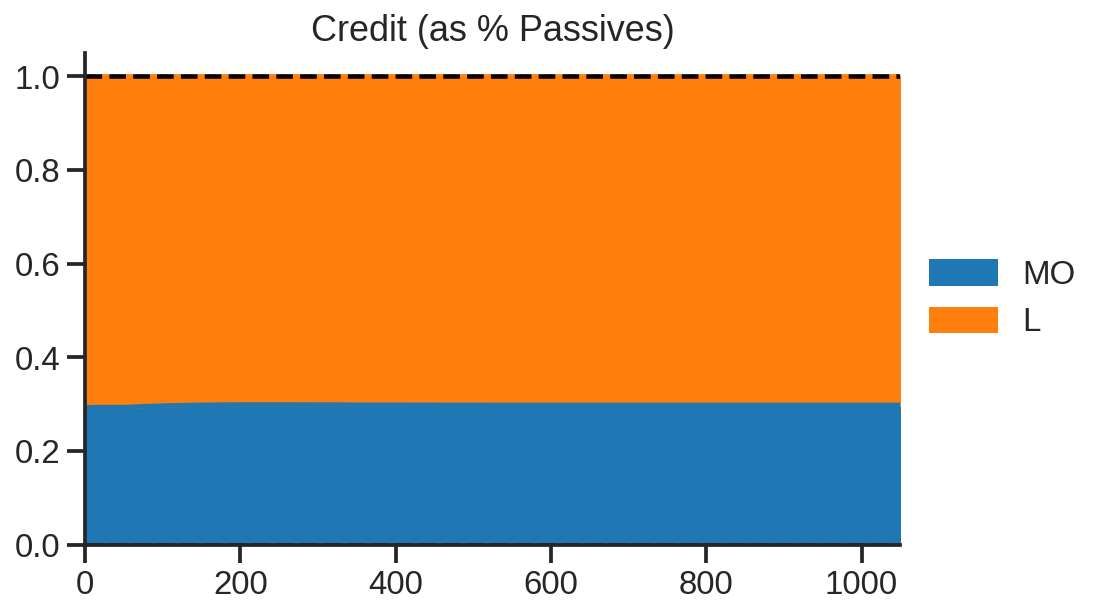

In [81]:
base = model()
df = SolveSFC(base, time=1000)
shock = ShockModel(base_model=base, create_function=model(), variable='omega', increase=-0.1, time = 1000)
clock_plots(shock = shock, filename = 'Clock_2.png', variable='omega')
plot_shock(shock = shock, filename = 'Shock_2.png')
plot_norms(shock = shock, filename = 'Shock_2Norms.png')
other_plots(shock)

df2 = shock

shock2 = shock.round(decimals = 3).tail(1).transpose().loc['alpha':,:]
shock2.columns = ['$\Delta \omega$']

## Increase in mortgage rates

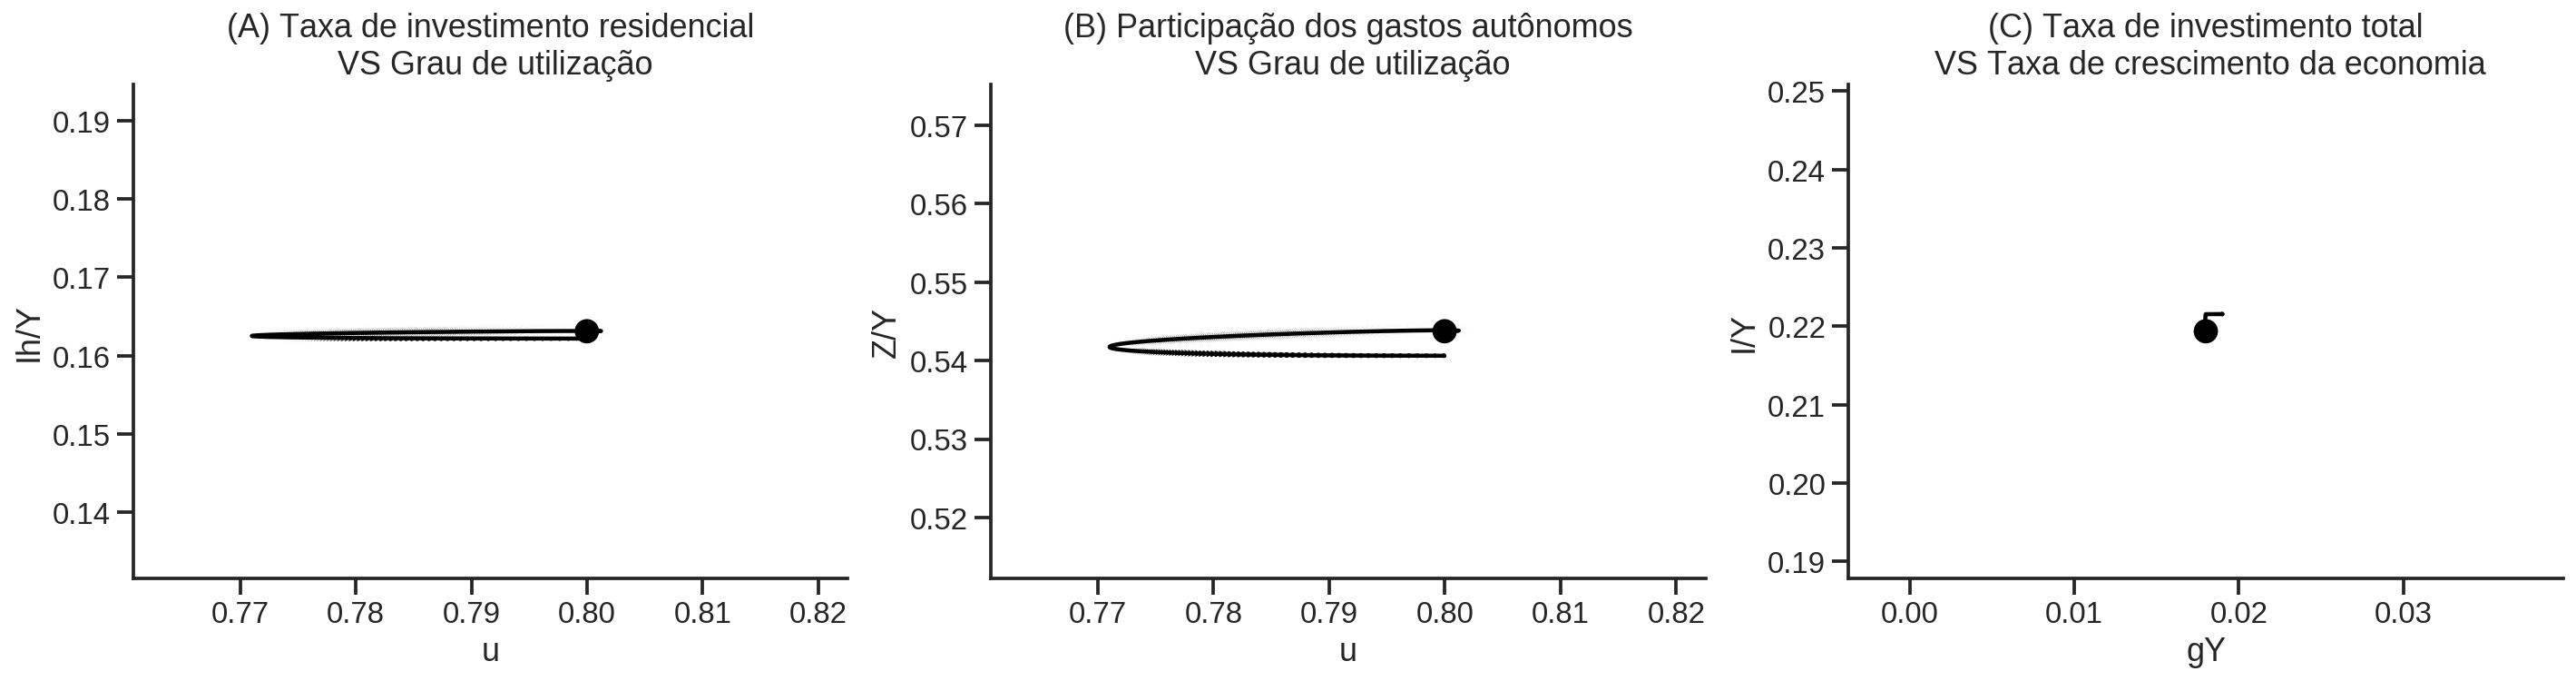

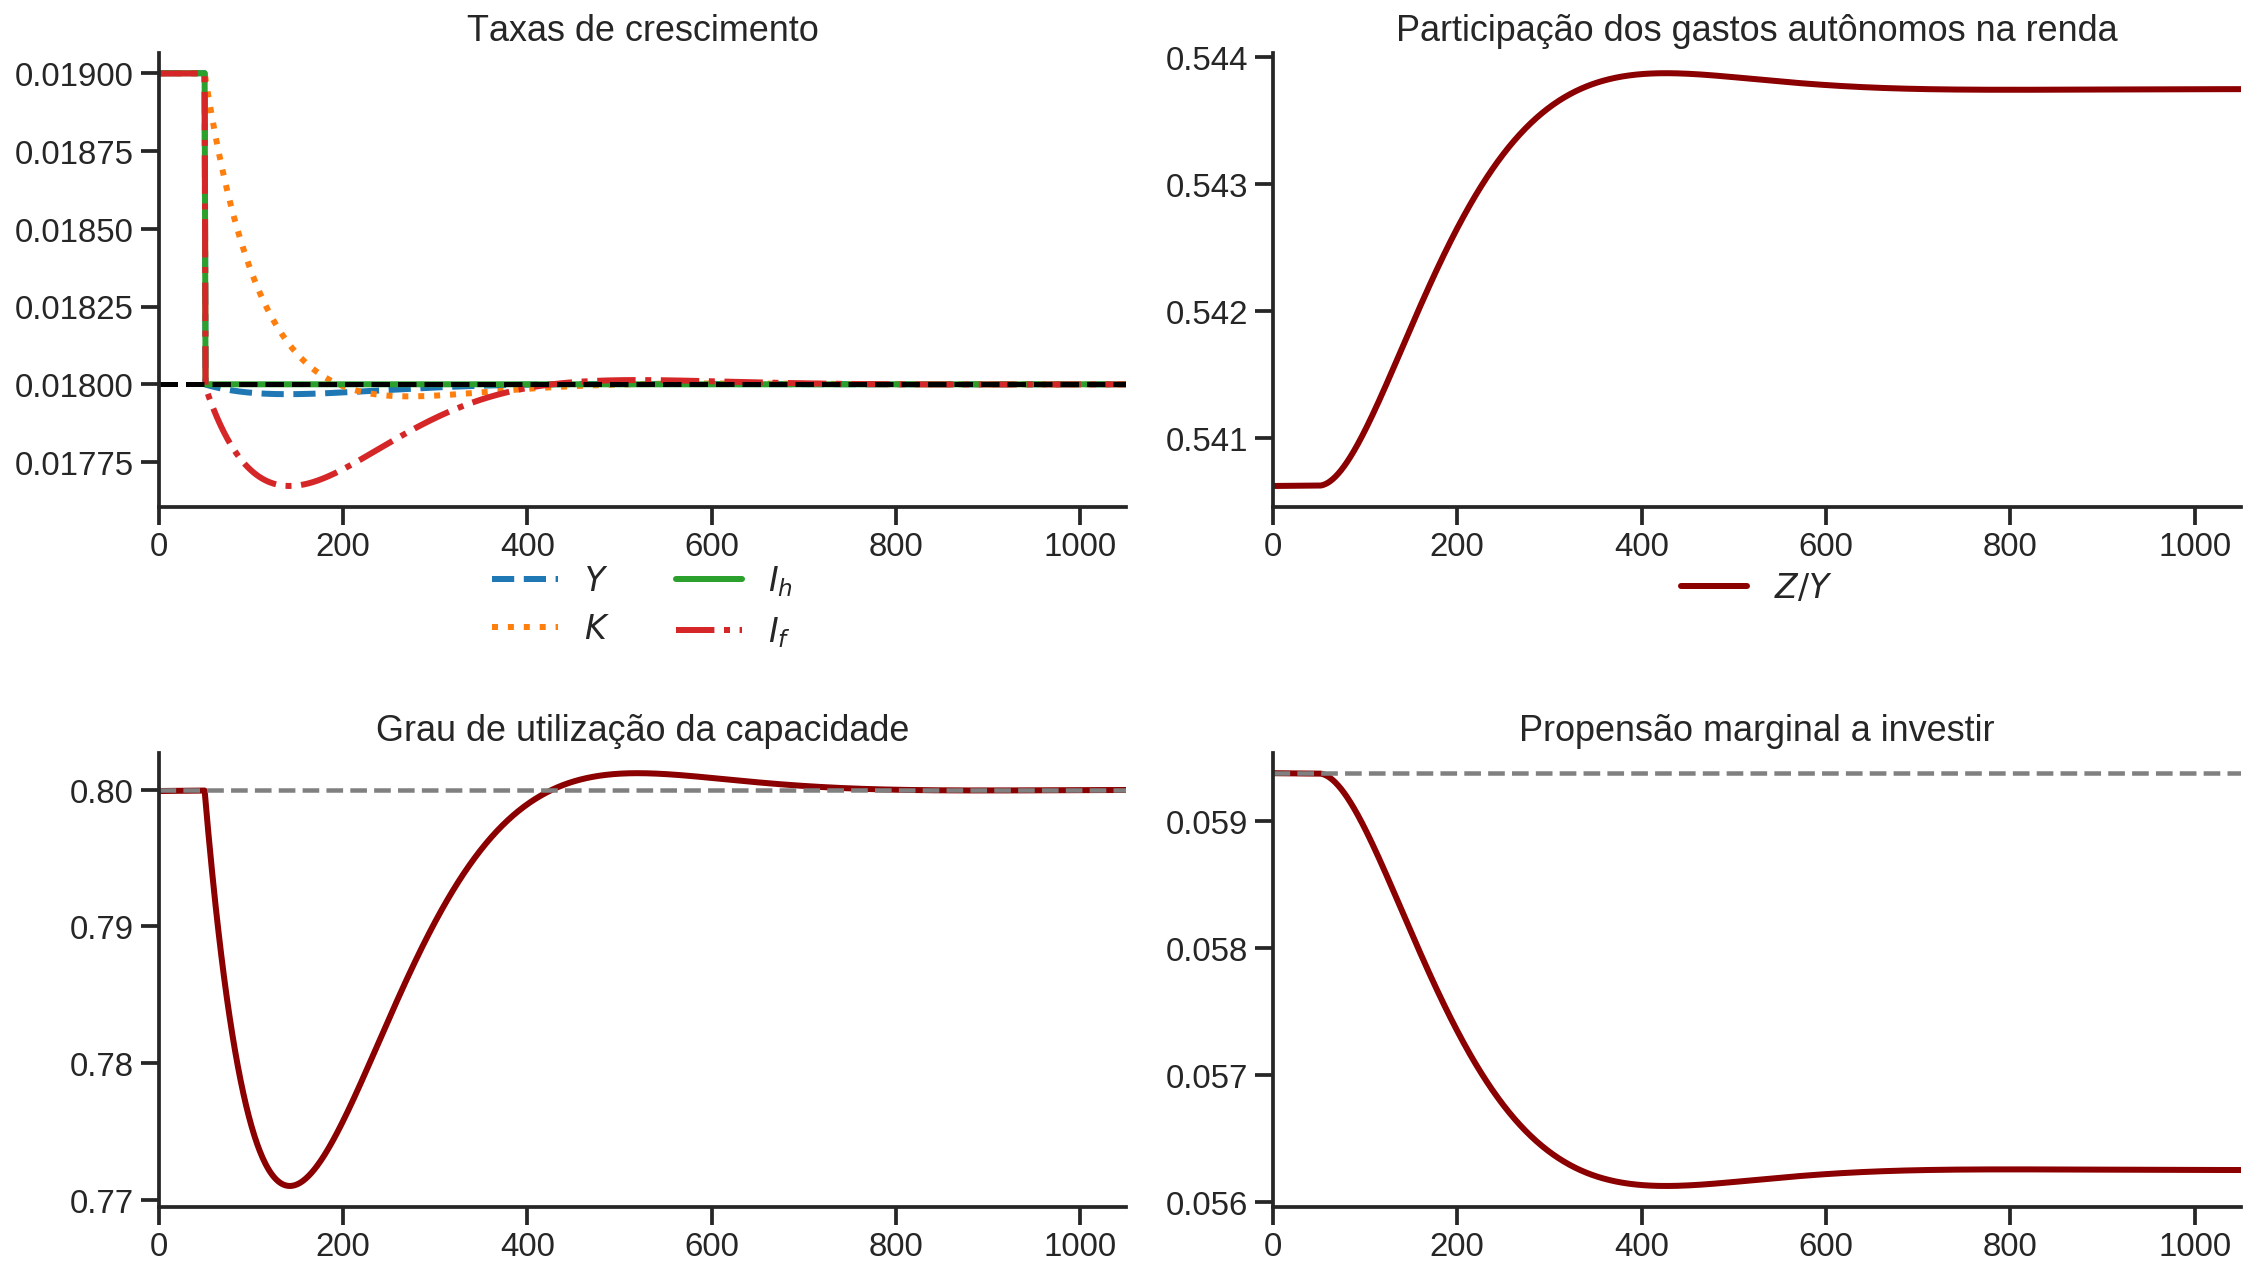

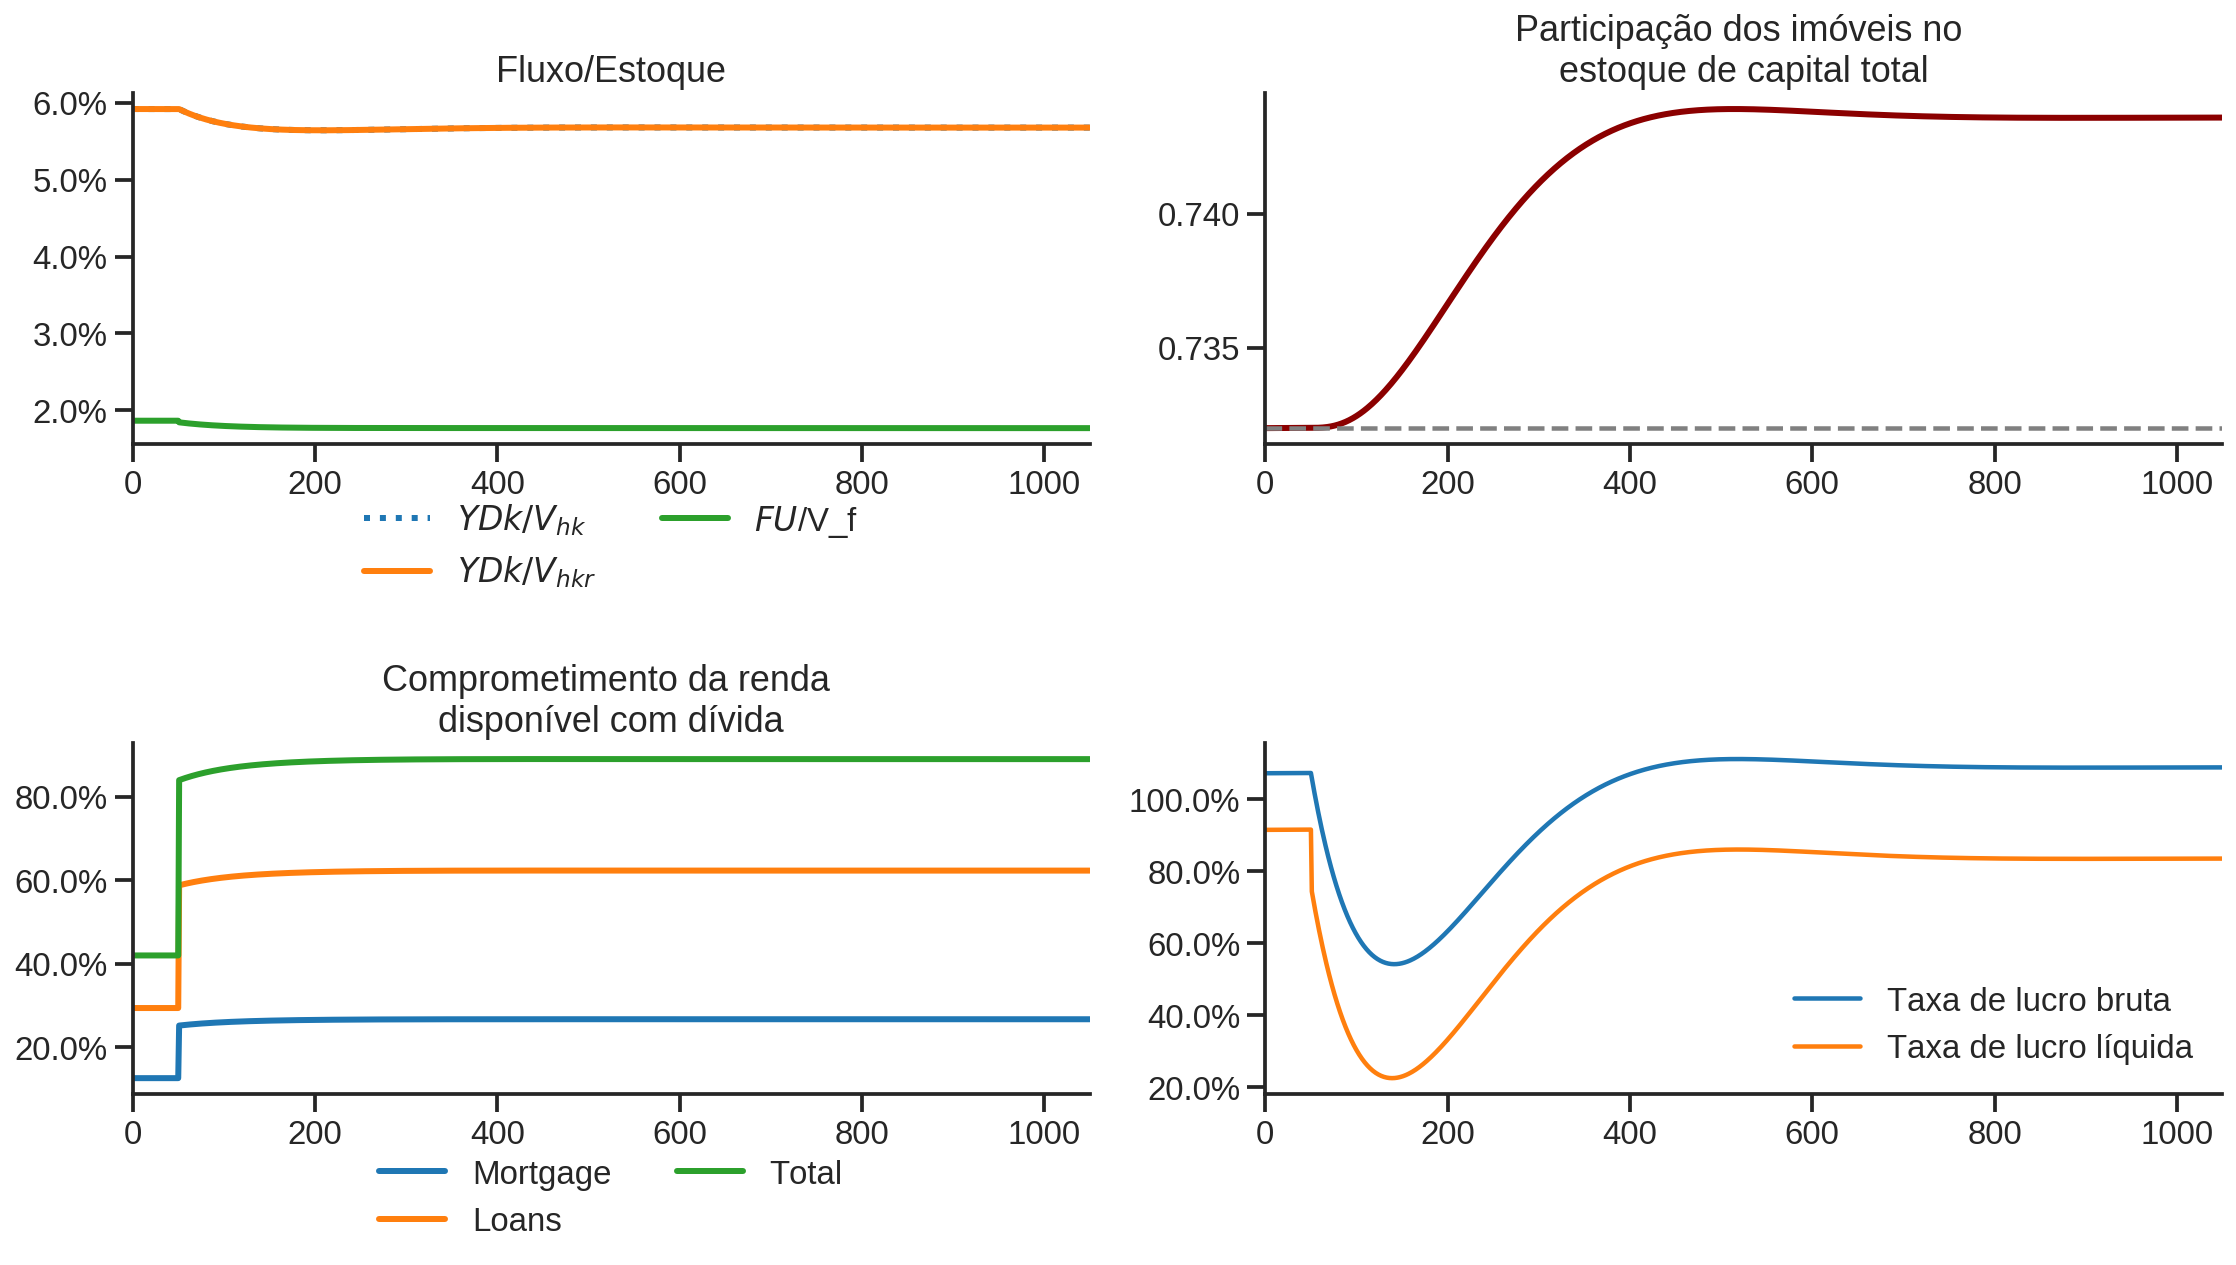

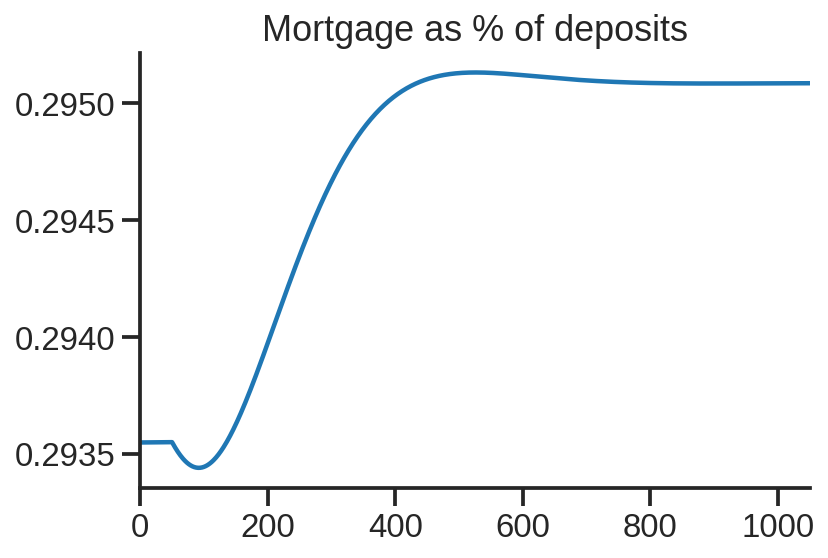

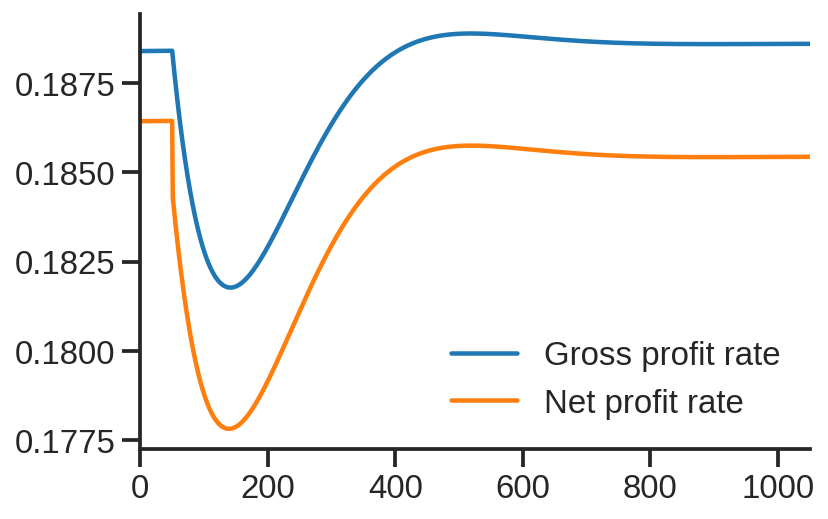

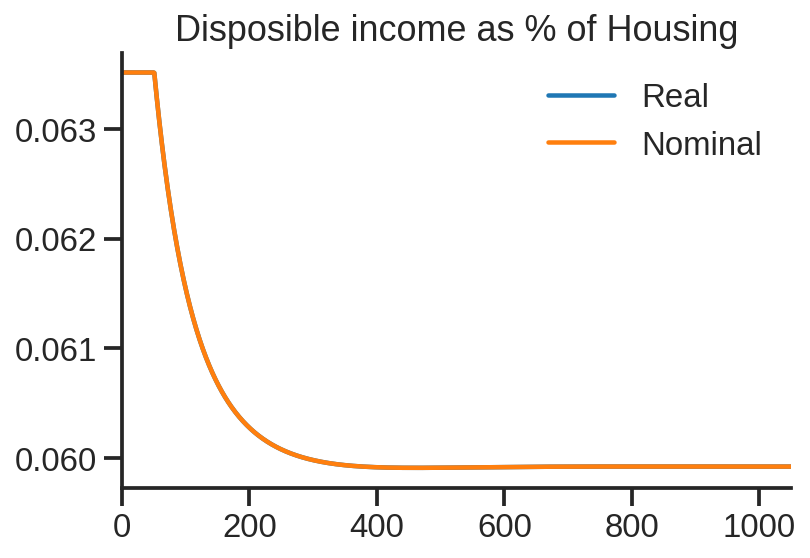

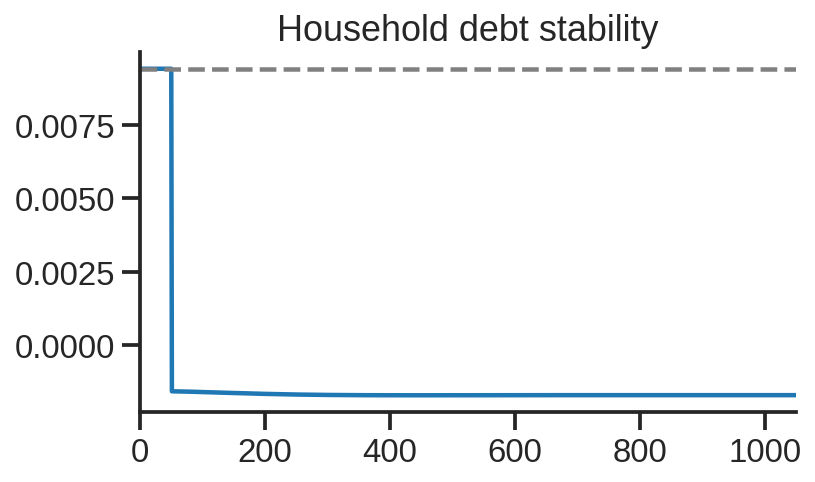

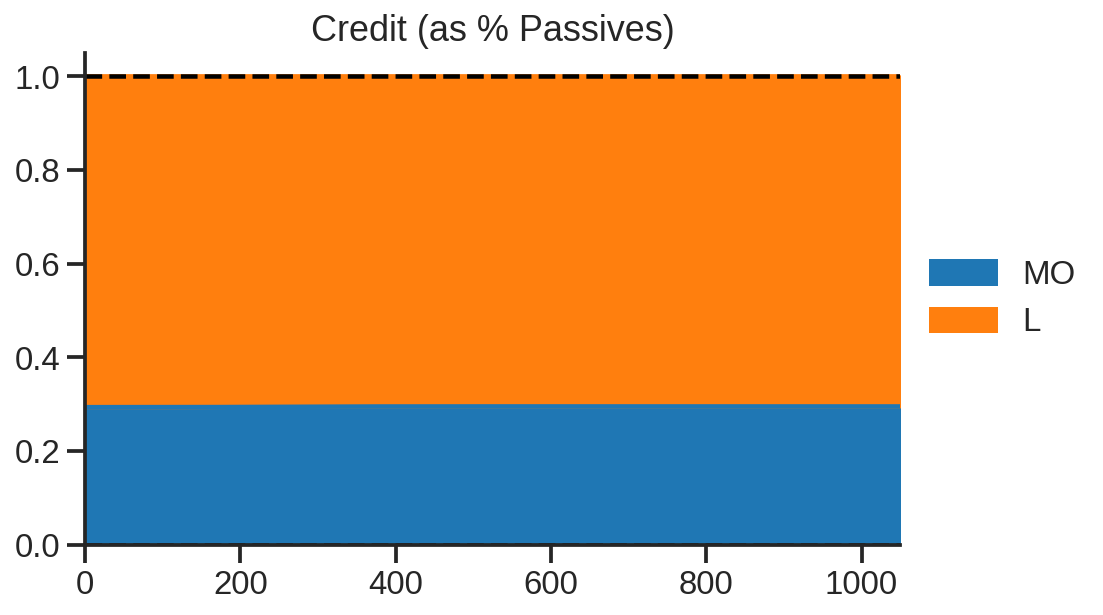

In [15]:
base = model()
df = SolveSFC(base, time=1000)
shock = ShockModel(base_model=base, create_function=model(), variable='rm', increase=0.01, time = 1000)
shock3 = shock.round(decimals = 3).tail(1).transpose().loc['alpha':,:]
shock3.columns = ['$\Delta rm$']
clock_plots(shock = shock, filename = 'Clock_3.png', variable='rmo')
plot_shock(shock = shock, filename = 'Shock_3.png')
plot_norms(shock = shock, filename = 'Shock_3Norms.png')
other_plots(shock)

df3 = shock

## Increase in inflation

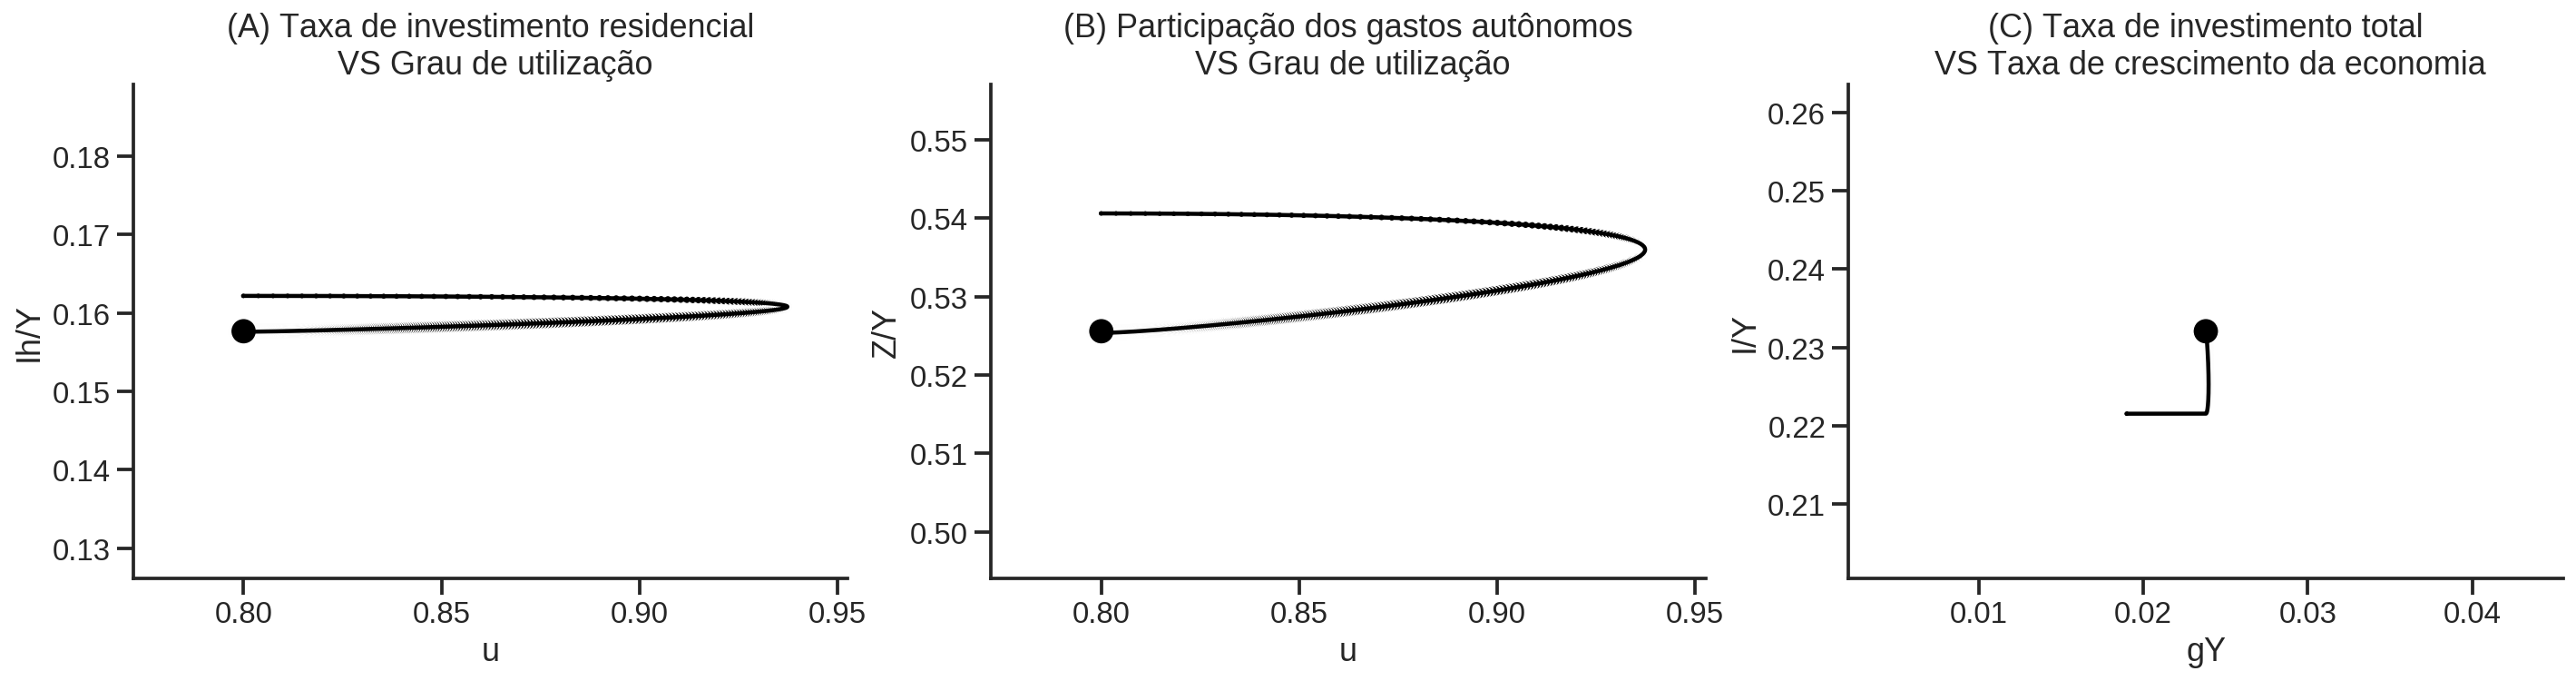

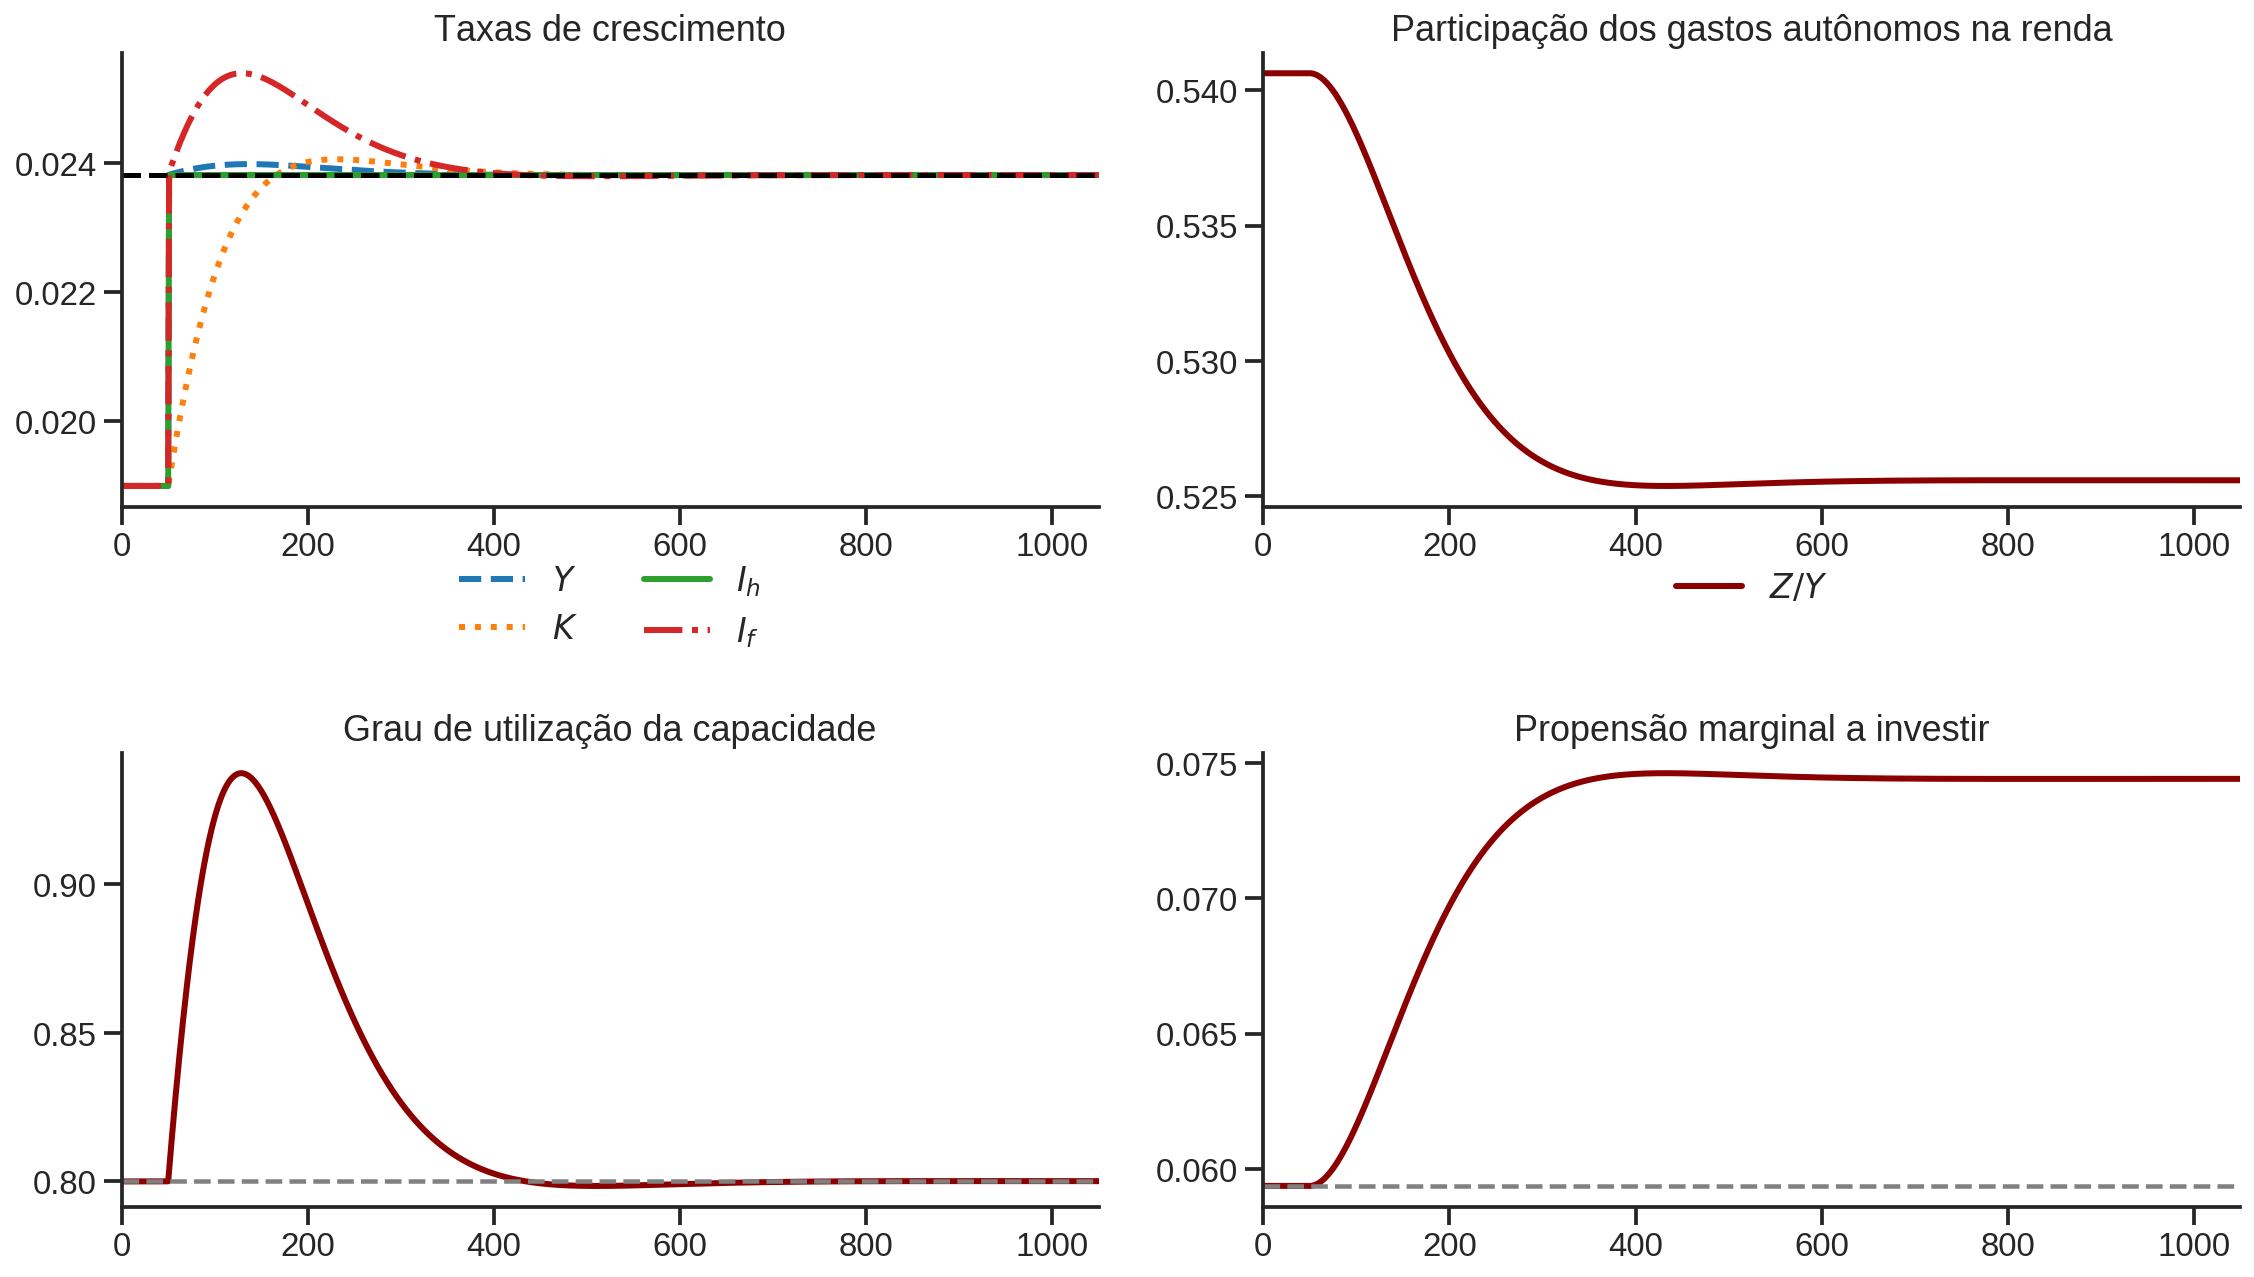

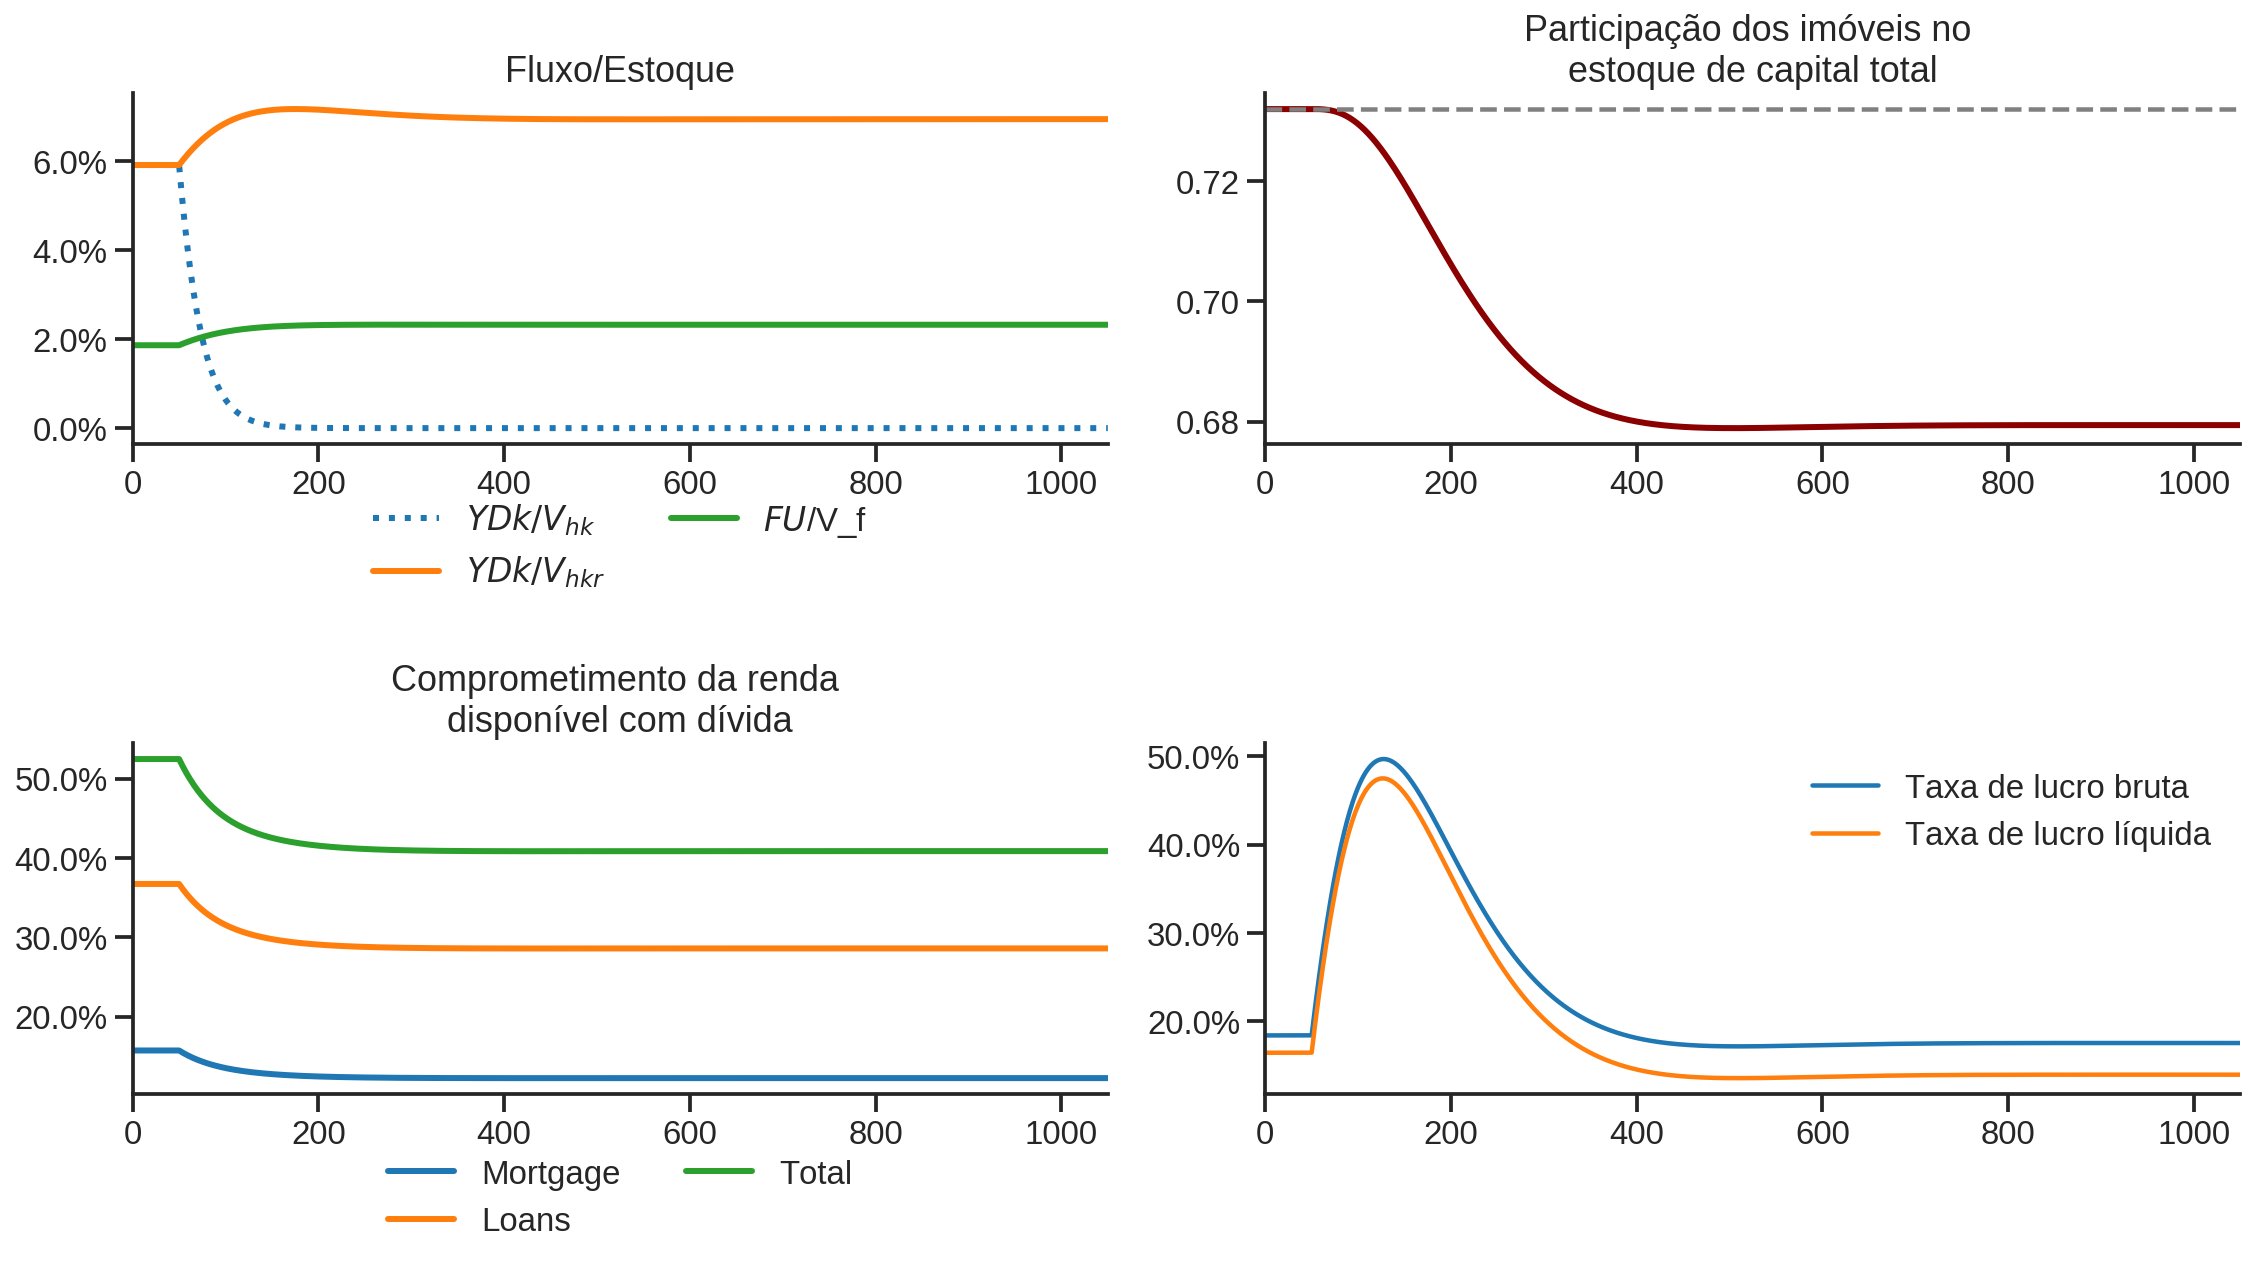

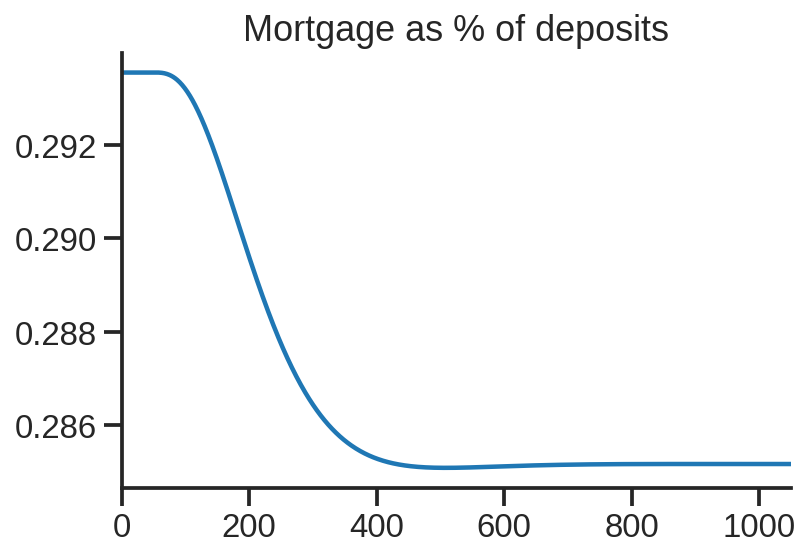

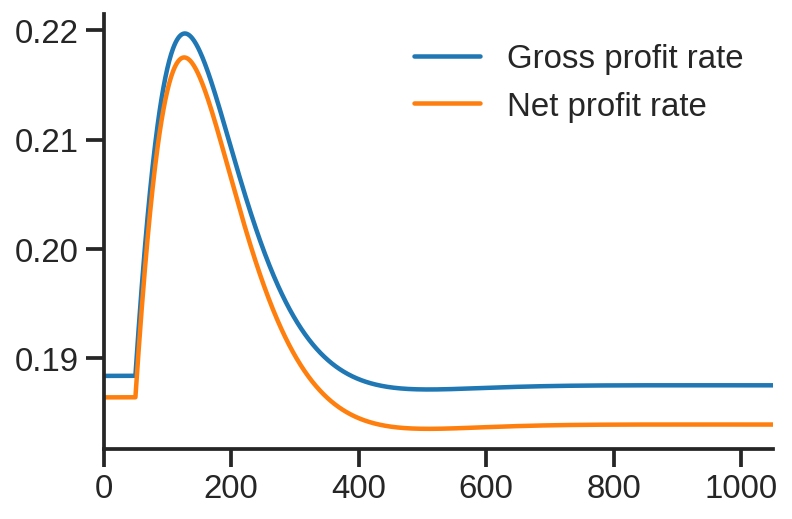

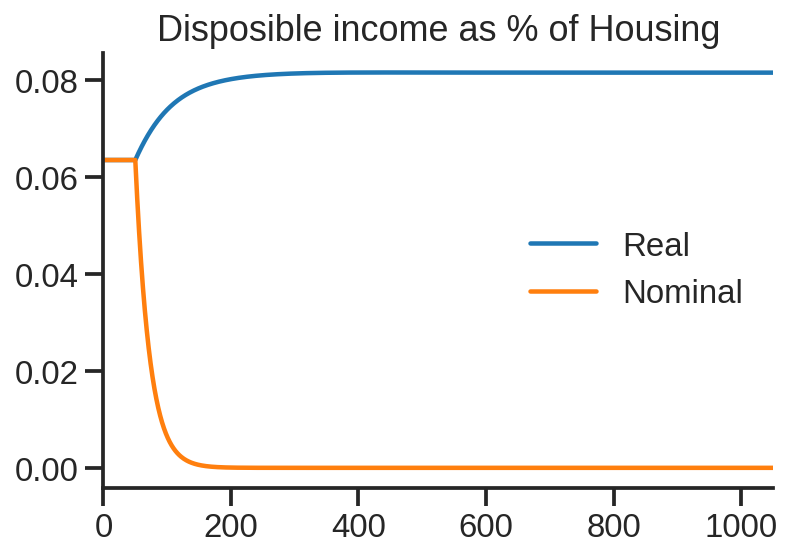

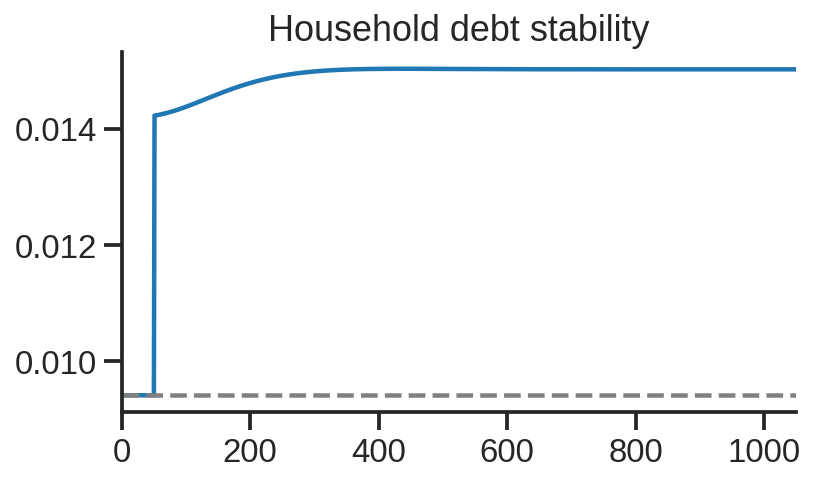

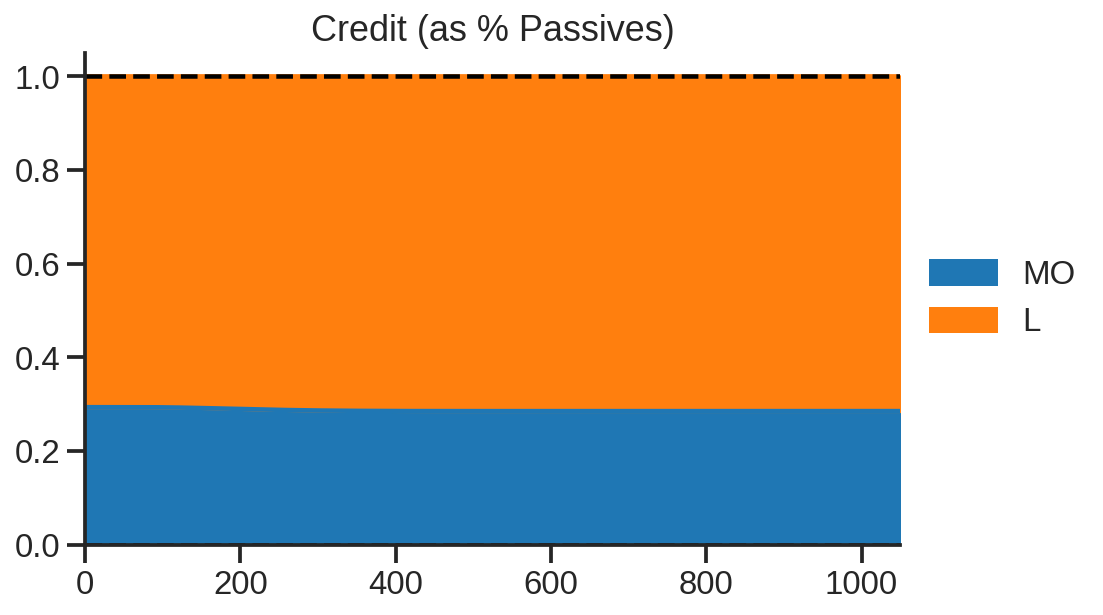

In [16]:
base = model()
df = SolveSFC(base, time=1000)
shock = ShockModel(base_model=base, create_function=model(), variable='infla', increase=0.05, time = 1000)

clock_plots(shock = shock, filename = 'Clock_4.png', variable='infla')
plot_shock(shock = shock, filename = 'Shock_4.png')
plot_norms(shock = shock, filename = 'Shock_4Norms.png')
other_plots(shock)

df4 = shock

shock4 = shock.round(decimals = 3).tail(1).transpose().loc['alpha':,:]
shock4.columns = ['$\pi$']

## Increase in Loans interest rates

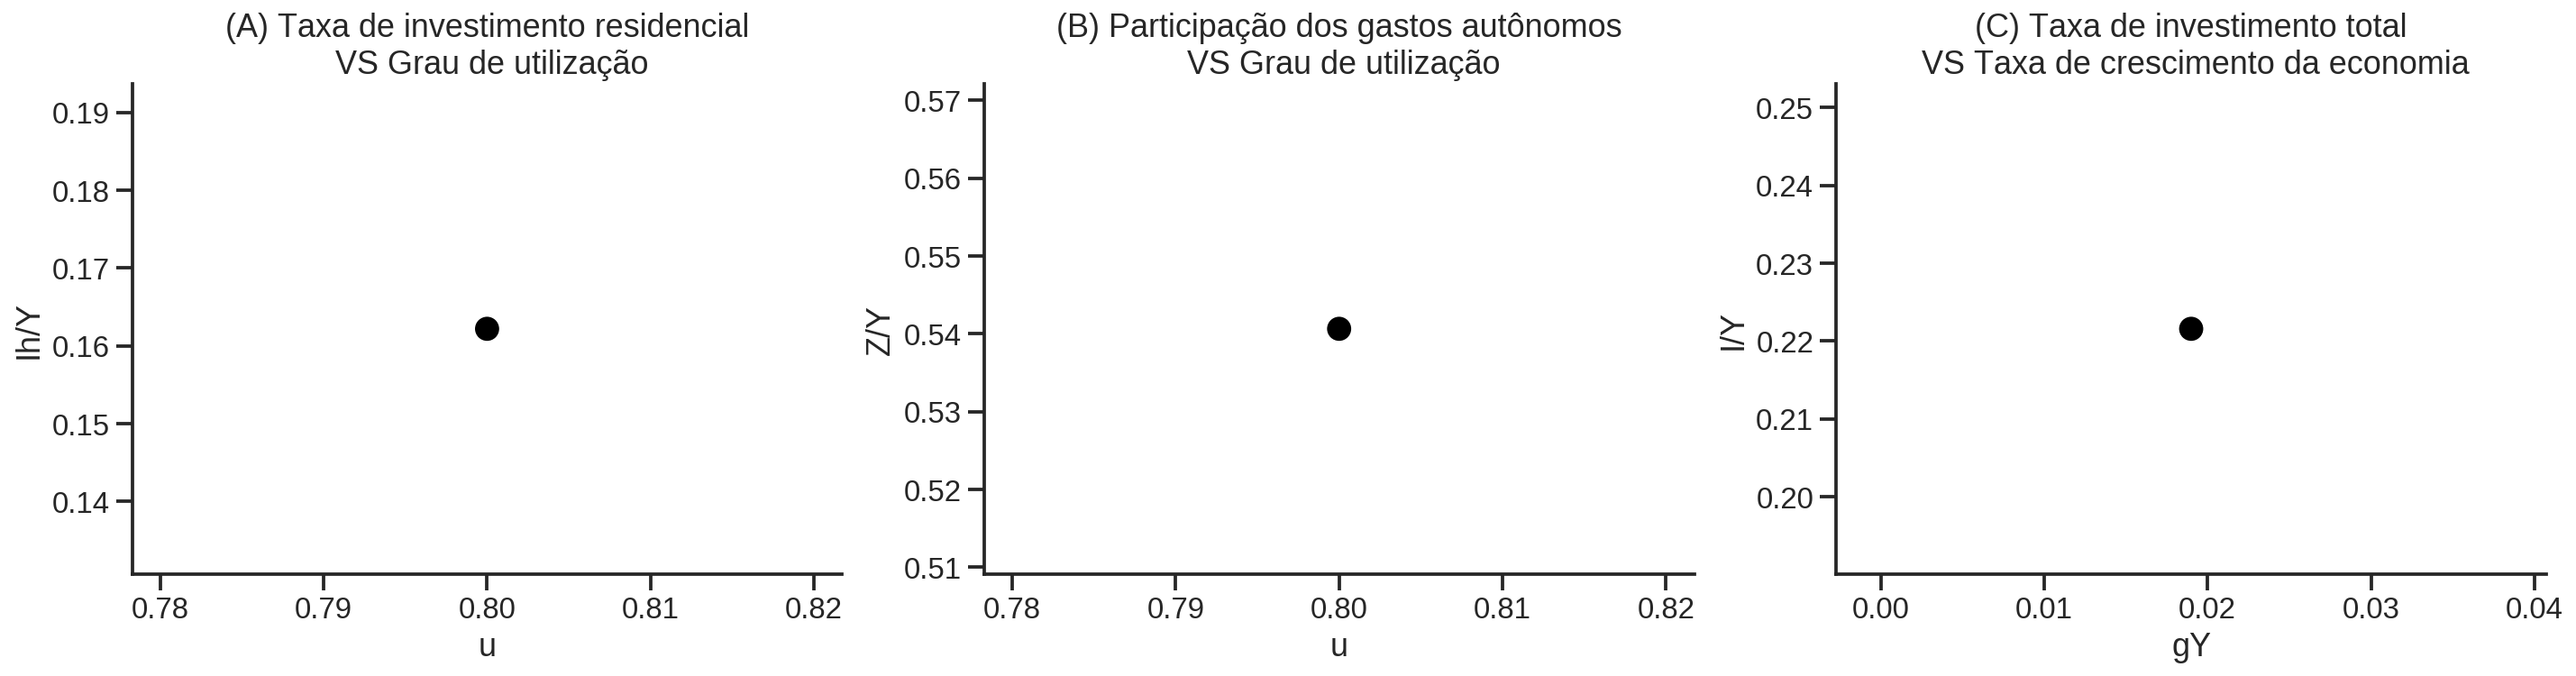

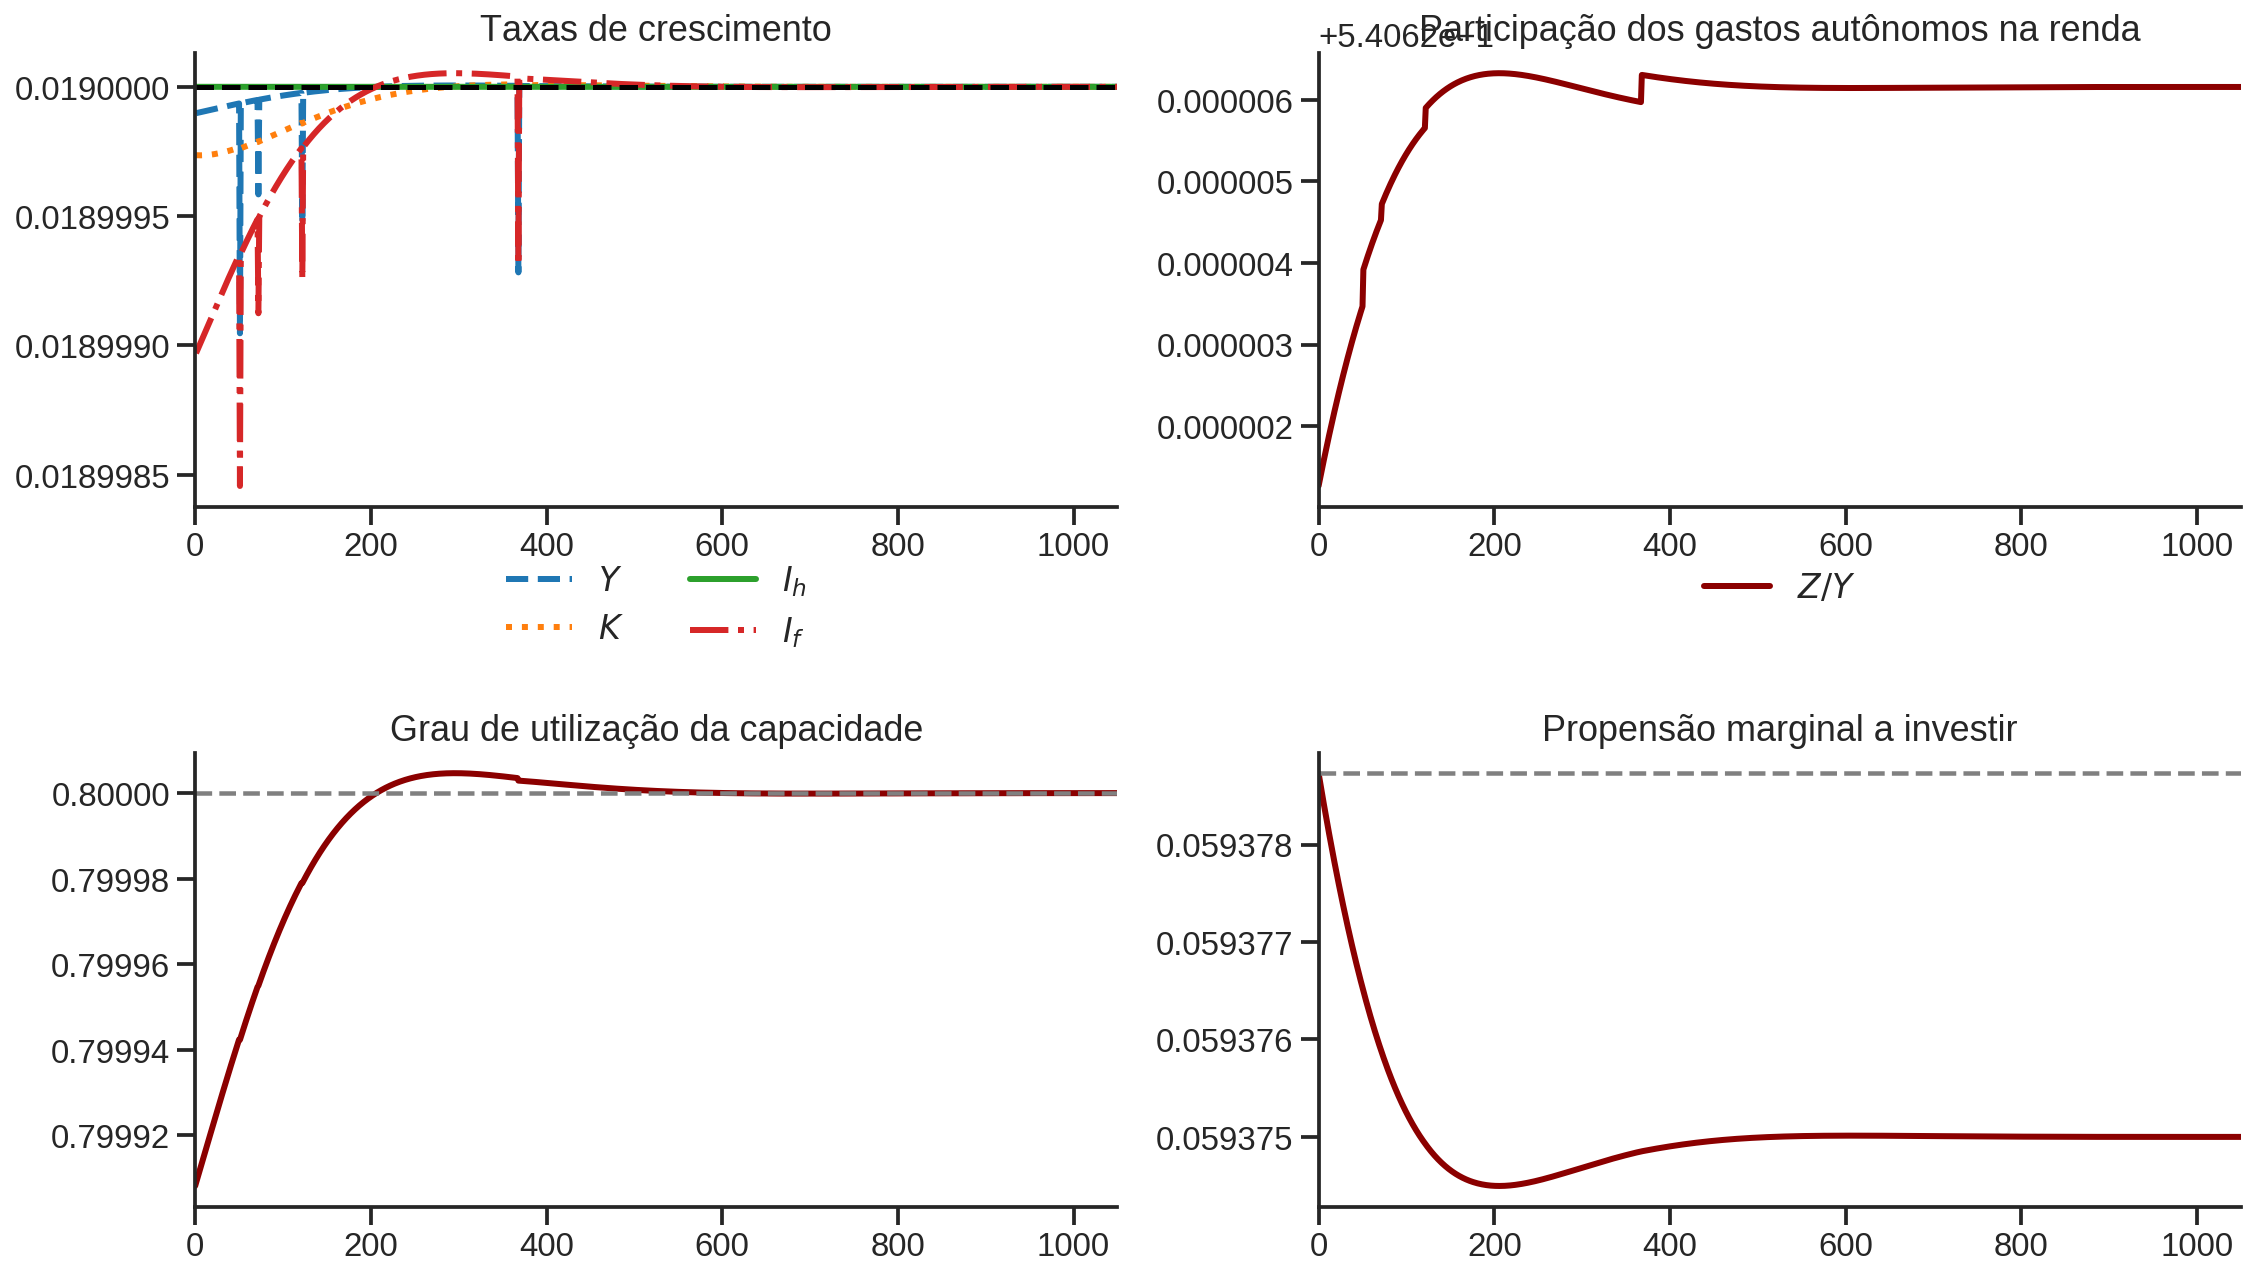

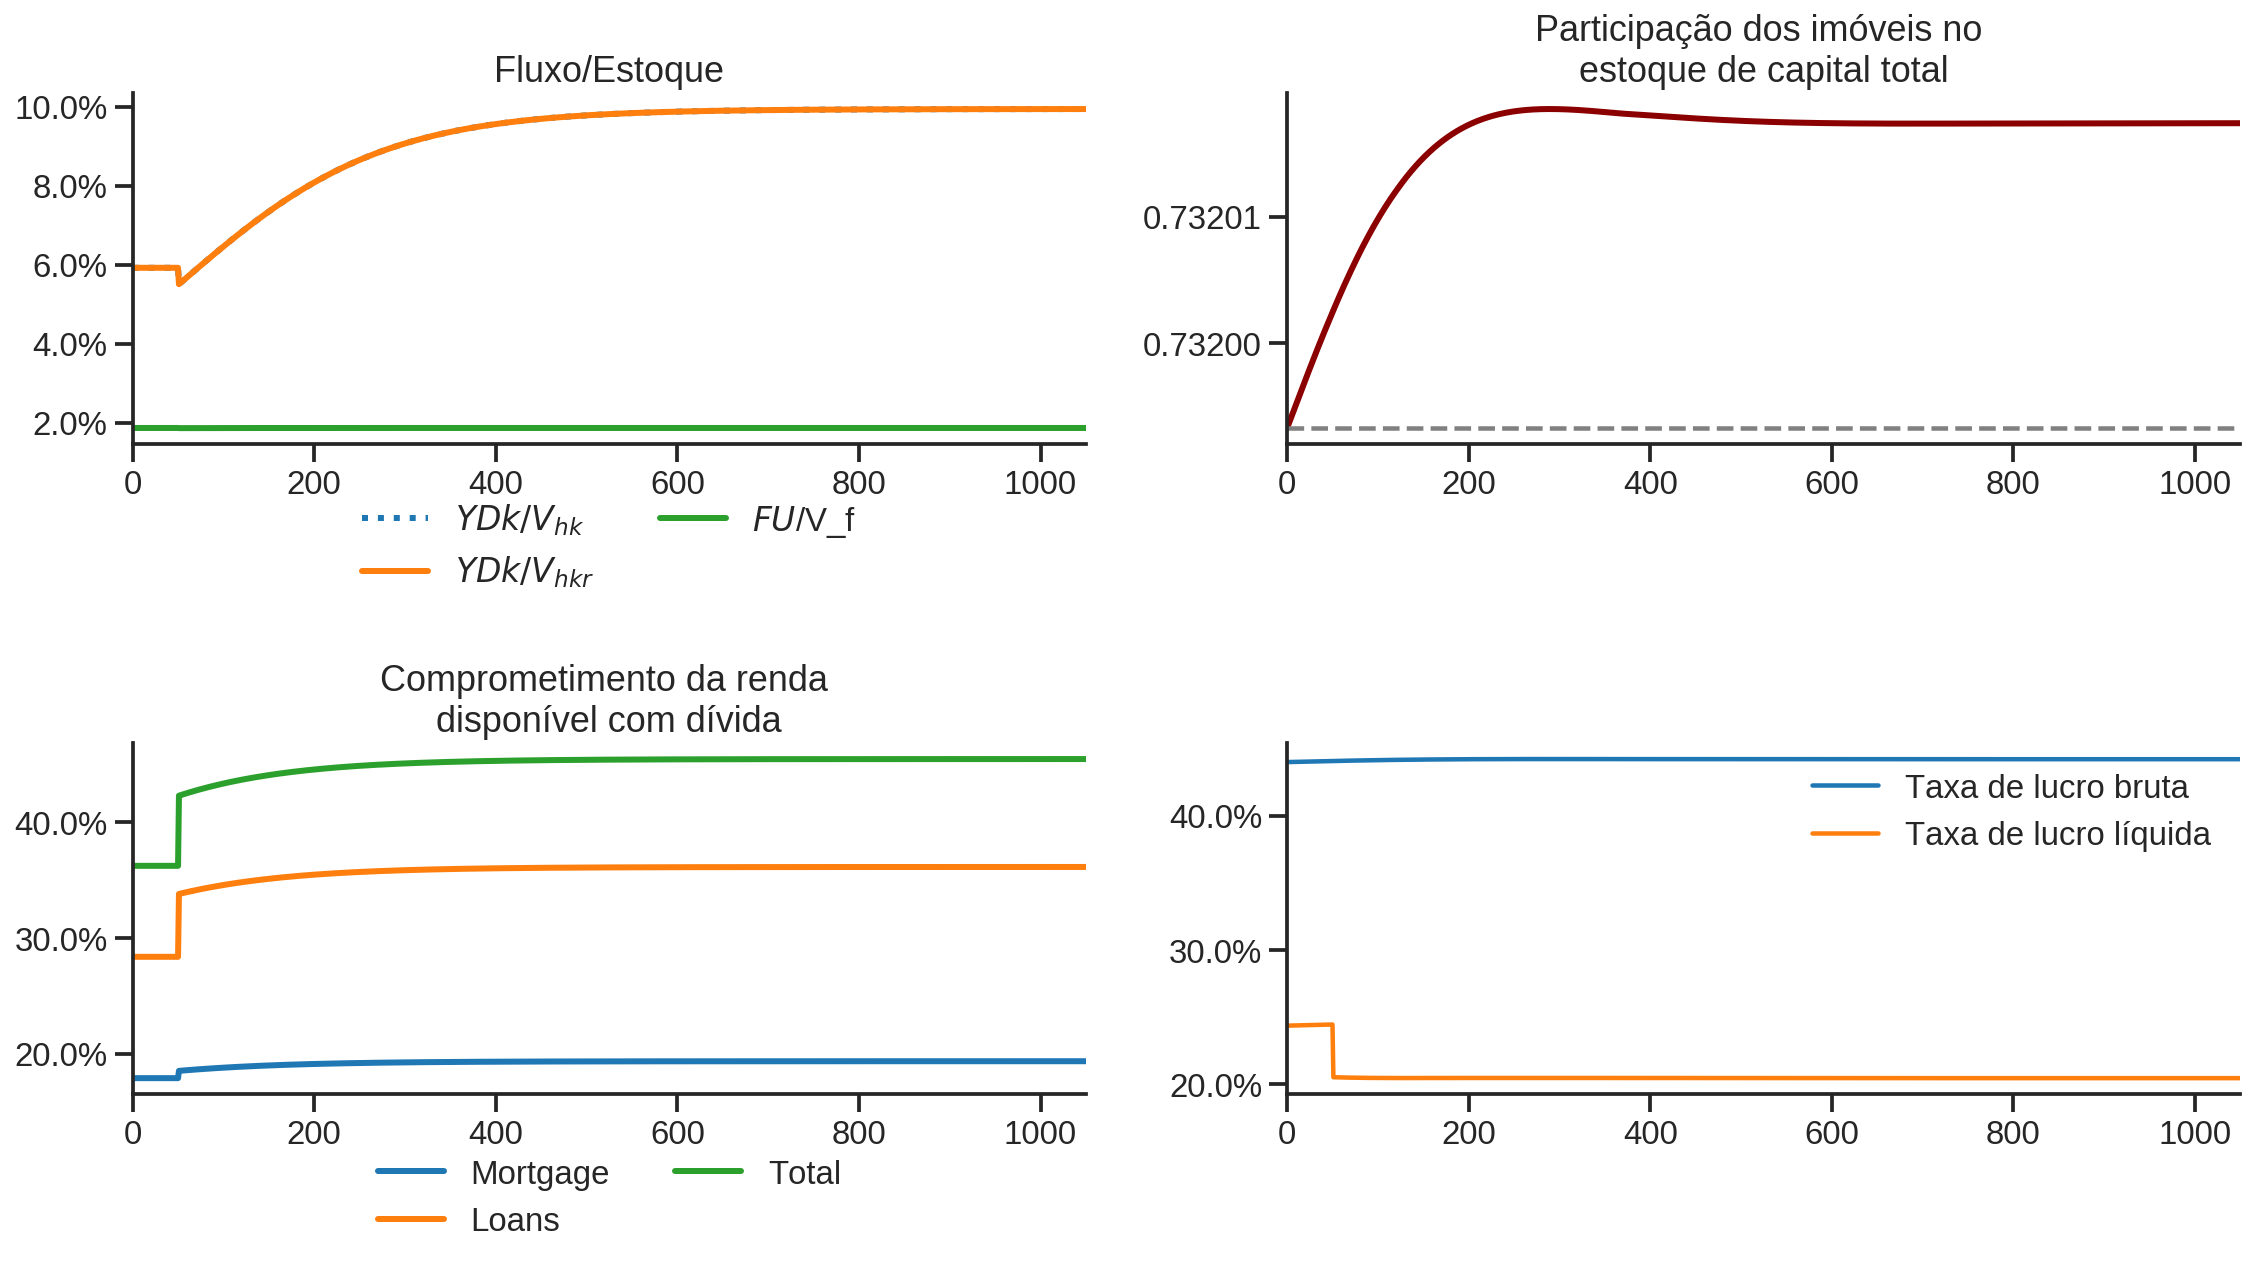

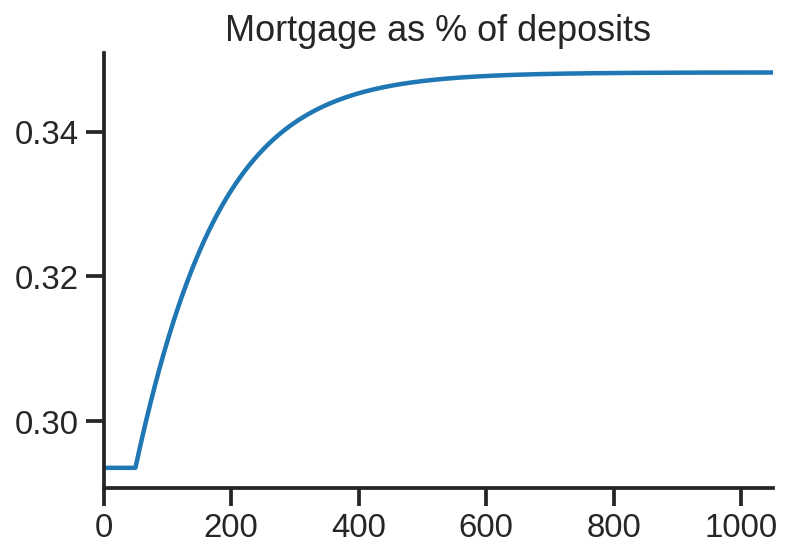

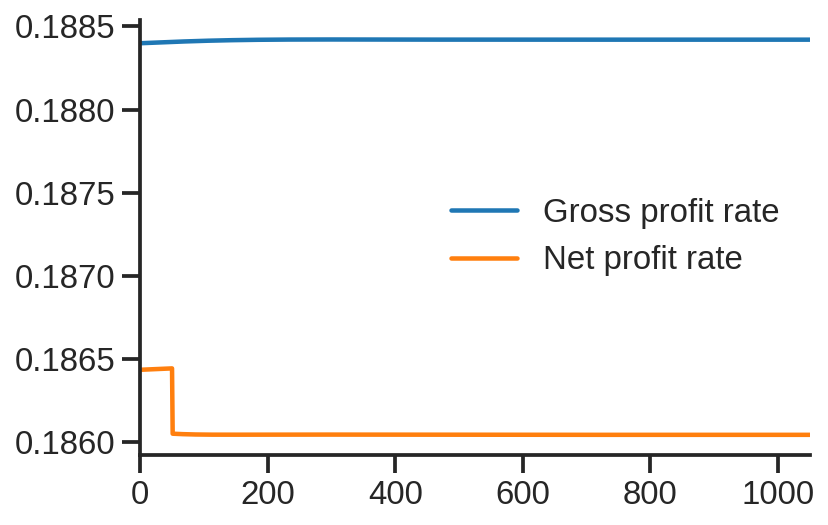

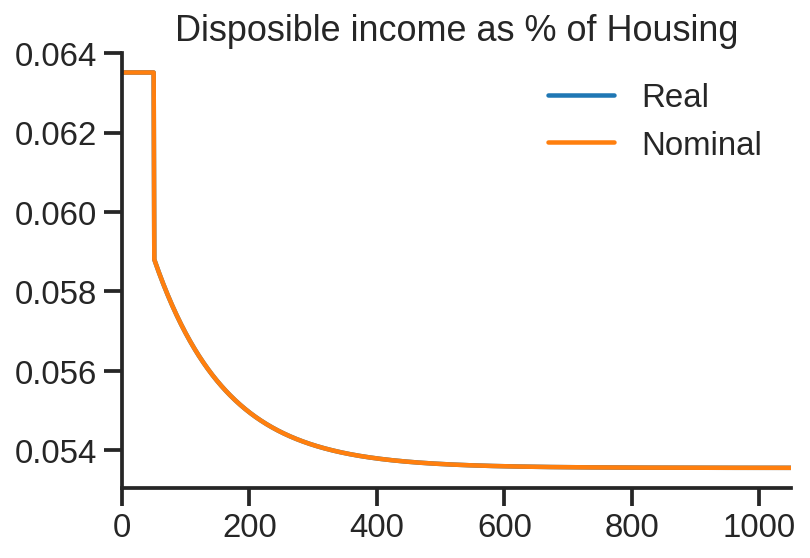

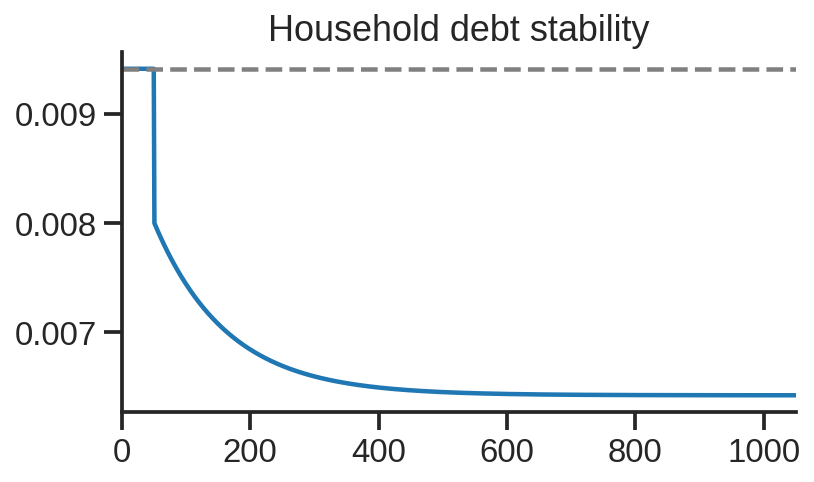

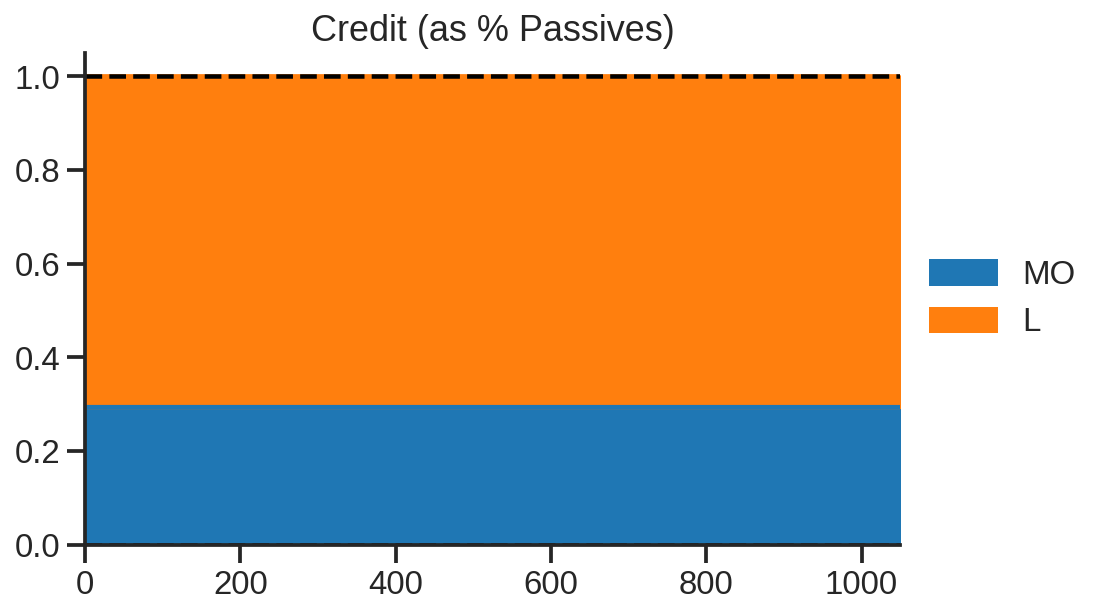

In [17]:
base = model()
df = SolveSFC(base, time=1000)
shock = ShockModel(base_model=base, create_function=model(), variable='spread_l', increase=0.2, time = 1000)
shock5 = shock.round(decimals = 5).tail(1).transpose().loc['alpha':,:]
shock5.columns = ['$\Delta rl$']
clock_plots(shock = shock, filename = 'Clock_5.png', variable='rmo')
plot_shock(shock = shock, filename = 'Shock_5.png')
plot_norms(shock = shock, filename = 'Shock_5Norms.png')
other_plots(shock)

# Merging tables

In [18]:
base = model()
df = SolveSFC(base, time=1000)
df = df.round(decimals = 4).tail(1).transpose().loc['alpha':,:]
df.columns = ['Base scenario']

table = pd.merge(left = df, right = shock1, left_index = True, right_index = True)
table = pd.merge(left = table, right = shock2, left_index = True, right_index = True)
table = pd.merge(left = table, right = shock3, left_index = True, right_index = True)
table = pd.merge(left = table, right = shock4, left_index = True, right_index = True)
table = table.loc[:"infla",:] ######### Warning
table.index = [ ######### Warning
    '$\\alpha$',
    '$\gamma_F$',
    '$\gamma_u$',
    '$\omega$',
    '$rm$',
    '$\sigma_{l}$',
    '$\sigma_{mo}$',
    '$u_N$',
    '$v$',
    '$\phi_0$',
    '$\phi_1$',
    '$R$',
    '$\pi$'
]
table.to_latex(
    "table.tex", bold_rows = True, 
    column_format = 'cccccc', decimal = ',', escape=False, 
    float_format="{:0.4f}".format,
)
table


Base scenario  $\Delta \phi_0$  $\Delta \omega$  $\Delta rm$  \
$\alpha$                1.00            1.000             1.00         1.00   
$\gamma_F$              0.08            0.080             0.08         0.08   
$\gamma_u$              0.01            0.010             0.01         0.01   
$\omega$                0.40            0.400             0.30         0.40   
$rm$                    0.01            0.010             0.01         0.02   
$\sigma_{l}$            0.00            0.000             0.00         0.00   
$\sigma_{mo}$           0.00            0.000             0.00         0.00   
$u_N$                   0.80            0.800             0.80         0.80   
$v$                     2.50            2.500             2.50         2.50   
$\phi_0$                0.02            0.025             0.02         0.02   
$\phi_1$                0.10            0.100             0.10         0.10   
$R$                     0.70            0.700             0.70         0.70   
$\pi$                   0.00            0.000             0.00         0.00   

               $\pi$  
$\alpha$        1.00  
$\gamma_F$      0.08  
$\gamma_u$      0.01  
$\omega$        0.40  
$rm$            0.01  
$\sigma_{l}$    0.00  
$\sigma_{mo}$   0.00  
$u_N$           0.80  
$v$             2.50  
$\phi_0$        0.02  
$\phi_1$        0.10  
$R$             0.70  
$\pi$           0.05

# Dag

/home/gpetrini/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gpetrini/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


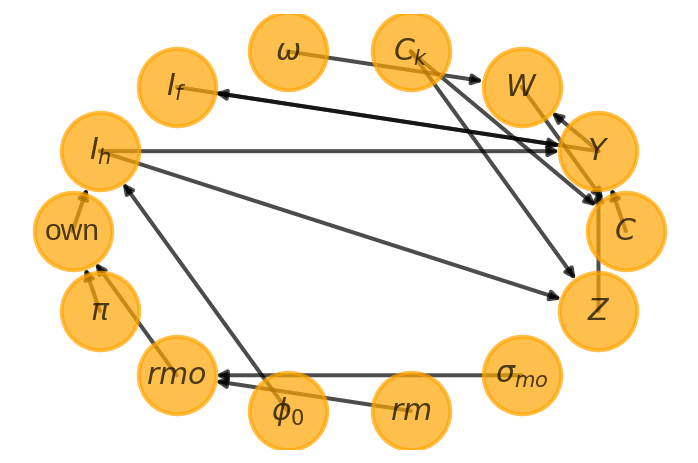

In [19]:
df = pd.DataFrame(
    {
        'Determinada' : [
            '$Y$', # 1
            #'$Y$', # 2
            '$C$','$C$', # 3
            '$W$', # 5
            '$Y$', # 7
            '$Y$', # 8
            '$I_h$', # 9
            'own', # 10
            'own', # 11
            '$I_f$', # 12
            '$I_h$', # 13
            '$rmo$', # 14
            '$rmo$', # 15,
            '$W$', # 16,
            '$Z$',
            '$Z$', 
            '$Y$',
        ], 
        'Determina' : [
            '$C$',  # 1
            #'$It$', # 2
            '$W$', '$C_k$', # 3
            '$\omega$', # 5
            '$I_f$', # 7
            '$I_h$', # 8
            'own', # 9
            '$\pi$', # 10
            '$rmo$', # 11
            '$Y$', # 12,
            '$\phi_0$', # 13
            '$rm$', # 14
            '$\sigma_{mo}$', # 15
            '$Y$', # 16
            '$C_k$',
            "$I_h$",
            '$Z$',
        ]
}
)
 
# Build your graph
G=nx.from_pandas_edgelist(
    df, 
    'Determina', 
    'Determinada', 
    create_using=nx.DiGraph() # To use with arrows
)
 
    
fig, ax = plt.subplots()
    
# Plot it
nx.draw(
    G, 
    with_labels=True, 
    node_color='orange', 
    node_size=1500, 
    edge_color='black', 
    linewidths=2,
    width=2,
    arrows=True,
    font_size=15,
    alpha=.7, 
    ax = ax,
    #pos=nx.spring_layout(G),
    #pos=nx.fruchterman_reingold_layout(G),
    pos=nx.shell_layout(G),
)

plt.show()
fig.savefig('Dag.png', dpi = 300)

# Analytical solution

In [20]:
base_eq = model()
SolveSFC(base_eq, time=1, table = False)
t = sp.Symbol('t')
initials = {
    key: base_eq.evaluate(key) for key in base_eq.parameters
}
initials.update({key: base_eq.evaluate(key) for key in base_eq.variables})

for i in base_eq.variables:
  globals()["_" + i] = sp.Function(i)
  
for i in base_eq.parameters:
  globals()[i] = sp.symbols(i, positive=True)
  globals()['infla'] = sp.symbols('infla')

## General equations

In [21]:
Y = _C(t) + _I_t(t)
pprint(sp.Eq(_Y(t), Y))
C = _Cw(t) + _Ck(t)
pprint(sp.Eq(_C(t), C))
I = _I_f(t) + _I_h(t)
pprint(sp.Eq(_I_t(t), I))
Yk = _K_f(t)/v
pprint(sp.Eq(_Yk(t), Yk))
u = _Y(t)/_Yk(t)
pprint(sp.Eq(_u(t), u))
Z = _I_h(t)
pprint(sp.Eq(_Z(t), Z))
W = omega*_Y(t)
pprint(sp.Eq(_W(t), W))
K = _K_HD(t) + _K_f(t)
pprint(sp.Eq(_K(t), K))
Z = _Ck(t) + _I_h(t)
pprint(sp.Eq(_Z(t), Z))

Y(t) = C(t) + Iₜ(t)
C(t) = Ck(t) + Cw(t)
Iₜ(t) = I_f(t) + Iₕ(t)
        K_f(t)
Yk(t) = ──────
          v   
        Y(t)
u(t) = ─────
       Yk(t)
Z(t) = Iₕ(t)
W(t) = ω⋅Y(t)
K(t) = K_HD(t) + K_f(t)
Z(t) = Ck(t) + Iₕ(t)


## Workers

In [22]:
Cw = alpha*_W(t)
pprint(sp.Eq(_Cw(t), Cw))
YDw = _W(t)
pprint(sp.Eq(_YDw(t), YDw))
S_hw = _YDk(t) - _Cw(t)
pprint(sp.Eq(_S_hw(t), S_hw))
NFW_hw = _S_hw(t)
pprint(sp.Eq(_NFW_hw(t), NFW_hw))

Cw(t) = α⋅W(t)
YDw(t) = W(t)
S_hw(t) = -Cw(t) + YDk(t)
NFW_hw(t) = S_hw(t)


## Capitalists

In [23]:
Ck = R*_Z(t)
pprint(sp.Eq(_Ck(t), Ck))
dLk = _Ck(t)
pprint(sp.Eq(_Lk(t) - _Lk(t-1), dLk))
YDk = _FD(t) + rm*_M_h(t-1) - _rmo(t)*_MO(t-1) - _rl(t)*_Lk(t-1)
pprint(sp.Eq(_YDk(t), YDk))
S_hk = _YDk(t) - _Ck(t)
pprint(sp.Eq(_S_hk(t), S_hk))
dMO = _I_h(t)
pprint(sp.Eq(_MO(t) - _MO(t-1), dMO))
dM_h = _S_hk(t) + (_Lk(t) - _Lk(t-1)) - (_Eq(t) - _Eq(t-1))
pprint(sp.Eq((_M_h(t) - _M_h(t-1)), _M_h))
Eq_ = a*_K_f(t-1)
pprint(sp.Eq(_Eq(t), Eq_))
V_h = _M_h(t) + _K_HD(t)*_ph(t) - _MO(t) + _Eq(t) - _Lk(t)
pprint(sp.Eq(_V_h(t), V_h))
V_hr = _M_h(t) + _K_HD(t) - _MO(t) + _Eq(t) - _Lk(t)
pprint(sp.Eq(_V_hr(t), V_hr))
NFW_h = _S_hk(t) - _I_h(t)
pprint(sp.Eq(_NFW_h(t), NFW_h))
M_h = _S_hk(t) + (_Lk(t) - _Lk(t-1)) - (_Eq(t) - _Eq(t))
pprint(sp.Eq(_M_h(t), M_h))

Ck(t) = R⋅Z(t)
Lk(t) - Lk(t - 1) = Ck(t)
YDk(t) = rm⋅Mₕ(t - 1) + FD(t) - Lk(t - 1)⋅rl(t) - MO(t - 1)⋅rmo(t)
Sₕₖ(t) = -Ck(t) + YDk(t)
MO(t) - MO(t - 1) = Iₕ(t)
Mₕ(t) - Mₕ(t - 1) = Mₕ
Eq(t) = a⋅K_f(t - 1)
Vₕ(t) = Eq(t) + K_HD(t)⋅ph(t) - Lk(t) - MO(t) + Mₕ(t)
Vₕᵣ(t) = Eq(t) + K_HD(t) - Lk(t) - MO(t) + Mₕ(t)
NFWₕ(t) = -Iₕ(t) + Sₕₖ(t)
Mₕ(t) = Lk(t) - Lk(t - 1) + Sₕₖ(t)


## Firms

In [24]:
I_f = _h(t)*_Y(t)
pprint(sp.Eq(_I_f(t), I_f))
dK_f = _I_f(t)
pprint(sp.Eq(_K_f(t) - _K_f(t-1), dK_f))
Lf = _I_f(t) - _FU(t) + _L(t-1) - (_Eq(t) - _Eq(t-1))
pprint(sp.Eq(_Lf(t), Lf))
FT = _FU(t) + _FD(t)
pprint(sp.Eq(_FT(t), FT))
FU = gamma_F*(_FT(t) - _rl(t)*_Lf(t-1))
pprint(sp.Eq(_FU(t), FU))
FD = (1 - gamma_F)*(_FT(t) - _rl(t)*_Lf(t-1))
pprint(sp.Eq(_FD(t), FD))
h = _h(t-1)*gamma_u*(_u(t)-un) + _h(t-1)
pprint(sp.Eq(_h(t), h))
NFW_f = _FU(t) - _I_f(t)
pprint(sp.Eq(_NFW_f(t), NFW_f))
V_f = _K_f(t) - _L(t) - _Eq(t)
pprint(sp.Eq(_V_f(t), V_f))

I_f(t) = Y(t)⋅h(t)
K_f(t) - K_f(t - 1) = I_f(t)
Lf(t) = -Eq(t) + Eq(t - 1) - FU(t) + I_f(t) + L(t - 1)
FT(t) = FD(t) + FU(t)
FU(t) = γ_F⋅(FT(t) - Lf(t - 1)⋅rl(t))
FD(t) = (1 - γ_F)⋅(FT(t) - Lf(t - 1)⋅rl(t))
h(t) = γᵤ⋅(-un + u(t))⋅h(t - 1) + h(t - 1)
NFW_f(t) = FU(t) - I_f(t)
V_f(t) = -Eq(t) + K_f(t) - L(t)


## Banks

In [25]:
L = _Lf(t) + _Lk(t)
pprint(sp.Eq(_L(t), L))
M = (_L(t) - _L(t-1)) + (_MO(t) - _MO(t-1)) + _M(t-1)
pprint(sp.Eq(_M(t), M))
rmo = (1+ spread_mo)*rm
pprint(sp.Eq(_rmo(t), rmo))
rl = (1+ spread_l)*rm
pprint(sp.Eq(_rl(t), rl))
V_b = _L(t) + _MO(t) - _M(t)
pprint(sp.Eq(_V_b(t), V_b))
NFW_b = _rl(t)*_L(t-1) + _rmo(t)*_MO(t-1) - rm*_M(t-1)
pprint(sp.Eq(_NFW_b(t), NFW_b))

L(t) = Lf(t) + Lk(t)
M(t) = L(t) - L(t - 1) + M(t - 1) + MO(t) - MO(t - 1)
rmo(t) = rm⋅(spreadₘₒ + 1)
rl(t) = rm⋅(spreadₗ + 1)
V_b(t) = L(t) - M(t) + MO(t)
NFW_b(t) = -rm⋅M(t - 1) + L(t - 1)⋅rl(t) + MO(t - 1)⋅rmo(t)


## Residential Investment

In [26]:
_own = sp.Function('own')

K_HS = _K_HD(t)
pprint(sp.Eq(_K_HS(t), K_HS))
Is = _I_h(t)
pprint(sp.Eq(_Is(t), Is))
dK_HD = _I_h(t)
pprint(sp.Eq(_K_HD(t) - _K_HD(t-1), dK_HD))
I_h = (1+_g_Z(t))*_I_h(t-1)
pprint(sp.Eq(_I_h(t), I_h))
K_k = _K_HD(t)/(_K(t))
pprint(sp.Eq(_K_k(t), K_k))
ph = (1+infla)*_ph(t-1)
pprint(sp.Eq(_ph(t), ph))
own = ((1+_rmo(t))/(1+infla))-1
pprint(sp.Eq(_own(t), own))
g_Z = phi_0 - phi_1*_own(t)
pprint(sp.Eq(_g_Z(t), g_Z))

K_HS(t) = K_HD(t)
Is(t) = Iₕ(t)
K_HD(t) - K_HD(t - 1) = Iₕ(t)
Iₕ(t) = (g_Z(t) + 1)⋅Iₕ(t - 1)
        K_HD(t)
Kₖ(t) = ───────
          K(t) 
ph(t) = (infla + 1)⋅ph(t - 1)
              rmo(t) + 1
own(t) = -1 + ──────────
              infla + 1 
g_Z(t) = φ₀ - φ₁⋅own(t)


## Debt dynamics

In [27]:
_dDT, _ddt = sp.symbols('dDT ddt')
dDT = _Z(t) - _YDk(t)
pprint(sp.Eq(_dDT, dDT))
dDT = dDT.subs(_YDk(t), YDk)
pprint(sp.Eq(_dDT, dDT))
dDT = dDT.subs(_M_h(t), M_h)
pprint(sp.Eq(_dDT, dDT))
dDT = dDT.subs(_FD(t), FD)
pprint(sp.Eq(_dDT, dDT))
dDT = dDT.subs(_FT(t), (1-omega)*_Y(t))
pprint(sp.Eq(_dDT, dDT))
dDT = dDT.subs(_Y(t), _Z(t)/(1-omega - _h(t)))
pprint(sp.Eq(_dDT, dDT))

dDT = -YDk(t) + Z(t)
dDT = -rm⋅Mₕ(t - 1) - FD(t) + Lk(t - 1)⋅rl(t) + MO(t - 1)⋅rmo(t) + Z(t)
dDT = -rm⋅Mₕ(t - 1) - FD(t) + Lk(t - 1)⋅rl(t) + MO(t - 1)⋅rmo(t) + Z(t)
dDT = -rm⋅Mₕ(t - 1) - (1 - γ_F)⋅(FT(t) - Lf(t - 1)⋅rl(t)) + Lk(t - 1)⋅rl(t) + 
MO(t - 1)⋅rmo(t) + Z(t)
dDT = -rm⋅Mₕ(t - 1) - (1 - γ_F)⋅((1 - ω)⋅Y(t) - Lf(t - 1)⋅rl(t)) + Lk(t - 1)⋅r
l(t) + MO(t - 1)⋅rmo(t) + Z(t)
                                ⎛ (1 - ω)⋅Z(t)                  ⎞             
dDT = -rm⋅Mₕ(t - 1) - (1 - γ_F)⋅⎜───────────── - Lf(t - 1)⋅rl(t)⎟ + Lk(t - 1)⋅
                                ⎝-ω - h(t) + 1                  ⎠             

                               
rl(t) + MO(t - 1)⋅rmo(t) + Z(t)
                               


### Stability condition

In [28]:
g = sp.Function('g')
gK = sp.Function('g_K')


def replacer(express):
    #print("\nReplacing the initial values.....")
    df = SolveSFC(model(), time=1)
    df = df.iloc[1, :]

    express = express.subs(alpha, df['alpha']).subs(
        omega, df['omega'])
    express = express.subs(un, df['un']).subs(
        gamma_u, df['gamma_u'])
    express = express.subs(
        infla, df['infla'])
    express = express.subs(phi_0, df['phi_0']).subs(
        phi_1,
        df['phi_1']).subs(rm, df['rm']).subs(
            spread_mo, df['spread_mo'])
    express = express.subs(rm, df['rm']).subs(
            spread_mo, df['spread_mo']).subs(v, df['v']).subs(R, df['R'])
    return express

In [29]:
EqY = Y - _Y(t)
EqY = EqY.subs(_C(t), C).subs(_Ck(t), Ck).subs(_Cw(t), Cw)
EqY = EqY.subs(_I_t(t), I).subs(_I_f(t), I_f)
EqY = EqY.subs(_W(t), W)
EqY = EqY.subs(_I_h(t), (1-R)*_Z(t))

EqY = sp.solve(EqY, _Y(t))[0].collect(alpha).collect(omega)
solY = EqY.subs(alpha,1)
pprint(cse(solY, optimizations='basic')[1], use_unicode=True)
print('dY/d alpha = ', EqY.diff(alpha))
print('dY/d omega = ', EqY.diff(omega))

print("\nGowth rate.....")
gY, h_, gz_ = sp.symbols('gY h gZ')
gY_ = alpha*omega * gY + R*(_Z(t) / _Y(t)) * _g_Z(t) + _h(t) * gY + _h(t) - _h(
    t - 1) + (1-R)*(_Z(t) / _Y(t)) * _g_Z(t) - gY
gY_ = gY_.subs(_g_Z(t), gz_).subs(_Y(t), solY).subs(_g_Z(t), gz_).subs(alpha,1)
gY_ = gY_.subs(_h(t) - _h(t - 1), h - _h(t - 1))
gY_ = sp.solve(gY_, gY)[0].collect(gz_)
pprint(cse(gY_, optimizations='basic')[1], use_unicode=True)

print('\nd gY/ d omega\n')
pprint(gY_.diff(omega))

print("For u = un")
pprint(sp.Eq(gY, gY_.subs(_u(t), un)))

⎡   -Z(t)    ⎤
⎢────────────⎥
⎣ω + h(t) - 1⎦
dY/d alpha =  omega*Z(t)/(alpha*omega + h(t) - 1)**2
dY/d omega =  alpha*Z(t)/(alpha*omega + h(t) - 1)**2

Gowth rate.....
⎡gZ⋅x₀ + un⋅x₁ - x₁⋅u(t)⎤
⎢───────────────────────⎥
⎣           x₀          ⎦

d gY/ d omega

     gZ        gZ⋅(ω + h(t) - 1) + γᵤ⋅un⋅h(t - 1) - γᵤ⋅h(t - 1)⋅u(t)
──────────── - ─────────────────────────────────────────────────────
ω + h(t) - 1                                    2                   
                                  (ω + h(t) - 1)                    
For u = un
gY = gZ


### Stability conditon (I)

In [30]:
own_ = sp.Symbol('own')
g_LR = gY_.subs(_u(t), un)
pprint(sp.Eq(g(t), g_LR))

Equ = _u(t)*(g(t) - gK(t)) + _u(t-1)
pprint(sp.Eq(_u(t), Equ))
g_K = (_h(t)*_u(t))/v
pprint(sp.Eq(gK(t), g_K))
Equ = _u(t)*(g(t) - g_K)
Equ = Equ.subs(g(t), gz_)
pprint(sp.Eq(_u(t), Equ))
print(sp.latex(sp.Eq(_u(t), Equ)))

Eqh = _h(t)*gamma_u*(_u(t) - un)
pprint(sp.Eq(_h(t), Eqh))
print(sp.latex(sp.Eq(_h(t), Eqh)))

print('\nBuilding Jacobian matrix and evaluating at u = un\n')
J = sp.Matrix([
        [
            Eqh.diff(_h(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), g_LR*v/un), 
            Eqh.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), g_LR*v/un)
        ], 
        [
            Equ.diff(_h(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), g_LR*v/un), 
            Equ.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), g_LR*v/un)
        ]])
pprint(J)
print(sp.latex(J))
print('\nDeterminant:\n')
pprint(J.det()>0)
print(sp.latex(J.det()>0))
estability = sp.solve(J.det().subs(gz_, g_Z).subs(_own(t), own_)>0, own_)
print("\nStability condition\n")
pprint(estability)
estability = replacer(estability)
pprint(estability)
pprint(sp.Eq(own_, initials['own']))
estability = estability.subs(own_, own)
pprint(estability)
print('Rewriting')
estability = -(1+infla) + (1+rmo) < 2*(1+infla)
pprint(estability)
estability = sp.solve(estability, infla)
pprint(estability)
estability = estability.subs(spread_mo, initials['spread_mo']).subs(rm, initials['rm'])
pprint(estability)

print('\nTrace:\n')
pprint(J.trace()<0)
print(sp.latex(J.trace()<0))
print("\nStability condition\n")
estability = sp.solve(J.trace()<0).subs(gz_, g_Z)
pprint(estability)
estability = estability.subs(_own(t), own).subs(_rmo(t), rmo)
pprint(estability)
estability = estability.subs(spread_mo, initials['spread_mo']).subs(rm, initials['rm'])
estability = estability.subs(phi_0, initials['phi_0']).subs(phi_1, initials['phi_1'])
pprint(estability)

g(t) = gZ
u(t) = (g(t) - g_K(t))⋅u(t) + u(t - 1)
         h(t)⋅u(t)
g_K(t) = ─────────
             v    
       ⎛     h(t)⋅u(t)⎞     
u(t) = ⎜gZ - ─────────⎟⋅u(t)
       ⎝         v    ⎠     
u{\left(t \right)} = \left(gZ - \frac{h{\left(t \right)} u{\left(t \right)}}{v}\right) u{\left(t \right)}
h(t) = γᵤ⋅(-un + u(t))⋅h(t)
h{\left(t \right)} = \gamma_{u} \left(- un + u{\left(t \right)}\right) h{\left(t \right)}

Building Jacobian matrix and evaluating at u = un

⎡       gZ⋅γᵤ⋅v⎤
⎢  0    ───────⎥
⎢          un  ⎥
⎢              ⎥
⎢   2          ⎥
⎢-un           ⎥
⎢─────    -gZ  ⎥
⎣  v           ⎦
\left[\begin{matrix}0 & \frac{gZ \gamma_{u} v}{un}\\- \frac{un^{2}}{v} & - gZ\end{matrix}\right]

Determinant:

gZ⋅γᵤ⋅un > 0
gZ \gamma_{u} un > 0

Stability condition

      φ₀
own < ──
      φ₁
own < 0.2
own = 0.01
     rmo(t) + 1      
-1 + ────────── < 0.2
     infla + 1       
Rewriting
-infla + rm⋅(spreadₘₒ + 1) < 2⋅infla + 2
        rm⋅spreadₘₒ   rm   2
infla > ─────────── + ── - ─
    

### Stability condition (II)

In [31]:
print('d gY/d u < d gK/ d u')
print('d gY/ d u :')
pprint(gY_.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un))

print('d gK/ d u :')
pprint(g_K.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un))

print('Solving the inequality')
pprint(sp.solve(gY_.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un)< g_K.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un), gamma_u))
print(sp.latex(sp.solve(gY_.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un)< g_K.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un), gamma_u)))

d gY/d u < d gK/ d u
d gY/ d u :
    -gZ⋅γᵤ⋅v     
─────────────────
   ⎛gZ⋅v        ⎞
un⋅⎜──── + ω - 1⎟
   ⎝ un         ⎠
d gK/ d u :
gZ
──
un
Solving the inequality
   -gZ⋅γᵤ⋅v        gZ
──────────────── < ──
gZ⋅v + ω⋅un - un   un
- \frac{gZ \gamma_{u} v}{gZ v + \omega un - un} < \frac{gZ}{un}


## Capacity utilization on the long-run

Consider $k$ as the fraction between real housing and total capital (including households' capital):

$$
k = \frac{K_h}{K}
$$

The capacity utilization ration can be definede as:

$$
u = \frac{Y\cdot v}{K \cdot (1-k)}
$$

So, dividing Y by houseolds' capital is the same as:

$$
\frac{Y}{k\cdot K}
$$

Multiplying by $v$:


$$
\frac{Y}{k\cdot K}\cdot v = \frac{Y\cdot v}{K}\cdot \left(\frac{1}{k}\right)
$$

Multiplying and dividing by $1-k$:

$$
\frac{Y\cdot v}{K\cdot (1-k)}\cdot \left(\frac{1-k}{k}\right) = u \cdot \left(\frac{1-k}{k}\right)
$$

Therefore,

$$
Y\frac{v}{K_h} =  u \cdot \left(\frac{1-k}{k}\right)
$$

$$
u = Y\frac{v}{K_h} \cdot \left(\frac{k}{1-k}\right)
$$

In [32]:
k = sp.Symbol('K_k')

rel = solY*(v/_K_HD(t))*(k/(1-k))
rel = rel.subs(_Z(t)/_K_HD(t), g_Z/(1-R)) ### Warning
rel = rel.subs(_h(t), h)

pprint(rel)
print('\nFor the long run...\n')

rel = rel.subs(_u(t), un).subs(_h(t-1), _h(t))
rel = rel.subs(_h(t), g_Z*v/un)
rel = rel.subs(_own(t), own)
rel = rel.subs(_rmo(t), rmo)

pprint(sp.Eq(_u(t), rel))
print(sp.latex(sp.Eq(_u(t), rel)))

def collector(express):
    express = express.simplify().collect(phi_0).collect(phi_1).collect(v)
    express = express.collect(omega).collect(alpha).collect(un).collect(infla+1).collect(R)
    express = express.simplify()
    return express


rel = rel - un
rel = sp.solve(rel,k/(1-k))[0]
pprint(sp.Eq(k/(1-k), collector(rel)))
print(sp.latex(sp.Eq(k/(1-k), collector(rel))))
pprint(sp.Eq(k/(1-k), replacer(rel)))
print(f"Error = {replacer(rel) - base.evaluate('K_k/(1-K_k)')}")

print('\n' + '='*70)
print('\nChange in income distribution:\n')
result = collector(rel.diff(omega))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd (k/1-k)/ d omega > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in spread:\n')
result = collector(rel.diff(spread_mo))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd (k/1-k)/ d spread > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in inflation:\n')
result = collector(rel.diff(infla))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd (k/1-k)/ d inflation > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in autonomous component:\n')
result = collector(rel.diff(phi_0))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd (k/1-k)/ d phi_0 > 0? {result > 0}')

print('\n' + '='*70)
print('\nHousing as % of total Capital\n')
rel = rel*(1-k) - k
rel = sp.solve(rel, k)[0]
pprint(sp.Eq(k, collector(rel)))
print(sp.latex(sp.Eq(k, collector(rel))))
print(f"Error = {replacer(rel) - base.evaluate('K_k')}")
print(f"Error = {replacer(1-rel) - base.evaluate('(g_Z*v/(1-R)*un)/(1-alpha*omega)')}")

print('\n' + '='*70)
print('\nChange in income distribution:\n')
result = collector(rel.diff(omega))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d omega > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in spread:\n')
result = collector(rel.diff(spread_mo))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d spread > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in inflation:\n')
result = collector(rel.diff(infla))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d inflation > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in autonomous component:\n')
result = collector(rel.diff(phi_0))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d phi_0 > 0? {result > 0}')

print('\n' + '='*70)
print('\nFirms capital as % of total Capital:\n')
rel = (g_Z*v/un)/(1-omega*alpha)
rel = rel.subs(_own(t), own).subs(_rmo(t), rmo)
pprint(sp.Eq(1-k, rel))

print('\n' + '='*70)
print('\nChange in income distribution:\n')
result = collector(rel.diff(omega))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d omega > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in spread:\n')
result = collector(rel.diff(spread_mo))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d spread > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in inflation:\n')
result = collector(rel.diff(infla))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d inflation > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in autonomous component:\n')
result = collector(rel.diff(phi_0))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d phi_0 > 0? {result > 0}')

print('\n' + '='*70)
print('\nRevisiting Houses as % of total Capital:\n')
rel = 1 - rel
pprint(sp.Eq(k, rel))
print(sp.latex(sp.Eq(k, rel)))

print('\n' + '='*70)
print('\nChange in income distribution:\n')
result = collector(rel.diff(omega))
pprint(result)
print(sp.latex(result))
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d omega > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in rm:\n')
result = collector(rel.diff(rm))
pprint(result)
print(sp.latex(result))
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d rm > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in inflation:\n')
result = collector(rel.diff(infla))
pprint(result)
print(sp.latex(result))
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d inflation > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in autonomous component:\n')
result = collector(rel.diff(phi_0))
pprint(result)
print(sp.latex(result))
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d phi_0 > 0? {result > 0}')

                   -Kₖ⋅v⋅(φ₀ - φ₁⋅own(t))                     
──────────────────────────────────────────────────────────────
(1 - Kₖ)⋅(1 - R)⋅(γᵤ⋅(-un + u(t))⋅h(t - 1) + ω + h(t - 1) - 1)

For the long run...

                        ⎛        ⎛     rm⋅(spreadₘₒ + 1) + 1⎞⎞            
                  -Kₖ⋅v⋅⎜φ₀ - φ₁⋅⎜-1 + ─────────────────────⎟⎟            
                        ⎝        ⎝           infla + 1      ⎠⎠            
u(t) = ───────────────────────────────────────────────────────────────────
                        ⎛          ⎛        ⎛     rm⋅(spreadₘₒ + 1) + 1⎞⎞⎞
                        ⎜        v⋅⎜φ₀ - φ₁⋅⎜-1 + ─────────────────────⎟⎟⎟
                        ⎜          ⎝        ⎝           infla + 1      ⎠⎠⎟
       (1 - Kₖ)⋅(1 - R)⋅⎜ω - 1 + ────────────────────────────────────────⎟
                        ⎝                           un                   ⎠
u{\left(t \right)} = - \frac{K_{k} v \left(\phi_{0} - \phi_{1} \left(-1 + \frac{rm \left(spread_{mo} + 1\right) + 

-φ₁⋅rm⋅v⋅(R⋅(un⋅(R⋅(infla + 1) - infla + ω⋅(-R⋅(infla + 1) + infla + 1) - 1) +
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                              

 v⋅(φ₀⋅(-R⋅(infla + 1) + infla + 1) - φ₁⋅(-R⋅(-infla + rm⋅spreadₘₒ + rm) - inf
──────────────────────────────────────────────────────────────────────────────
                                                                              
                  (R⋅v⋅(φ₀⋅(infla + 1) - φ₁⋅(-infla + rm⋅spreadₘₒ + rm)) - un⋅

la + rm⋅spreadₘₒ + rm))) + (R - 1)⋅(R⋅v⋅(φ₀⋅(infla + 1) - φ₁⋅(-infla + rm⋅spre
──────────────────────────────────────────────────────────────────────────────
                                                             2                
(R⋅(infla + 1) - infla + ω⋅(-R⋅(infla + 1) + infla + 1) - 1))                 

adₘₒ + rm)) - un⋅(R⋅(infla + 1) - infla + ω⋅(-R⋅(

# Steady State

In [33]:
#pprint(sp.Eq(Y / _K_f(t), I_f / K_HS))
#pprint(sp.Eq(K_HS / _K_f(t), I_f / Y))
#pprint(sp.Eq(rel, I_f / Y))
#flow = I_f / Y
#flow = flow.subs(_Y(t), Y).subs(_h(t), (g_Z.subs(_own(t), own).subs(_rmo(t), rmo))*v/un)
#pprint(sp.Eq(rel, flow))
#ss = sp.solve(sp.Eq(rel, flow), omega)[0]
#pprint(sp.Eq(omega, ss))
#pprint(sp.Eq(omega, replacer(ss)))

# Sobol

In [34]:
t2 = datetime.now()

In [35]:
parameters = [
    'gamma_u',
    'omega',
    'gamma_F',
    'alpha',
    'spread_mo',
    'phi_0',
    'phi_1',
    'infla',
    'R',
    'a',
]

def sobol(
    bound = np.linspace(0,1,101),
    time = 10,
    skip = 10,
    parameters = parameters,
    filename="Sobol.png"
):
    t2 = datetime.now()
    bound = bound
    df = pd.DataFrame()
    empty_list = [i for i in range(len(bound))]  
    
    for param in parameters:
        for i in range(len(bound)):
            base = model()
            base.set_values({param:bound[i]})
            try:
                empty_list[i] = np.log(SolveSFC(base,time=time+skip)["u"][skip:].std())
            except Exception as e:
                empty_list[i] = np.infty
                pass
        df[param] = empty_list ################### Replace here
############################### End #####################################################
    df.index = bound
    
    sns.set_context('talk')
    fig, ax = plt.subplots()

    df.plot(
        ax = ax,
        lw = 2.5
    )
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\log(std(i))$")
    ax.set_xlabel("Valor dos parâmetros")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.suptitle("Análise de sensibilidade", fontsize = 14, weight="bold")
    ax.set_title("Simulado para {} perídos descartados os {} períodos iniciais".format(time+skip,skip), fontsize = 12, y = .98)

    ylim = ax.get_ylim()
    fig.savefig(filename, dpi = 300)
    plt.show()
    print("Total running time: ", datetime.now()-t2)
    return df


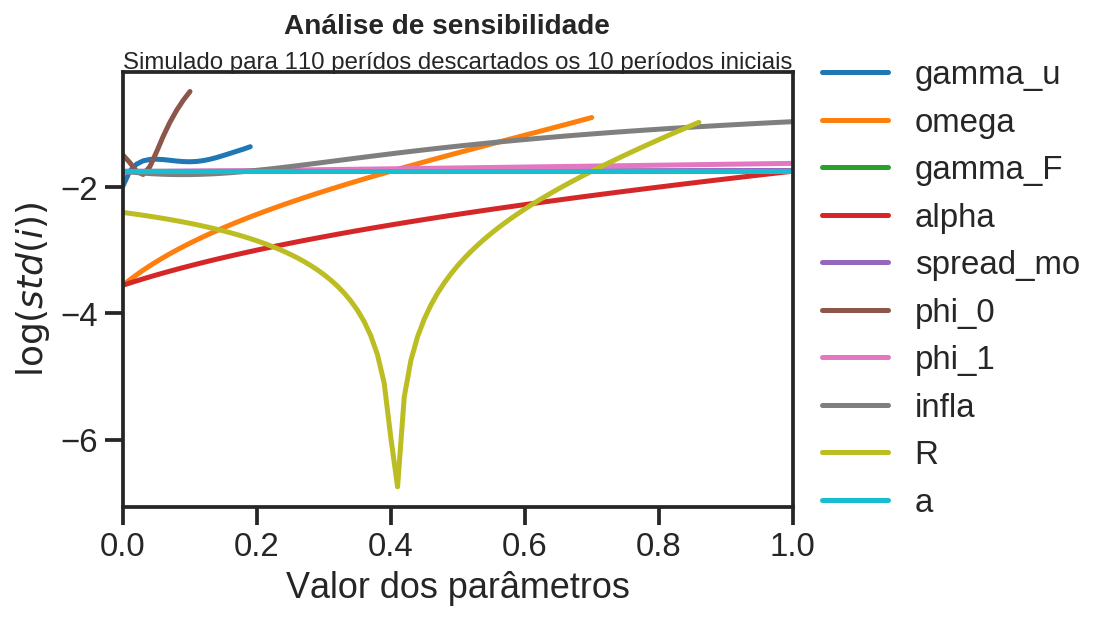

Total running time:  0:14:57.088550


gamma_u     omega   gamma_F     alpha  spread_mo     phi_0     phi_1  \
0.00 -1.977673 -3.551715 -1.745913 -3.551819  -1.745913 -1.491315 -1.757115   
0.01 -1.745913 -3.467732 -1.745913 -3.517537  -1.745796 -1.606939 -1.756039   
0.02 -1.635194 -3.389009 -1.745913 -3.484175  -1.745679 -1.745913 -1.754952   
0.03 -1.581655 -3.314848 -1.745913 -3.451678  -1.745563 -1.796985 -1.753855   
0.04 -1.559304 -3.244679 -1.745913 -3.419998  -1.745446 -1.675592 -1.752749   
...        ...       ...       ...       ...        ...       ...       ...   
0.96       inf       inf -1.745913 -1.794514  -1.734325       inf -1.626992   
0.97       inf       inf -1.745913 -1.782299  -1.734201       inf -1.625546   
0.98       inf       inf -1.745913 -1.770128  -1.734076       inf -1.624101   
0.99       inf       inf -1.745913 -1.757999  -1.733951       inf -1.622659   
1.00       inf       inf -1.745913 -1.745913  -1.733827       inf -1.621218   

         infla         R         a  
0.00 -1.745913 -2.399135 -1.745913  
0.01 -1.757115 -2.413345 -1.745913  
0.02 -1.767107 -2.428126 -1.745913  
0.03 -1.775827 -2.443511 -1.745913  
0.04 -1.783226 -2.459535 -1.745913  
...        ...       ...       ...  
0.96 -0.981840       inf -1.745913  
0.97 -0.976433       inf -1.745913  
0.98 -0.971104       inf -1.745913  
0.99 -0.965850       inf -1.745913  
1.00 -0.960670       inf -1.745913  

[101 rows x 10 columns]

In [36]:
sobol(time=100)

# Finishing

In [37]:
print("Total running time: ", datetime.now() - t1)
print("Simulation running time: ", t2 - t1)
print("Sobol running time: ", datetime.now() - t2)

Total running time:  0:18:24.565815
Simulation running time:  0:03:27.429390
Sobol running time:  0:14:57.136593


# Shock yourself

In [38]:
base = model()
df = SolveSFC(base, time=1000)

@interact(variable = (df.transpose().loc['alpha':,:].index), increase = (-1,1,0.01))
def shock_yourself(variable, increase):
  shock = ShockModel(base_model = base, create_function = model(), variable = variable, increase = increase)
  clock_plots(shock, 'SelfClock.png', variable=variable)
  plot_shock(shock=shock, filename='SelfShock.png')
  plot_norms(shock=shock, filename='SelfShock.png')
  other_plots(shock)

Widget Javascript not detected.  It may not be installed or enabled properly.


# Plugging real data

In [40]:
data = pd.read_csv('../SeriesTemporais/Dados_yeojohnson.csv')

data = data[[
    "Taxa de juros", 
    "Inflação", 
    "gIh", 
    "Taxa Própria",
]]

data.head()

Taxa de juros  Inflação       gIh  Taxa Própria
0         0.0898  0.002985  0.065517      0.120443
1         0.0843  0.000760  0.052722      0.114776
2         0.0802 -0.001179  0.007945      0.111158
3         0.0814  0.005732  0.063046      0.100196
4         0.0750  0.002504  0.011942      0.095222

In [41]:
import pandas_datareader.data as web
import datetime

start = datetime.datetime(1992, 1, 1)
end = datetime.datetime(2019, 4, 1)

R = web.DataReader(
    [
        'PRFI', # Private Residential Fixed Investment
        'HCCSDODNS' # Households and nonprofit organizations; consumer credit; liability, Level
    ], 'fred', start, end)

R.columns = [
    'Ih', 'Ck'
]
R.index.name = ""
R.index = data.index

R['Z'] = R['Ih'] + R['Ck']
R['R'] = R['Ck']/R['Z']

data['R'] = R['R']
data.head()

Taxa de juros  Inflação       gIh  Taxa Própria         R
0         0.0898  0.002985  0.065517      0.120443  0.771277
1         0.0843  0.000760  0.052722      0.114776  0.763079
2         0.0802 -0.001179  0.007945      0.111158  0.762396
3         0.0814  0.005732  0.063046      0.100196  0.754523
4         0.0750  0.002504  0.011942      0.095222  0.754205

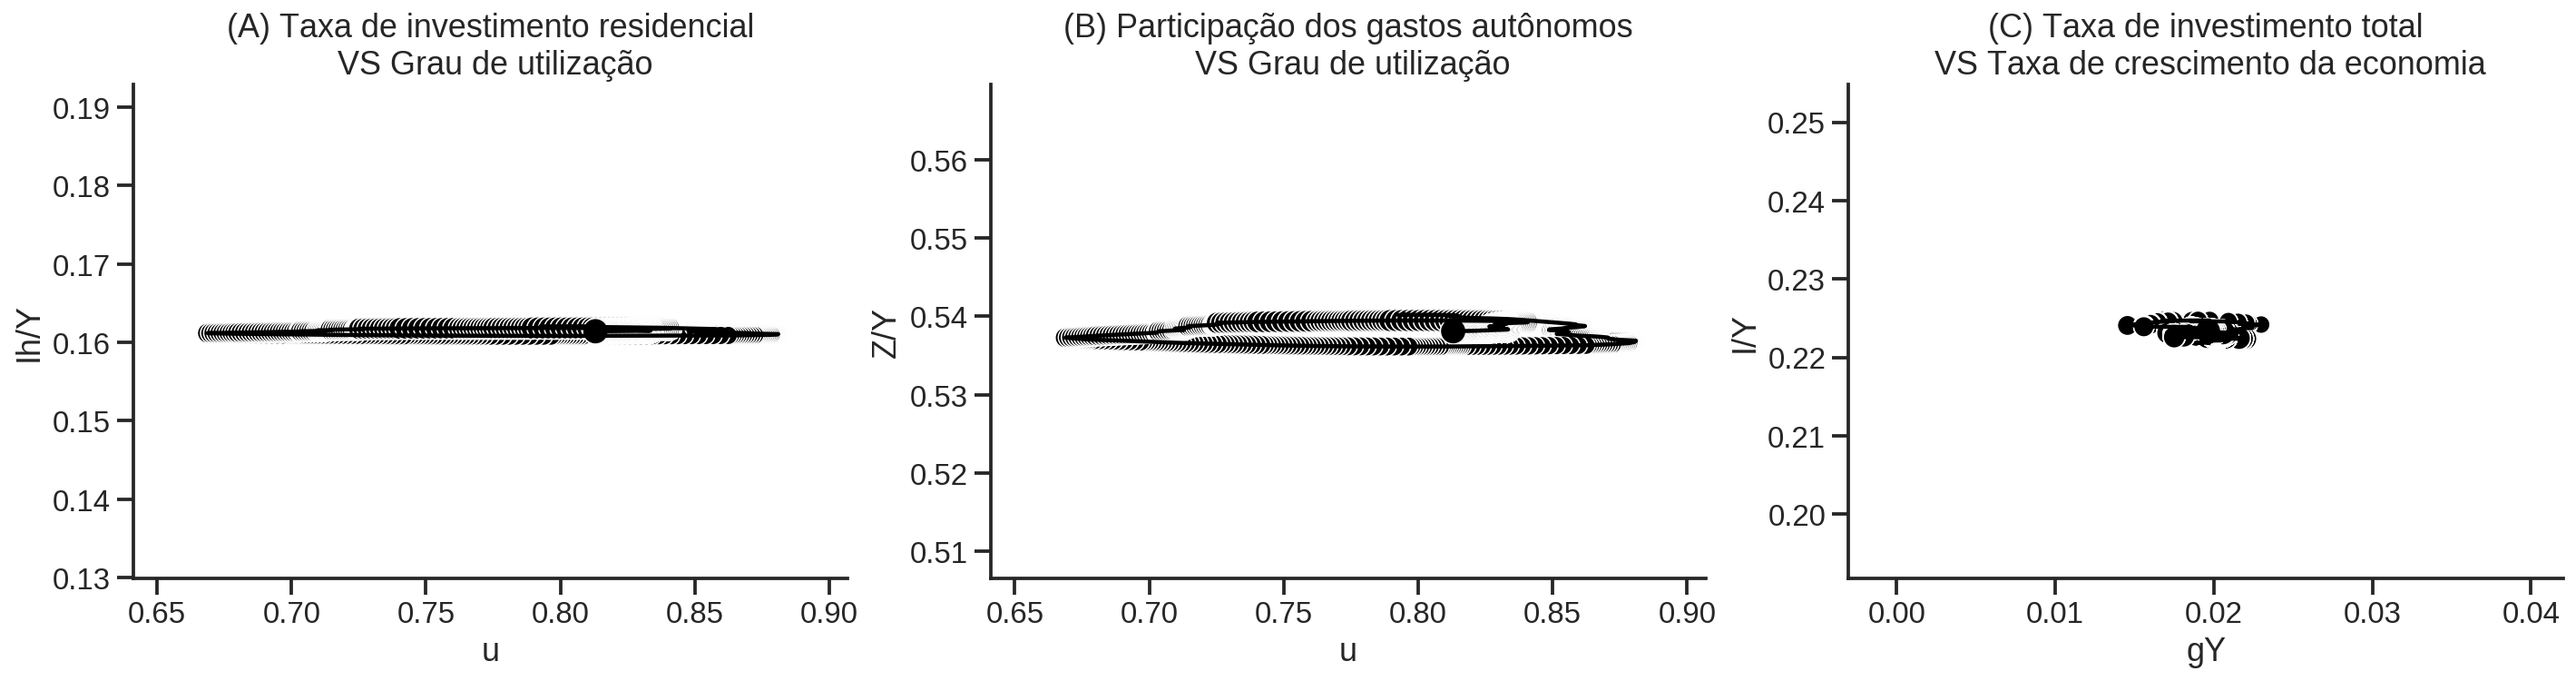

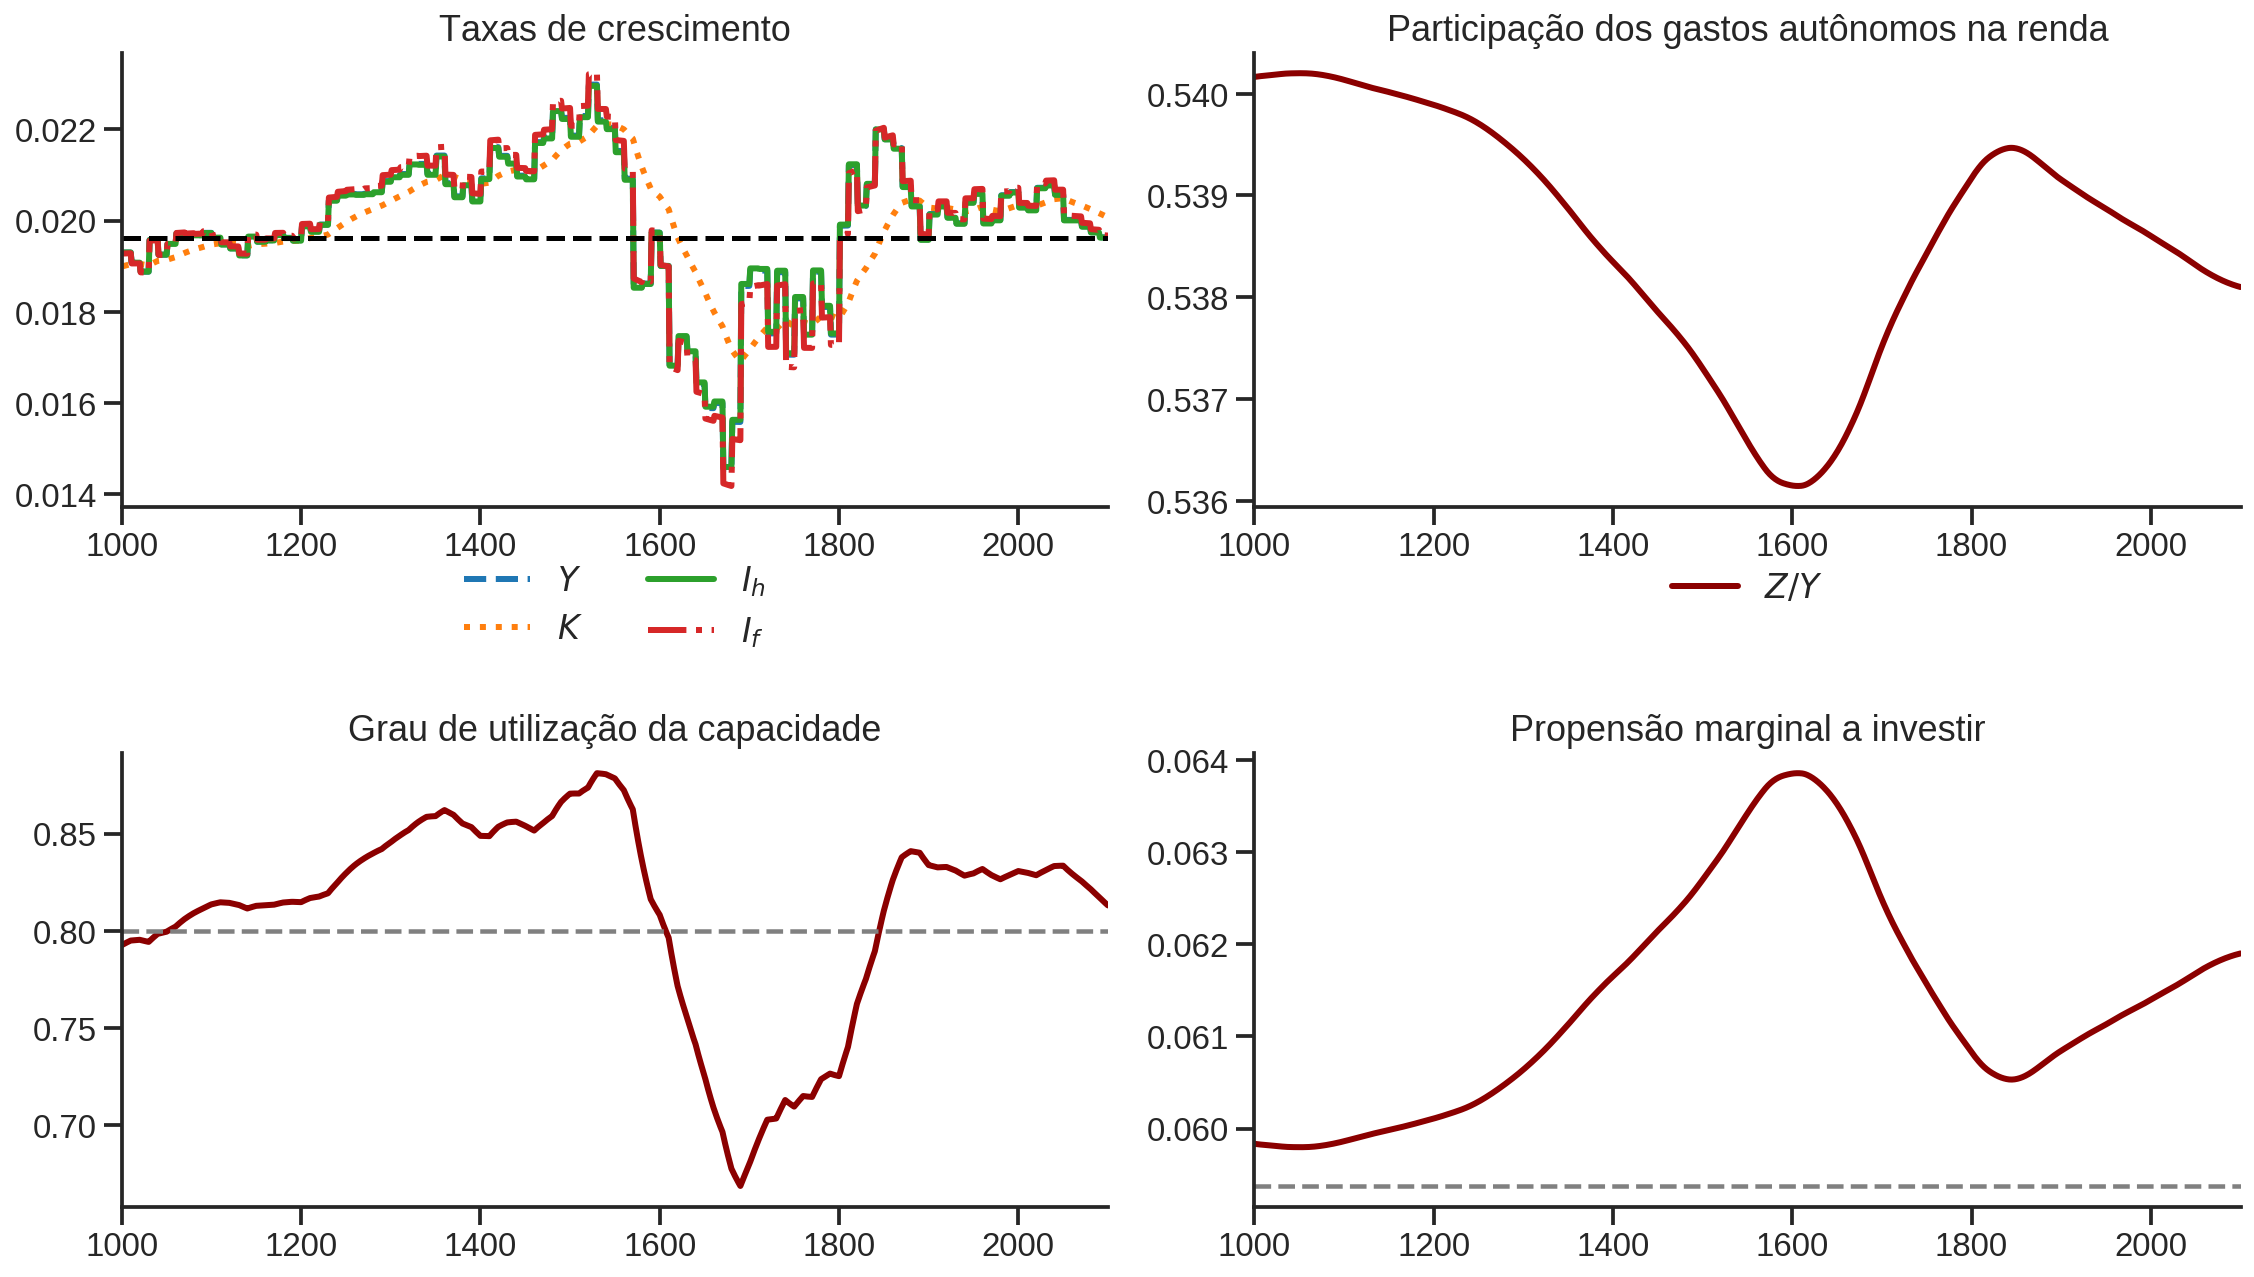

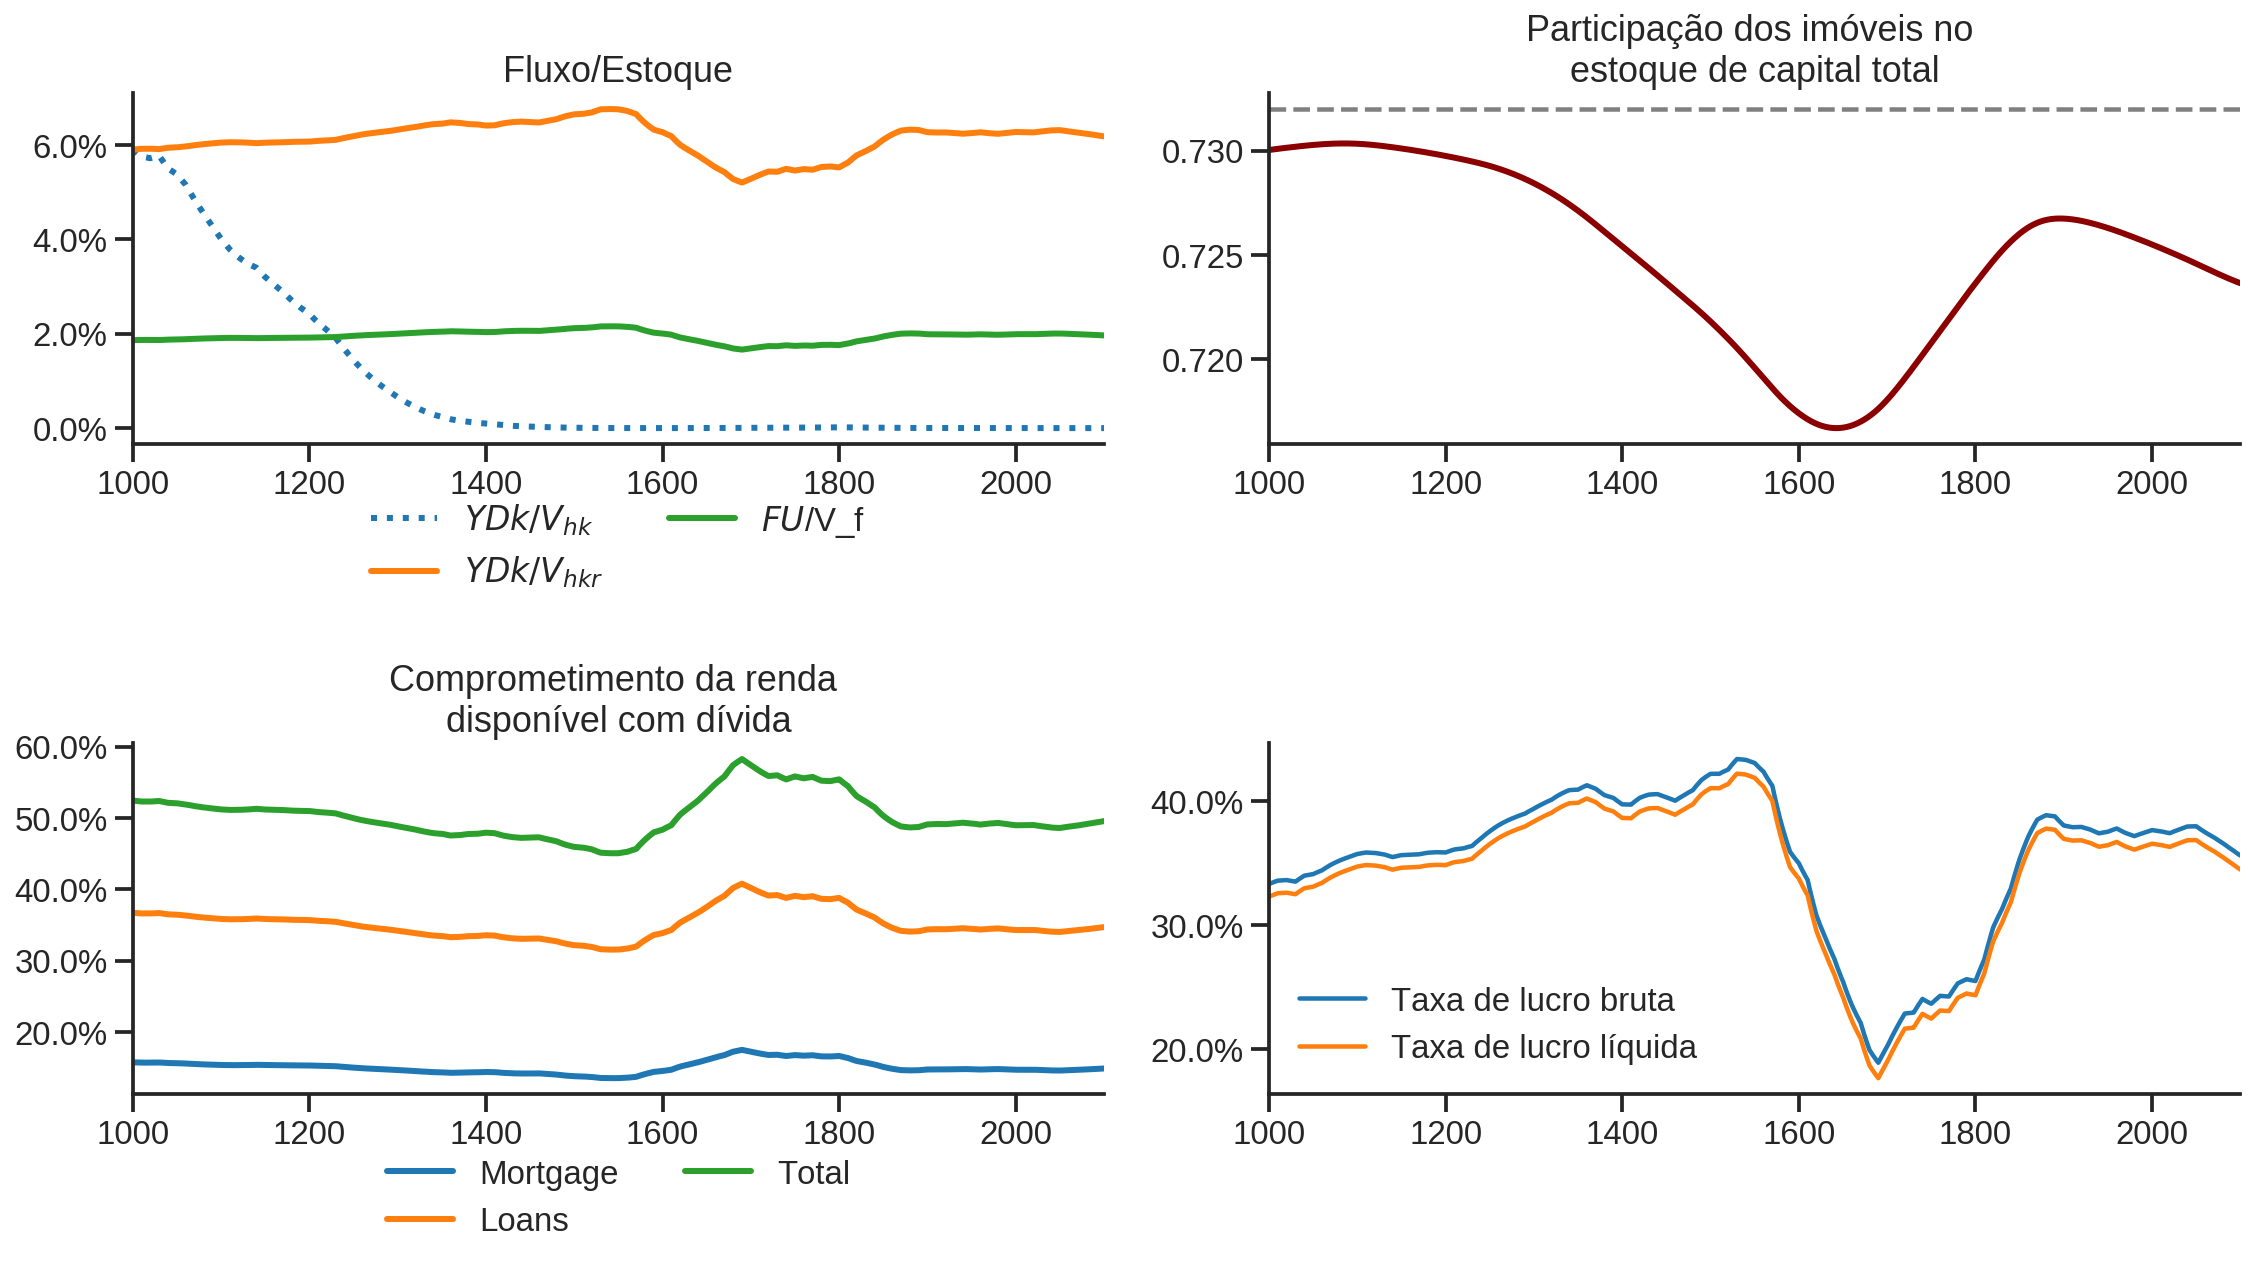

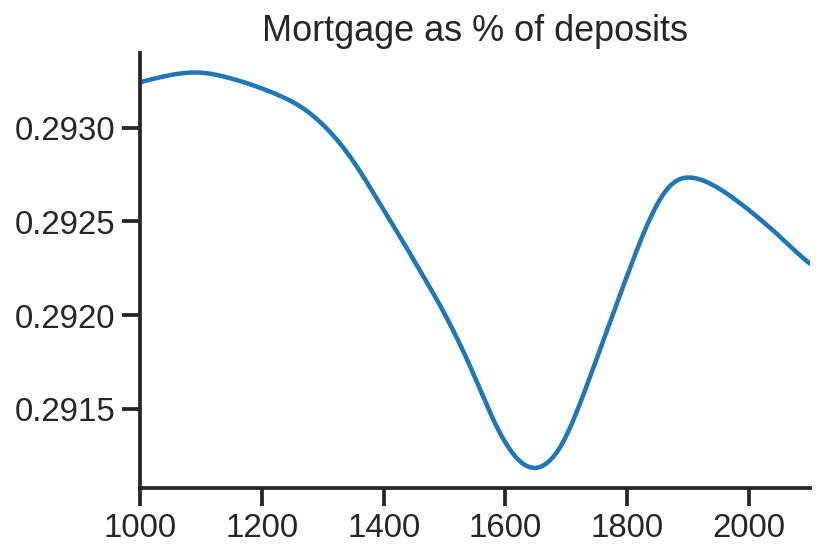

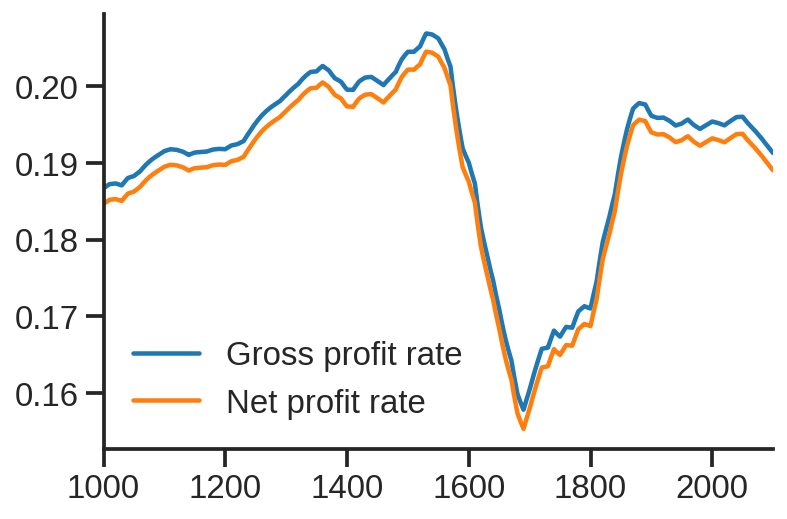

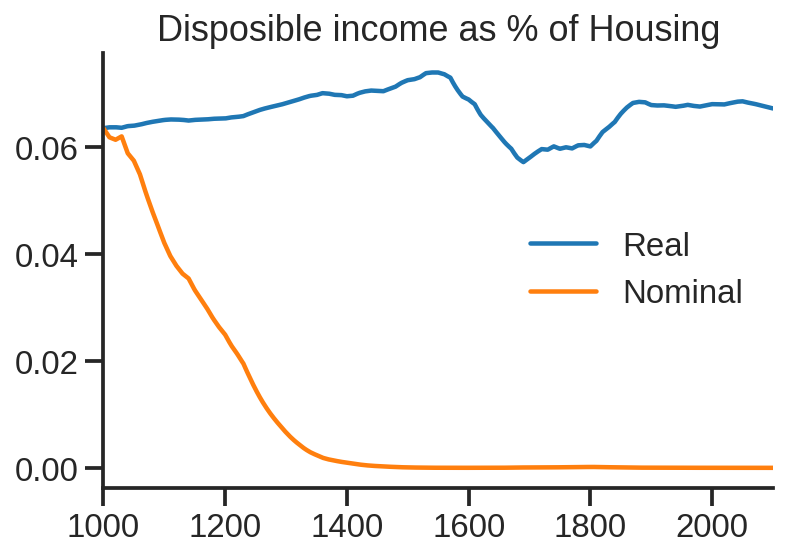

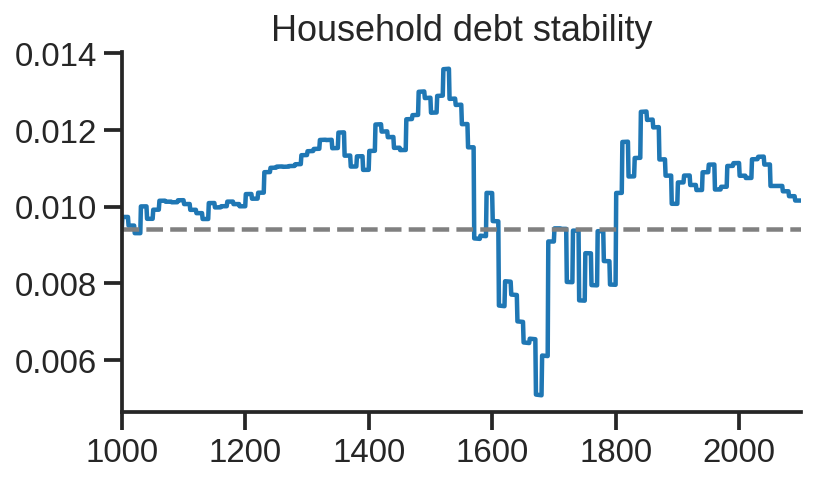

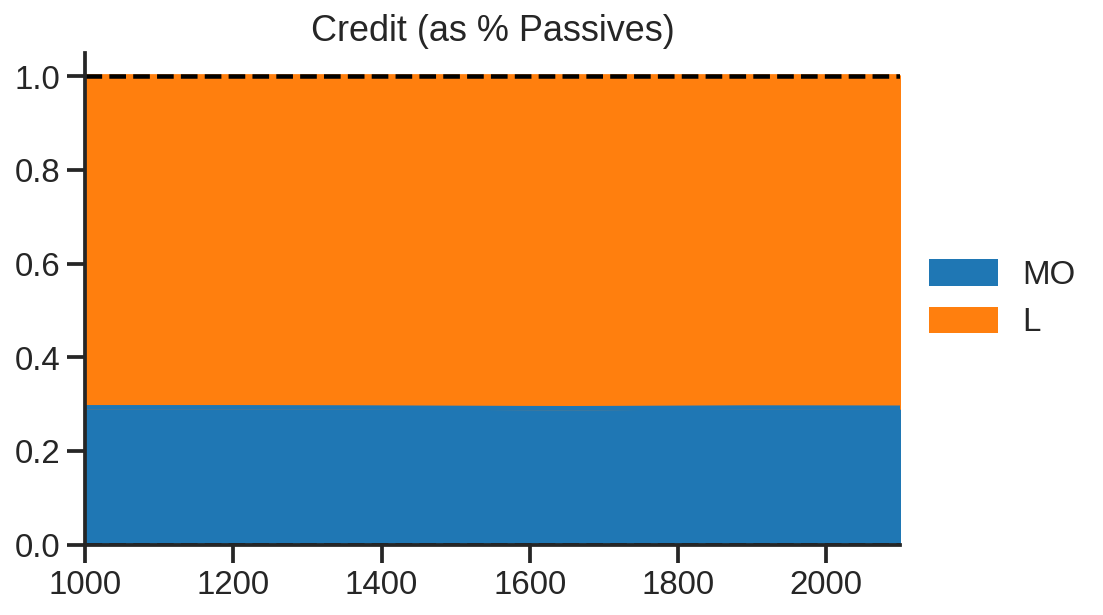

In [42]:
base=model(gamma_u=0.003)

initial=1000
shock_duration=10 ## Warning 10

SolveSFC(base, time=initial, table=False)

for i in data.index:
    lagged = [key for key in base.solutions[-1].keys()]
    lagged = [i for i in lagged if "__" in i]
    for j in lagged:
        del base.solutions[-1][j]
    base.set_values(base.solutions[-1])
    base.set_values({
            'own':data['Taxa Própria'][i],
            'infla':data['Inflação'][i],
            'rmo':data['Taxa de juros'][i],
            #'g_Z':data['gZ'][i],
            #'R':data['R'][i],
        })
    try: 
        SolveSFC(base, time=shock_duration, table=False)
    except Exception as e:
        print(f'For time = {i}, {e}')
        pass
    
shock = SFCTable(base)[initial:]
clock_plots(shock = shock, filename = 'Clock_Real.png', variable='real data')
plot_shock(shock = shock, filename = 'Shock_Real.png')
plot_norms(shock = shock, filename = 'Shock_RealNorms.png')
other_plots(shock)

# Defesa

In [ ]:
def plot_norms(filename, shock):
    """
    This function plots some selected variables
    
    filename: name to save the plot (str)
    shock: df returned by ShockModel function
    """
    sns.set_context('talk')
    fig, ax = plt.subplots(2,2, figsize=(16,10))

    ((shock["YDk"]/shock['V_h'])**(1)).plot(title = "Fluxo/Estoque", ax = ax[0,0], ls = (':'), lw=3)
    ((shock["YDk"]/shock['V_hr'])**(1)).plot(ax = ax[0,0], ls = ('-'), lw=3)
    ((shock["FU"]/shock['V_f'])**(1)).plot(ax = ax[0,0], ls = ('-'), lw=3)
    
    ax[0,0].set_yticklabels(['{:,.1%}'.format(x) for x in ax[0,0].get_yticks()])
    ax[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
                   labels = [
                       "$YDk/V_{hk}$",
                       "$YDk/V_{hkr}$",
                       "$FU$/V_f",
                            ],
              fancybox=True, shadow=True, ncol=2)
    #ax[0,0].ticklabel_format(useOffset=False)
    
    shock['K_k'].plot(color = "darkred", title = "Participação dos imóveis no \nestoque de capital total", label = "$\k$", legend = False, ax = ax[0,1], lw = 3, )
    ax[0,1].axhline(y = df['K_k'].iloc[-1], ls ='--', color = "gray")
    ax[0,1].ticklabel_format(useOffset=False)
    
    (shock["MO"]*shock["rmo"][1:]/shock['YDk'][1:]).plot(title="Comprometimento da renda \ndisponível com dívida", ax = ax[1,0], ls = ('-'), lw=3)
    ((shock["Lk"]*shock["rl"][1:])/shock['YDk'][1:]).plot(ax = ax[1,0], ls = ('-'), lw=3)
    ((shock["MO"]*shock["rmo"][1:] + shock["Lk"]*shock["rl"][1:])/shock['YDk'][1:]).plot( ax = ax[1,0], ls = ('-'), lw=3)
    ax[1,0].set_yticklabels(['{:,.1%}'.format(x) for x in ax[1,0].get_yticks()])
    ax[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                   labels = [
                       'Mortgage',
                       'Loans',
                       'Total'
                            ],
              fancybox=True, shadow=True, ncol=2)
    
    (shock['FT']/shock['K_f']).plot(ax=ax[1,1], label='Taxa de lucro bruta')
    (shock['Fn']/shock['K_f']).plot(ax=ax[1,1], label='Taxa de lucro líquida')
    ax[1,1].set_yticklabels(['{:,.1%}'.format(x) for x in ax[1,0].get_yticks()])
    ax[1,1].legend()

    
    sns.despine()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    fig.savefig(filename, dpi = 300)

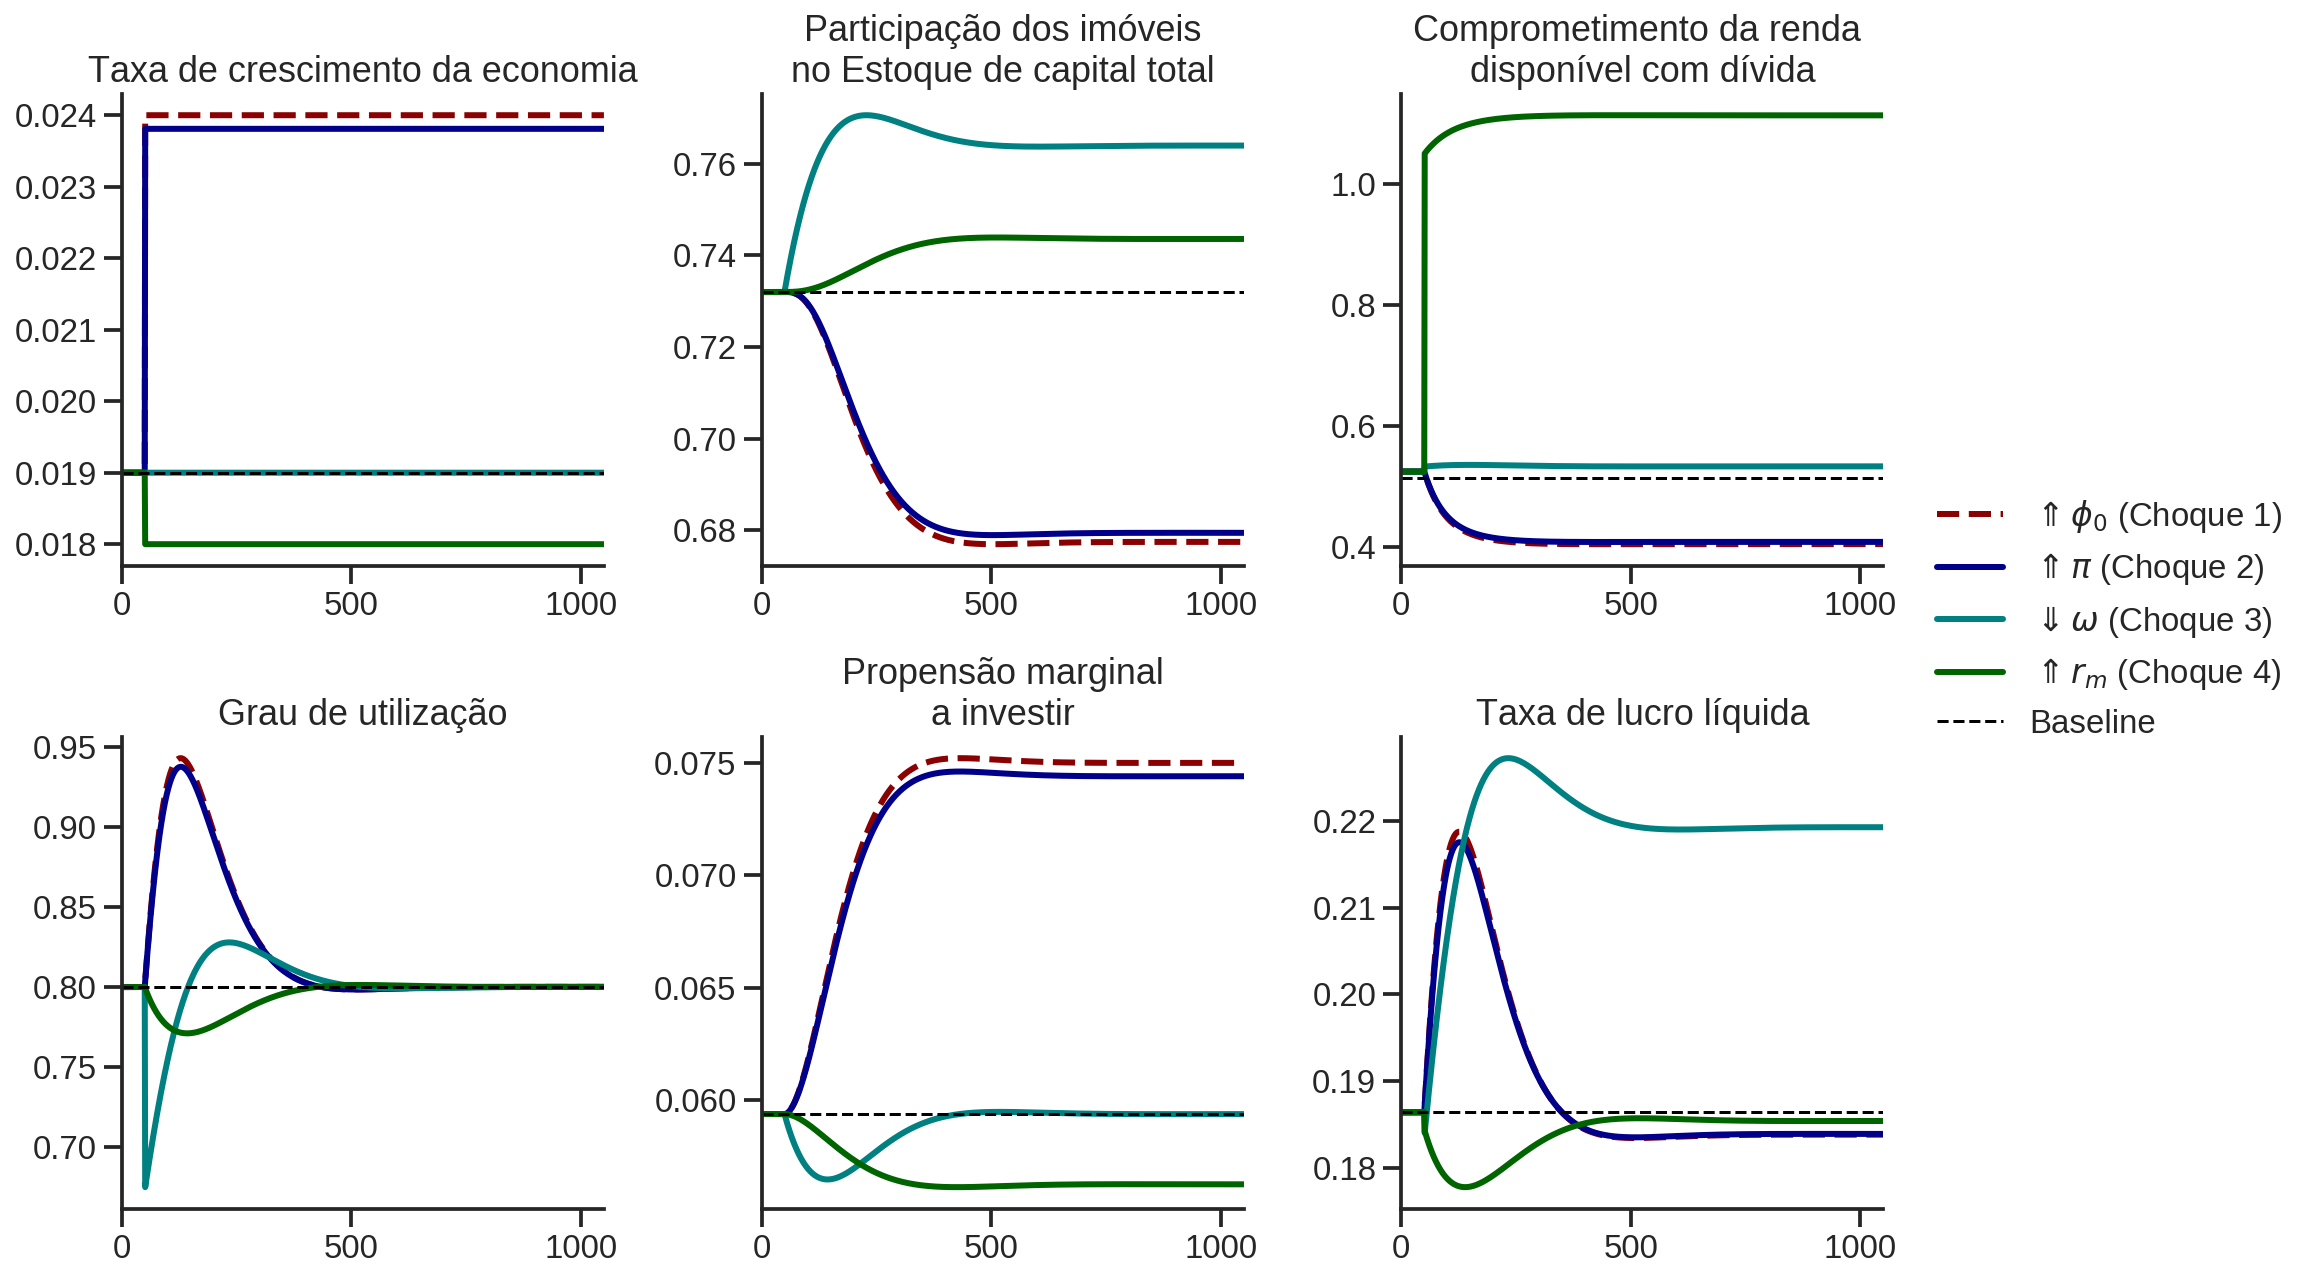

In [116]:
fig, ax = plt.subplots(2,3, figsize=(16,10))

df1['g_Z'].plot(ls ='--', lw=3, color = "darkred", label = "$\\Uparrow \phi_0$ (Choque 1)", ax = ax[0,0])
df4['g_Z'].plot(ls ='-', lw=3, color = "darkblue", label = "$\\Uparrow \pi$ (Choque 2)", ax = ax[0,0])
df2['g_Z'].plot(ls ='-', lw=3, color = "teal", label = "$\\Downarrow \omega$ (Choque 3)", ax = ax[0,0])
df3['g_Z'].plot(ls ='-', lw=3, color = "darkgreen", label = "$\\Uparrow r_m$ (Choque 4)", ax = ax[0,0])
ax[0,0].axhline(y = df_base['g_Z'].iloc[-1], ls ='--', lw=1.5, color = "black", label = "Baseline")
ax[0,0].ticklabel_format(useOffset=False)
ax[0,0].set_title('Taxa de crescimento da economia')

df1['K_k'].plot(ls ='--', lw=3, color = "darkred", label = "$\\Uparrow \phi_0$ (Choque 1)", ax = ax[0,1])
df4['K_k'].plot(ls ='-', lw=3, color = "darkblue", label = "$\\Uparrow \pi$ (Choque 2)", ax = ax[0,1])
df2['K_k'].plot(ls ='-', lw=3, color = "teal", label = "$\\Downarrow \omega$ (Choque 3)", ax = ax[0,1])
df3['K_k'].plot(ls ='-', lw=3, color = "darkgreen", label = "$\\Uparrow r_m$ (Choque 4)", ax = ax[0,1])
ax[0,1].axhline(y = df_base['K_k'].iloc[-1], ls ='--', lw=1.5, color = "black", label = "Baseline")
ax[0,1].ticklabel_format(useOffset=False)
ax[0,1].set_title('Participação dos imóveis\nno Estoque de capital total')

df1['u'].plot(ls ='--', lw=3, color = "darkred", label = "$\\Uparrow \phi_0$ (Choque 1)", ax = ax[1,0])
df4['u'].plot(ls ='-', lw=3, color = "darkblue", label = "$\\Uparrow \pi$ (Choque 2)", ax = ax[1,0])
df2['u'].plot(ls ='-', lw=3, color = "teal", label = "$\\Downarrow \omega$ (Choque 3)", ax = ax[1,0])
df3['u'].plot(ls ='-', lw=3, color = "darkgreen", label = "$\\Uparrow r_m$ (Choque 4)", ax = ax[1,0])
ax[1,0].axhline(y = df_base['u'].iloc[-1], ls ='--', lw=1.5, color = "black", label = "Baseline")
ax[1,0].ticklabel_format(useOffset=False)
ax[1,0].set_title('Grau de utilização')

df1['h'].plot(ls ='--', lw=3, color = "darkred", label = "$\\Uparrow \phi_0$ (Choque 1)", ax = ax[1,1])
df4['h'].plot(ls ='-', lw=3, color = "darkblue", label = "$\\Uparrow \pi$ (Choque 2)", ax = ax[1,1])
df2['h'].plot(ls ='-', lw=3, color = "teal", label = "$\\Downarrow \omega$ (Choque 3)", ax = ax[1,1])
df3['h'].plot(ls ='-', lw=3, color = "darkgreen", label = "$\\Uparrow r_m$ (Choque 4)", ax = ax[1,1])
ax[1,1].axhline(y = df_base['h'].iloc[-1], ls ='--', lw=1.5, color = "black", label = "Baseline")
ax[1,1].ticklabel_format(useOffset=False)
ax[1,1].set_title('Propensão marginal\na investir')


((df1["MO"]*df1["rmo"][1:] + df1["Lk"]*df1["rl"][1:])/df1['YDk'][1:]).plot(ls ='--', lw=3, color = "darkred", label = "$\\Uparrow \phi_0$ (Choque 1)", ax = ax[0,2])
((df4["MO"]*df4["rmo"][1:] + df4["Lk"]*df4["rl"][1:])/df4['YDk'][1:]).plot(ls ='-', lw=3, color = "darkblue", label = "$\\Uparrow \pi$ (Choque 2)", ax = ax[0,2])
((df2["MO"]*df2["rmo"][1:] + df2["Lk"]*df2["rl"][1:])/df2['YDk'][1:]).plot(ls ='-', lw=3, color = "teal", label = "$\\Downarrow \omega$ (Choque 3)", ax = ax[0,2])
((df3["MO"]*df3["rmo"][1:] + df3["Lk"]*df3["rl"][1:])/df3['YDk'][1:]).plot(ls ='-', lw=3, color = "darkgreen", label = "$\\Uparrow r_m$ (Choque 4)", ax = ax[0,2])
ax[0,2].axhline(y = ((df_base["MO"].iloc[-2]*df1["rmo"].iloc[-1] + df_base["Lk"].iloc[-2]*df_base["rl"].iloc[-1])/df_base['YDk'].iloc[-1]), ls ='--', lw=1.5, color = "black", label = "Baseline")
ax[0,2].ticklabel_format(useOffset=False)
ax[0,2].set_title('Comprometimento da renda \ndisponível com dívida')

(df1['Fn']/df1['K_f']).plot(ls ='--', lw=3, color = "darkred", label = "$\\Uparrow \phi_0$ (Choque 1)", ax = ax[1,2])
(df4['Fn']/df4['K_f']).plot(ls ='-', lw=3, color = "darkblue", label = "$\\Uparrow \pi$ (Choque 2)", ax = ax[1,2])
(df2['Fn']/df2['K_f']).plot(ls ='-', lw=3, color = "teal", label = "$\\Downarrow \omega$ (Choque 3)", ax = ax[1,2])
(df3['Fn']/df3['K_f']).plot(ls ='-', lw=3, color = "darkgreen", label = "$\\Uparrow r_m$ (Choque 4)", ax = ax[1,2])
ax[1,2].axhline(y = (df_base['Fn']/df_base['K_f']).iloc[-1], ls ='--', lw=1.5, color = "black", label = "Baseline")
ax[1,2].ticklabel_format(useOffset=False)
ax[1,2].set_title('Taxa de lucro líquida')


sns.despine()
plt.tight_layout(rect=[0, 0.03, .85, 0.95])
ax[1,2].legend(loc='center left', bbox_to_anchor=(1.05, 1.25))
plt.show()
fig.savefig("Defesa.png", dpi = 300)